In [1]:
import re
import collections
import math
import glob
import os
import pickle

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyranges as pr
import scipy

import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from statannotations.Annotator import Annotator

import adjustText
import plotnine as p9
import patchworklib as pw 

import statsmodels
from statsmodels.stats.contingency_tables import mcnemar

import Bio.motifs as motifs
from Bio import Phylo

<Figure size 100x100 with 0 Axes>

In [2]:
project_path = "/s/project/semi_supervised_multispecies/Zenodo/zenodo/"

## Utilities

In [3]:
arabic_to_roman = {"1":"I","2":"II","3":"III","4":"IV","5":"V","6":"VI","7":"VII","8":"VIII",
                  "9":"IX","10":"X","11":"XI","12":"XII","13":"XIII","14":"XIV","15":"XV","16":"XVI"}
nuc_to_number = {"A":0,"C":1,"G":2,"T":3}
number_to_nuc = {0:"A",1:"C",2:"G",3:"T"}
nuc_to_revcomp = {"A":"T","T":"A","G":"C","C":"G"}
nuc_to_revcomp_re = {"A":"T","T":"A","G":"C","C":"G",".":".","[":"]","]":"["}

scer_bg = np.array([0.3260, 0.1724, 0.1628, 0.3388])

regex_to_target_dict = {
    "A":np.array([1,0,0,0]),
    "C":np.array([0,1,0,0]),
    "G":np.array([0,0,1,0]),
    "T":np.array([0,0,0,1]),
}

def regex_to_targets(motif):
    in_group = False
    motif_targets = []
    for nt in motif:
        if nt == ".":
            motif_targets.append(np.array([1,1,1,1]))
        elif nt == "[":
            in_group = True
            accumulator = np.array([0,0,0,0])
        elif nt == "]":
            in_group = False
            motif_targets.append(accumulator)
        elif in_group:
            accumulator += regex_to_target_dict[nt]
        else:
            motif_targets.append(regex_to_target_dict[nt])
    return np.stack(motif_targets)

def regex_to_instances(motif):
    # convert to a list of "elements"
    in_group = False
    elements = []
    for nt in motif:
        if nt == "[":
            in_group = True
            accumulator = ""
        elif nt == "]":
            in_group = False
            elements.append(accumulator)
        elif in_group:
            accumulator += nt
        else:
            elements.append(nt)
    instances = [""]
    for elem in elements:
        instances_new = []
        # convert wildcard
        if elem == ".":
            elem = "ACGT"
        # create new strings
        for nt in elem:
            for instance in instances:
                instances_new.append(instance + nt)
        instances = instances_new
    return instances

def shuffle_regex(motif, n_shuffles = 10):
    motif_set = set([motif])
    instances = regex_to_instances(motif)
    # convert to a list of "elements"
    in_group = False
    elements = []
    for nt in motif:
        if nt == "[":
            in_group = True
            accumulator = nt
        elif nt == "]":
            in_group = False
            accumulator += nt
            elements.append(accumulator)
        elif in_group:
            accumulator += nt
        else:
            elements.append(nt)
    shuffled_motifs_list = []
    while True:
        # shuffle the regex
        np.random.shuffle(elements)
        shuffled_motif = "".join(elements)
        # ensure that the shuffled motif is new
        if motif_set == motif_set | set([shuffled_motif]):
            continue
        # ensure that the shuffled motif does not match any instances of the original
        if any(re.match(shuffled_motif, instance) for instance in instances):
            continue
        motif_set = motif_set | set([shuffled_motif])
        shuffled_motifs_list.append(shuffled_motif)
        if len(shuffled_motifs_list) == n_shuffles:
            break
    return shuffled_motifs_list 

In [4]:
def overlapping_matcher(motif, seq):
    result = []
    pos = 0
    pattern = re.compile(motif)
    while len(seq):
        m = pattern.search(seq, pos)
        if m:
            result.append(m)
            pos = m.start() + 1
        else:
            break
    return result 

def find_matches_noduplicates_upstream(dataset, motif):
    # find matches
    match_rows = dataset["five_prime_seq"].apply(lambda seq: overlapping_matcher(motif, seq))
    match_data = dataset[["gene_id","transcript_id","Chromosome","Strand","five_prime_start","five_prime_end","five_prime_seq","concat_start","concat_end"]].copy()
    match_data["matches"] = match_rows
    match_data = match_data.loc[match_data["matches"].apply(len) > 0]
    match_data = match_data.explode('matches')
    match_data["match_start"] = match_data['matches'].apply(lambda x: x.span()[0])
    match_data["match_end"] = match_data['matches'].apply(lambda x: x.span()[1])
    match_data["match_abspos"] = match_data.apply(lambda x: x['match_start'] + x["five_prime_start"] if x["Strand"] == "+" else x["five_prime_end"] - 1 - x["match_start"], axis=1)
    match_data["match_seq"] = match_data['matches'].apply(lambda x: x.group())
    # do not doublecount matches, instead associate them to closest gene
    match_data["match_key"] = match_data["Chromosome"].astype('str') + "_" + match_data["match_abspos"].astype('str') + "_" + match_data["Strand"].astype('str')
    match_data = match_data.sort_values("match_start").drop_duplicates(subset=["match_key"],keep="last")
    return match_data

In [5]:
def compute_metrics_for_motif(motif_targets, prbs_match, smooth_prbs):
    target_prbs = (motif_targets*prbs_match).sum(axis=1)
    if smooth_prbs:
        target_prbs = target_prbs + 0.01
        target_prbs = target_prbs/target_prbs.sum(axis=1, keepdims=True)
    avg_target_prbs = torch.mean(target_prbs)
    target_acc = (motif_targets*torch.nn.functional.one_hot(prbs_match.argmax(axis=1),num_classes=4)).sum()/motif_targets.shape[0]
    ce = torch.nn.functional.nll_loss(torch.log(prbs_match), motif_targets.argmax(axis=1))
    return avg_target_prbs, target_acc, ce


def get_metrics_for_motif_site(prbs, targets, match_pos, motif, smooth_prbs = False):
    # process regex motif 
    motif_targets = torch.tensor(regex_to_targets(motif))
    unambig_pos = torch.arange(motif_targets.shape[0])[(motif_targets.sum(axis=1) == 1)] # motif positions with only one option
    # select matching positions
    prbs_match = prbs[match_pos,:]
    targets_match = targets[match_pos]
    # sanity check: the target fits the motif
    assert (torch.nn.functional.one_hot(targets_match,num_classes=4)*motif_targets).sum() == len(motif_targets), print(targets_match, motif_targets)
    # compute metrics
    avg_target_prbs, target_acc, ce = compute_metrics_for_motif(motif_targets, prbs_match, smooth_prbs)
    # compute metrics for unambiguous positions only
    match_pos_unambig = match_pos[0] + unambig_pos
    prbs_match_unambig = prbs_match[unambig_pos,:]
    motif_targets_unambig = motif_targets[unambig_pos,:]
    avg_target_prbs_unambig, target_acc_unambig, ce_unambig = compute_metrics_for_motif(motif_targets_unambig, prbs_match_unambig, smooth_prbs)
    # get general area predictions
    match_area = torch.tensor(list(range(max(match_pos[0]-5,0),match_pos[-1]+5)))
    prbs_area = prbs[match_area,:]
    targets_area = targets[match_area]
    # return metrics
    return {
            "mean_target_prb":avg_target_prbs.item(),
            "accuracy":target_acc.item(),
            "mean_target_prb_unambig":avg_target_prbs_unambig.item(),
            "cross_entropy_unambig":-ce_unambig.item(),
            "accuracy_unambig":target_acc_unambig.item(),
            "prbs_area":prbs_area,
            "targets_area":targets_area,
        }

def get_conservation_for_motif_site(cons, targets, match_pos, motif):
    # process regex motif
    motif_targets = torch.tensor(regex_to_targets(motif))
    unambig_pos = torch.arange(motif_targets.shape[0])[(motif_targets.sum(axis=1) == 1)] # motif positions with only one option
    # select matching positions
    cons_match = cons[match_pos,:]
    targets_match = targets[match_pos]
    target_cons = (torch.nn.functional.one_hot(targets_match, num_classes=4)*cons_match).max(axis=1)[0]
    target_cons = torch.nan_to_num(target_cons)
    avg_target_cons = target_cons.mean()
    # compute metrics for unambiguous positions only
    match_pos_unambig = match_pos[0] + unambig_pos
    target_cons_unambig = target_cons[unambig_pos]
    avg_target_cons_unambig = target_cons_unambig.mean()
    # get general area predictions
    match_area = torch.tensor(list(range(max(match_pos[0]-5,0),match_pos[-1]+5)))
    cons_area = cons[match_area,:]
    targets_area = targets[match_area]
    # return metrics
    return {
            "mean_target_prb":avg_target_cons.item(),
            "accuracy":avg_target_cons.item(),
            "mean_target_prb_unambig":avg_target_cons_unambig.item(),
            "cross_entropy_unambig":avg_target_cons_unambig.item(),
            "accuracy_unambig":avg_target_cons_unambig.item(),
            "prbs_area":cons_area,
            "targets_area":targets_area,
        }

### Plot utilites

In [6]:
def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(mpl.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(mpl.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(mpl.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(mpl.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(mpl.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                mpl.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 despine=False,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_weights_given_ax(ax=ax, array=array,**kwargs)
    if despine:
        plt.axis('off')
    plt.show()
    return fig,ax


def plot_score_track_given_ax(arr, ax, threshold=None, **kwargs):
    ax.plot(np.arange(len(arr)), arr, **kwargs)
    if (threshold is not None):
        ax.plot([0, len(arr)-1], [threshold, threshold])
    ax.set_xlim(0,len(arr)-1)


def plot_score_track(arr, threshold=None, figsize=(20,2), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_score_track_given_ax(arr, threshold=threshold, ax=ax, **kwargs) 
    plt.show()

### ROC utilities

In [7]:
def get_roc(df, 
            score_col, 
            model, 
            label_col="original", 
            label_pos=None):
    print(model)
    df = df.query('model == @model')
    scores= np.array(df[score_col])
    if not label_pos:
        labels=np.array(df[label_col])#.astype('int')
    else:
        labels=np.array(df[label_col] == label_pos)
    fpr, tpr, thresholds = roc_curve(labels, scores)
    prec, rec, thresholds = precision_recall_curve(labels, scores)
    roc_auc = roc_auc_score(labels, scores)
    auc_var = delong_roc_variance(ground_truth=labels.astype('int'), 
                                   predictions = scores)[1]
    auprc = average_precision_score(labels, scores)
    return fpr, tpr, prec, rec, roc_auc, auprc, auc_var

def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (~ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count

# Downstream fixedlen

In [8]:
dataset = pd.read_parquet(project_path+"data/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/saccharomyces_cerevisiae_three_prime.parquet")
dataset["three_prime_seq"] = dataset["three_prime_seq"].str[:300]
dataset = dataset.loc[dataset["three_prime_seq"].str.len() == 300]
dataset["three_prime_start"] = dataset.apply(lambda x: x["three_prime_start"] if x["Strand"] == "+" else x["three_prime_end"] - 300, axis=1)
dataset["three_prime_end"] = dataset.apply(lambda x: x["three_prime_start"] + 300 if x["Strand"] == "+" else x["three_prime_end"], axis=1)

In [9]:
# determine positions in concatenated data
start = 0
starts = []
stops = []
for _,row in dataset.iterrows():
    starts.append(start)
    stops.append(start + len(row["three_prime_seq"]))
    start = start + len(row["three_prime_seq"]) 
    
dataset["concat_start"] = starts
dataset["concat_end"] = stops

In [12]:
annotated_utr3 = pd.read_csv(project_path+"data/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/Scer_half_life.csv")
annotated_utr3 = annotated_utr3[["chr", "UTR3_start", "UTR3_end", "genename", "strand", "UTR3_seq"]].rename(columns={"chr":"Chromosome","UTR3_start":"Start","UTR3_end":"End","strand":"Strand"})
annotated_utr3["Start"] = annotated_utr3["Start"] - 1
annotated_utr3 = pr.PyRanges(annotated_utr3)

In [13]:
dataset_pr = (pr.PyRanges(dataset[["Chromosome", "three_prime_start", "three_prime_end", "gene_id", "Strand","concat_start","concat_end", "three_prime_seq"]]
                          .rename(columns={"three_prime_start":"Start","three_prime_end":"End"})))
dataset_matched = dataset_pr.join(annotated_utr3).df
dataset_matched = dataset_matched.query('Strand == Strand_b')
dataset_matched["rel_pos"] = dataset_matched.apply(lambda x: x["Start_b"] - x["Start"] if x["Strand"] == "+" else x["End"] - x["End_b"], axis=1)     #["Start_b"] - dataset_matched["Start"]
dataset_matched = dataset_matched.query('rel_pos == 3')
dataset_matched["rel_end"] = dataset_matched.apply(lambda x: min(300,len(x["UTR3_seq"])+3), axis=1)

In [14]:
paths_dict = {
    "Nucleotide Distribution":project_path+"outputs/0_markov_scer_downstream_fixedlen_withstop/", 
    "All 1-Markov":project_path+"outputs/1_markov_scer_downstream_fixedlen_withstop/", 
    "All 2-Markov":project_path+"outputs/2_markov_scer_downstream_fixedlen_withstop/",  
    "All 3-Markov":project_path+"outputs/3_markov_scer_downstream_fixedlen_withstop/", 
    "All 4-Markov":project_path+"outputs/4_markov_scer_downstream_fixedlen_withstop/", 
    "All 5-Markov":project_path+"outputs/5_markov_scer_downstream_fixedlen_withstop/", 
    "All 6-Markov":project_path+"outputs/6_markov_scer_downstream_fixedlen_withstop/", 
    "BERT-ADN-200k":project_path+'outputs/bertadn_origtest_convolved_prb_agnostic_scer_downstream_fixedlen_512_withstop/',
    "BERT-ADN-Species-200k":project_path+'outputs/bertadn_origtest_convolved_prb_candida_glabrata_scer_downstream_fixedlen_512_withstop/',
    "Far-Alignment":project_path+"outputs/scer_align_far_withstop_downstream_fixedlen/",
    "Close-Alignment":project_path+"outputs/scer_align_close_withstop_downstream_fixedlen/",
    "m2-mixer100k": "./100k/",
    "m2-mixer200k": "./200k/",
    "m2-agnostic": "./agnostic100k/",
}


In [15]:
for model in paths_dict:
    path = paths_dict[model]
    targets = torch.load(path + "masked_targets.pt")
    prbs = torch.load(path + "prbs.pt")[:,:4]
    #prbs = prbs/prbs.sum(axis=1, keepdims=True) # normalize
    # compute metrics
    target_prbs = (torch.nn.functional.one_hot(targets)*prbs).max(axis=1)[0]
    acc = torch.sum(prbs.argmax(axis=1) == targets)/targets.shape[0]
   # sim = torch.sum(targets == targets)/targets.shape[0]
   # print(sim)
    avg_target_prbs = torch.mean(target_prbs)
    if "Alignment" in model:
        prbs_smoothed = prbs + 0.01
        prbs_smoothed = prbs_smoothed/prbs_smoothed.sum(axis=1, keepdims=True)
        ce = torch.nn.functional.nll_loss(torch.log(prbs_smoothed), targets)
    else:
        ce = torch.nn.functional.nll_loss(torch.log(prbs), targets)
    perplexity = torch.exp(ce)
    #print("{}: prb = {:.3f}, accuracy = {:.3f}".format(model,avg_target_prbs, acc))
    print("{}: CE = {:.3f}, accuracy = {:.3f}".format(model, ce, acc))
    prev = targets

Nucleotide Distribution: CE = 1.355, accuracy = 0.339
All 1-Markov: CE = 1.354, accuracy = 0.346
All 2-Markov: CE = 1.343, accuracy = 0.373
All 3-Markov: CE = 1.334, accuracy = 0.374
All 4-Markov: CE = 1.327, accuracy = 0.377
All 5-Markov: CE = 1.324, accuracy = 0.376
All 6-Markov: CE = 1.343, accuracy = 0.358
BERT-ADN-200k: CE = 1.252, accuracy = 0.426
BERT-ADN-Species-200k: CE = 1.250, accuracy = 0.426
Far-Alignment: CE = 1.525, accuracy = 0.440
Close-Alignment: CE = 1.273, accuracy = 0.732
m2-mixer100k: CE = 1.251, accuracy = 0.426
m2-mixer200k: CE = 1.249, accuracy = 0.428
m2-agnostic: CE = 1.253, accuracy = 0.425


In [16]:
def match_motif(motif, dataset = dataset_matched, only_annot = True):
    info_pos = np.array([i for i,x in enumerate(re.sub("\[.\]|\[..\]",".",motif)) if x != "."])
    print(info_pos)
    match_rows = dataset["three_prime_seq"].apply(lambda seq: overlapping_matcher(motif, seq))
    pos = 0
    counter = 0
    col = "three_prime_seq"
    match_positions = []
    for row, data_row in zip(match_rows,[x[1] for x in dataset.iterrows()]):
        pos = data_row["concat_start"]
        for match in row:
            counter += 1
            start = match.span(0)[0]
            end = match.span(0)[1]
            if only_annot and end > data_row["rel_end"]:
                continue
            match_positions += [x for x in pos + start + info_pos]
    return match_positions

def match_location(loc="stop", dataset = dataset_matched, only_annot=True):
    pos = 0
    match_positions = []
    for _,row in dataset.iterrows():
        pos = row["concat_start"]
        if loc == "stop":
            match_positions += [pos,pos+1,pos+2]
        elif loc == "stop+1":
            match_positions += [pos+3]
        elif loc == "stop+flank":
            match_positions += [pos, pos+1, pos+2, pos+3, pos+4, pos+5]
        elif loc == "utr3_end":
            if not only_annot:
                start = pos + len(row["three_prime_seq"]) - 5
                end = pos + len(row["three_prime_seq"])
            else:
                start = pos + row["rel_end"] - 5
                end = pos + row["rel_end"]
            match_positions += list(range(start,end))
        elif loc == "all":
            match_positions += list(range(pos,pos+len(row["three_prime_seq"])))
        else:
            assert True#False
    return match_positions    

def compute_metrics(model, match_positions, motif, paths_dict=paths_dict):
    path = paths_dict[model]
    targets = torch.load(path + "masked_targets.pt")
    prbs = torch.load(path + "prbs.pt")[:,:4]
    #prbs = torch.tensor(np.ones((648868,4))*0.25)
    # select matching positions
    prbs = prbs[torch.tensor(match_positions),:]
    targets = targets[torch.tensor(match_positions)]
    # compute metrics
    target_prbs = (torch.nn.functional.one_hot(targets,num_classes=4)*prbs).max(axis=1)[0]
    acc = torch.sum(prbs.argmax(axis=1) == targets)/targets.shape[0]
    acc_se = torch.sqrt(acc*(1-acc)/targets.shape[0])
    avg_target_prbs = torch.mean(target_prbs)
    target_prb_sd = torch.std_mean(target_prbs)[0]
    if "Alignment" in model:
        prbs_smoothed = prbs + 0.01
        prbs_smoothed = prbs_smoothed/prbs_smoothed.sum(axis=1, keepdims=True)
        ce = torch.nn.functional.nll_loss(torch.log(prbs_smoothed), targets)
    else:
        ce = torch.nn.functional.nll_loss(torch.log(prbs), targets)
    perplexity = torch.exp(ce)
    n = targets.shape[0]
    #print("{}: prb = {:.3f} (+/- {:.3f}), accuracy = {:.3f}".format(model, avg_target_prbs, target_prb_sd, acc))
    #print("{}: Prb = {:.3f}, CE = {:.3f}, accuracy = {:.3f}".format(model, avg_target_prbs, ce, acc))
    return {
            "model":model,
            "motif":motif,
            "n":targets.shape[0],
            "mean_target_prb":avg_target_prbs.item(),
            "cross_entropy":ce.item(),
            "accuracy":acc.item(),
            "acc_se":acc_se.item(),
            "acc_low":acc.item() - 2*acc_se.item(),
            "acc_high":acc.item() + 2*acc_se.item(),
        }

In [17]:
rows = []

utr3_motifs = ["TGCAT","TTCTTGT","ATATTC","TTTAATGA","TAATAAT","TGTAAATA"] 

loc_motifs = ["stop","stop+1","utr3_end","all"]

for motif in utr3_motifs + loc_motifs:
    if motif in loc_motifs:
        match_positions = match_location(loc = motif)
    else:
        match_positions = match_motif(motif)
    print(motif)
    for model in paths_dict:
        rows.append(compute_metrics(model, match_positions, motif))
        
metrics_df = pd.DataFrame(rows).sort_values(["motif","accuracy"]).reset_index(drop=True) #.query('model not in ["Close-Alignment"]').

[0 1 2 3 4]
TGCAT
[0 1 2 3 4 5 6]
TTCTTGT
[0 1 2 3 4 5]
ATATTC
[0 1 2 3 4 5 6 7]
TTTAATGA
[0 1 2 3 4 5 6]
TAATAAT
[0 1 2 3 4 5 6 7]
TGTAAATA
stop
stop+1
utr3_end
all


## Plot

In [18]:
set(metrics_df["model"])

{'All 1-Markov',
 'All 2-Markov',
 'All 3-Markov',
 'All 4-Markov',
 'All 5-Markov',
 'All 6-Markov',
 'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Close-Alignment',
 'Far-Alignment',
 'Nucleotide Distribution',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [19]:
model_order = ["Nucleotide Distribution", 
               'All 3-Markov',
               'All 4-Markov', 
               'All 5-Markov', 
               'All 6-Markov', 
               "Far-Alignment",
               "BERT-ADN-200k", 
               "BERT-ADN-Species-200k",
               "Close-Alignment",
               "m2-mixer100k",
               "m2-mixer200k",
               "m2-agnostic"
              ]

def assign_model_type(model):
    if "Species" in model:
        return "Species LM"
    elif "BERT" in model or "SSM" in model:
        return "Agnostic LM"
    elif model == "Close-Alignment":
        return "Alignment (close)"
    elif model == "Far-Alignment":
        return "Alignment (far)"
    elif model == "m2-mixer100k":
        return "M2 Species 100k"
    elif model == "m2-mixer200k":
        return "M2 Species 200k"
    elif model == "m2-agnostic":
        return "M2 Agnostic 100k"
    else:
        return "Baseline"
    
model_rename = {
    "Nucleotide Distribution":"Majority Class",
    'All 3-Markov':"Best k-mer",#"7-mers",
    'All 4-Markov':"Best k-mer",#"9-mers",
    'All 5-Markov':"Best k-mer",#"11-mers", 
    'All 6-Markov':"Best k-mer",#"13-mers", 
    "Far-Alignment": "Far-Alignment", #"WGA (inter-genus)",
    "SSM":"SSM", 
    "SSM-Species":"SSM-Species", 
    "BERT-ADN-200k":"Agnostic LM", 
    "BERT-ADN-Species-200k":"Species LM",
    "Close-Alignment" : "Close-Alignment",#"WGA (intra-genus)",
    "m2-mixer100k" : "M2 Species 100k",
    "m2-mixer200k" : "M2 Species 200k",
    "m2-agnostic" : "M2 Agnostic 100k"
}

motifs_of_interest = ["all","ATATTC","TGCAT","TTTAATGA","TAATAAT","TGTAAATA"]

plot_df = metrics_df.query('motif in @motifs_of_interest and model in @model_order')

In [20]:
motif_rename = {
    'all' : 'All',
    "TGTAAATA" : 'Puf3 (TGTAAATA)',
    "TGCAT" : "Whi3 (TGCAT)",
    "TTTAATGA" : "Pin4 (TTTAATGA)",
    "TAATAAT" : "Puf2 (TAATAAT)",
    "ATATTC" : "PRSE (ATATTC)",
}
plot_df['motif'] = plot_df['motif'].apply(lambda x: motif_rename[x])
#plot_df

In [21]:
plot_df["model_type"] = plot_df["model"].apply(assign_model_type)
plot_df["model_cat"] = plot_df["model"].apply(lambda x: model_rename[x])

plot_df = plot_df.query('model_cat != "Close-Alignment"').merge((plot_df.query('model_cat == "Close-Alignment"')
                                                                   [["motif","accuracy"]].rename(columns = {"accuracy":"acc_close"})
                                                                  ), on = "motif")

plot_df["model_cat"] = pd.Categorical(plot_df["model_cat"], categories=list(dict.fromkeys(model_rename.values())))
plot_df["model_type"] = pd.Categorical(plot_df["model_type"], categories=["Baseline","Alignment (far)", "Agnostic LM", "Species LM", "M2 Species 100k", "M2 Species 200k", "M2 Agnostic 100k"])

plot_df["motif_cat"] = pd.Categorical(plot_df["motif"], categories=motif_rename.values())

In [22]:
plot_df = plot_df.sort_values(["motif","accuracy"], ascending=False).drop_duplicates(["motif","model_cat"], keep="first")

In [31]:
df_only_models = plot_df[plot_df["model"].isin(["BERT-ADN-Species-200k", "m2-agnostic", "m2-mixer100k", "m2-mixer200k", "BERT-ADN-200k"])]
#df_only_models = plot_df[plot_df["model"] != "m2-agnostic"]
#df_only_models = plot_df

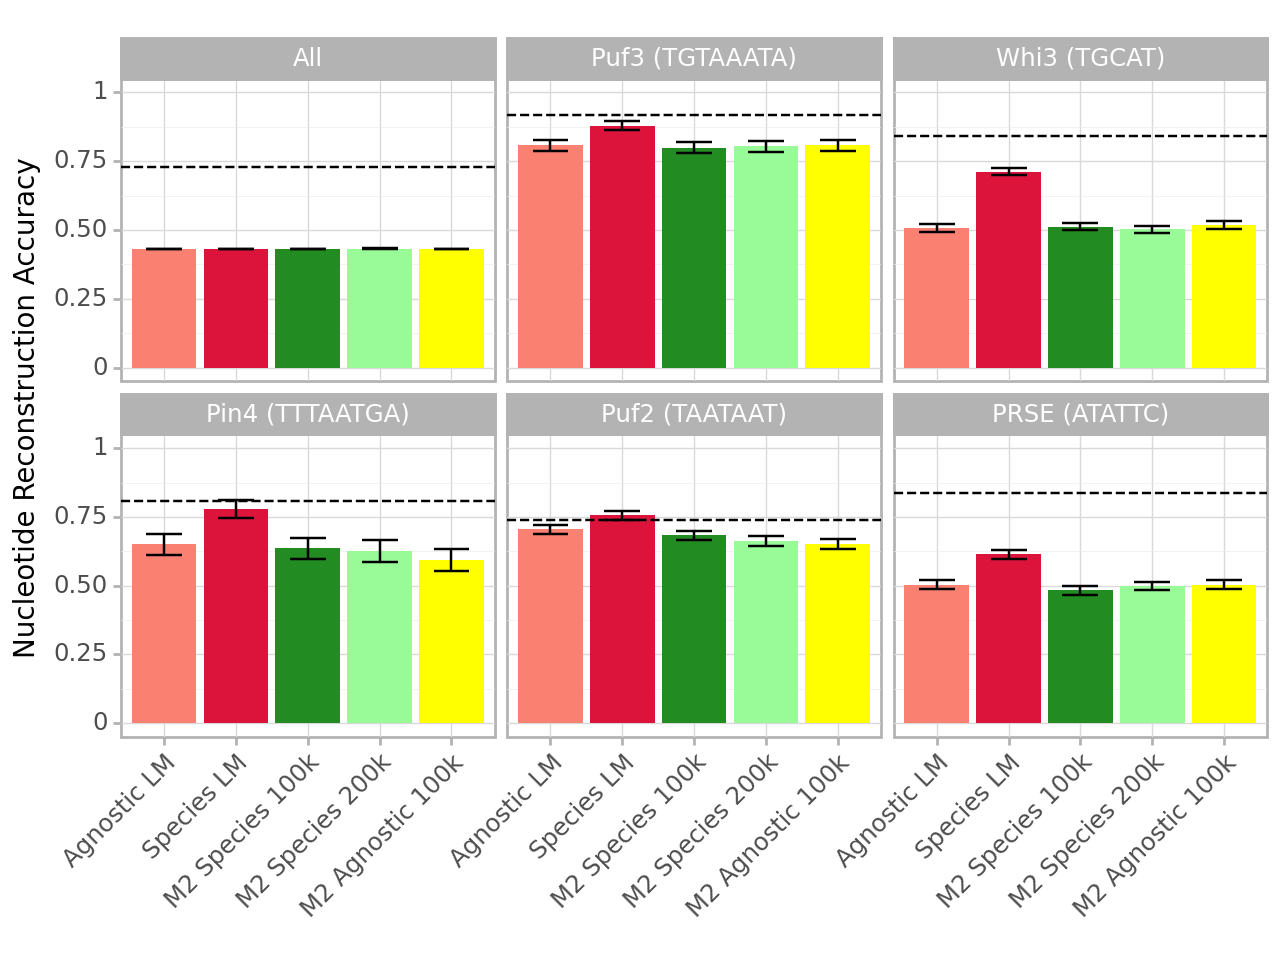

<Figure Size: (640 x 480)>

In [32]:

roc_relabeller = {
    "BERT-ADN-Species-200k":"Vanilla Species",
    "BERT-ADN-200k":"Vanilla Agnostic",
    "Conservation":"Conservation",
    "m2-mixer100k":"M2 Species 100k",
    "m2-mixer200k":"M2 Species 200k",
    "m2-agnostic":"M2 Agnostic 100k"
}

df_only_models["model"] = df_only_models["model"].apply(lambda x: roc_relabeller[x] if x in roc_relabeller.keys() else x)


p = (p9.ggplot(data = df_only_models,mapping=p9.aes(x="model_cat",y="accuracy", fill="model_type")) 
 + p9.geom_bar(stat="identity")
 + p9.geom_errorbar(mapping=p9.aes(x="model_cat", ymin="acc_low",ymax="acc_high"))
 + p9.geom_hline(mapping=p9.aes(yintercept="acc_close"), linetype="dashed")
 + p9.scale_fill_manual(values=["lightblue","steelblue","salmon","crimson", "forestgreen", "palegreen", "yellow"])
 + p9.facet_wrap('~motif_cat')
 + p9.labs(x="", y="Nucleotide Reconstruction Accuracy", fill = 'Model Type')
 + p9.theme_light()
 + p9.coord_cartesian(ylim=(0,1))
 + p9.theme(legend_position="none",
            legend_text=p9.element_text(size=9),legend_title=p9.element_text(size=9),
            subplots_adjust={'wspace': 0.1},
            axis_text_x=p9.element_text(rotation=45, hjust=1, rotation_mode='anchor'),
            legend_box_margin=0,legend_key_width=6,
            axis_title=p9.element_text(size=10))
)

p.save("./outputs/predictions/all_agnostic" + ".png", width=6.4, height=4.0, dpi=300)

p

## Relationship with conservation

In [26]:
def get_overall_metrics(model, dataset = dataset_matched, only_annot=True):
    if model == "Conservation":
        path = project_path+"outputs/scer_conservation_withstop_downstream_fixedlen/"
    else:
        path = paths_dict[model]
    # get prbs
    prbs = torch.load(path + "prbs.pt")[:,:4]
    targets = torch.load(path + "masked_targets.pt")
    # restrict to 3' UTR sequences
    utr3_df_list = []
    for _,row in dataset.iterrows():
        pos = row["concat_start"]
        if only_annot:
            end = row["rel_end"]
        else:
            end = row["concat_end"] - row["concat_start"]#row["rel_end"]
        prbs_3utr = prbs[pos:pos+end,:]
        targets_3utr = targets[pos:pos+end]
        #print(pos)
        #print(row["gene_id"])
        # compute the cross-entropy and accuracy
        if model == "Conservation":
            ce = (torch.nn.functional.one_hot(targets_3utr)*prbs_3utr).max(axis=1)[0]
            ce = torch.nan_to_num(ce)
            target_prb = ce
            max_prb = ce
        else:
            ce = -torch.nn.functional.nll_loss(torch.log(prbs_3utr), targets_3utr, reduction="none")
            target_prb = (torch.nn.functional.one_hot(targets_3utr)*prbs_3utr).max(axis=1)[0]
            max_prb = (prbs_3utr).max(axis=1)[0]
        # aggregate results
        utr3_df = pd.DataFrame({"pos":pos + np.arange(ce.shape[0]),"model":model,"ce":ce.numpy(),"target_prb":target_prb.numpy(),"max_prb":max_prb.numpy()})
        utr3_df_list.append(utr3_df)
    return pd.concat(utr3_df_list).reset_index(drop=True)

In [27]:
conservation_dfs = []

for model in ["BERT-ADN-200k","BERT-ADN-Species-200k", "m2-mixer100k", "m2-mixer200k", "Conservation"]:
    conservation_dfs.append(get_overall_metrics(model))

In [28]:
conservation_df = pd.concat(conservation_dfs)

In [29]:
conservation_df["pos"].describe()

count    3.028440e+06
mean     1.004239e+06
std      5.716703e+05
min      0.000000e+00
25%      4.990208e+05
50%      1.012810e+06
75%      1.501866e+06
max      1.977975e+06
Name: pos, dtype: float64

In [30]:
conservation_merged = conservation_df.query('model=="BERT-ADN-Species-200k"').sort_values('ce').merge(conservation_df.query('model=="Conservation"')[["ce","target_prb","pos"]],suffixes=("","_Conservation"), on="pos")
conservation_merged_agnostic = conservation_df.query('model=="BERT-ADN-200k"').sort_values('ce').merge(conservation_df.query('model=="Conservation"')[["ce","target_prb","pos"]],suffixes=("","_Conservation"), on="pos")
conservation_merged_100k = conservation_df.query('model=="m2-mixer100k"').sort_values('ce').merge(conservation_df.query('model=="Conservation"')[["ce","target_prb","pos"]],suffixes=("","_Conservation"), on="pos")
conservation_merged_200k = conservation_df.query('model=="m2-mixer200k"').sort_values('ce').merge(conservation_df.query('model=="Conservation"')[["ce","target_prb","pos"]],suffixes=("","_Conservation"), on="pos")

In [31]:
def make_labels_from_fixed_bins(bins):
    lower = list(np.array(bins))
    upper = lower[1:] + [1]
    bins = ["[{},{})".format(np.round(x,2),np.round(y,2)) for x,y in zip(lower,upper)]
    return bins

In [32]:
def set_bins(conservation_merged):
    # binning into quantiles
    quantiles = 5
    labels = list(range(quantiles))
    bins_prb = [x for x in np.quantile(conservation_merged["max_prb"],q=np.arange(quantiles)/quantiles)] + [float('inf')]
    conservation_merged['quantile'] = pd.cut(conservation_merged['max_prb'], bins=bins_prb, right=True, labels=labels, 
                                           retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True).fillna(labels[0])
    # binning the probability
    n_bins = 5
    bins = list(np.arange(n_bins)/n_bins)
    labels =  make_labels_from_fixed_bins(bins)
    bins = bins + [float('inf')]   
    conservation_merged['target_prb_bin'] = pd.cut(conservation_merged['target_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)

    # binning the max probability
    bins = [0.2499999, 0.3, 0.4, 0.6, 0.8]
    labels =  make_labels_from_fixed_bins(bins)
    bins = bins + [float('inf')]
    
    conservation_merged['max_prb_bin'] = pd.cut(conservation_merged['max_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)


In [33]:
set_bins(conservation_merged)
set_bins(conservation_merged_agnostic)
set_bins(conservation_merged_100k)
set_bins(conservation_merged_200k)

In [34]:
# binning into quantiles
quantiles = 5
labels = list(range(quantiles))
bins_prb = [x for x in np.quantile(conservation_merged["max_prb"],q=np.arange(quantiles)/quantiles)] + [float('inf')]
conservation_merged['quantile'] = pd.cut(conservation_merged['max_prb'], bins=bins_prb, right=True, labels=labels, 
                                           retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True).fillna(labels[0])
bins_prb_agnostic = [x for x in np.quantile(conservation_merged_agnostic["max_prb"],q=np.arange(quantiles)/quantiles)] + [float('inf')]
conservation_merged_agnostic['quantile'] = pd.cut(conservation_merged_agnostic['max_prb'], bins=bins_prb_agnostic, right=True, labels=labels, 
                                                    retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True).fillna(labels[0])
# binning the probability
n_bins = 5
bins = list(np.arange(n_bins)/n_bins)
labels =  make_labels_from_fixed_bins(bins)
bins = bins + [float('inf')]
conservation_merged['target_prb_bin'] = pd.cut(conservation_merged['target_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)
conservation_merged_agnostic['target_prb_bin'] = pd.cut(conservation_merged_agnostic['target_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)

# binning the max probability
bins = [0.2499999, 0.3, 0.4, 0.6, 0.8]
labels =  make_labels_from_fixed_bins(bins)
bins = bins + [float('inf')]
conservation_merged['max_prb_bin'] = pd.cut(conservation_merged['max_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)
conservation_merged_agnostic['max_prb_bin'] = pd.cut(conservation_merged_agnostic['max_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)




In [46]:
cons_df = pd.concat([conservation_merged,conservation_merged_agnostic, conservation_merged_100k, conservation_merged_200k])

### Accuracy as function of confidence

In [47]:
cons_df["acc"] = (cons_df["max_prb"] == cons_df["target_prb"]).astype(int)

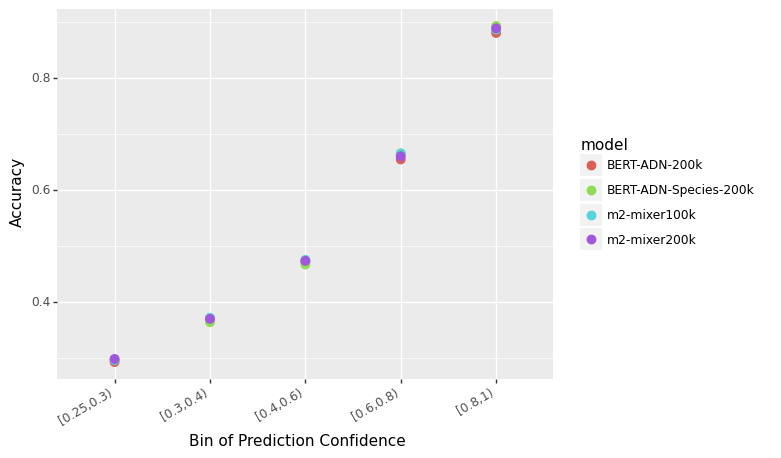

<ggplot: (1422417949703)>

In [48]:
p = (p9.ggplot(data=cons_df.groupby(['model','max_prb_bin'])["acc"].mean().reset_index(), 
           mapping=p9.aes(x="max_prb_bin",y="acc", color="model"))
 + p9.geom_point(size=3)
 + p9.labs(x="Bin of Prediction Confidence",y="Accuracy")
 + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
p

In [49]:
scipwy.stats.mannwhitneyu(cons_df.query('max_prb_bin == "[0.8,1)" and model == "BERT-ADN-200k"')["acc"],
                    cons_df.query('max_prb_bin == "[0.8,1)" and model == "BERT-ADN-Species-200k"')["acc"])

MannwhitneyuResult(statistic=121289438.0, pvalue=0.0005252208620805251)

### Binning the prediction confidence

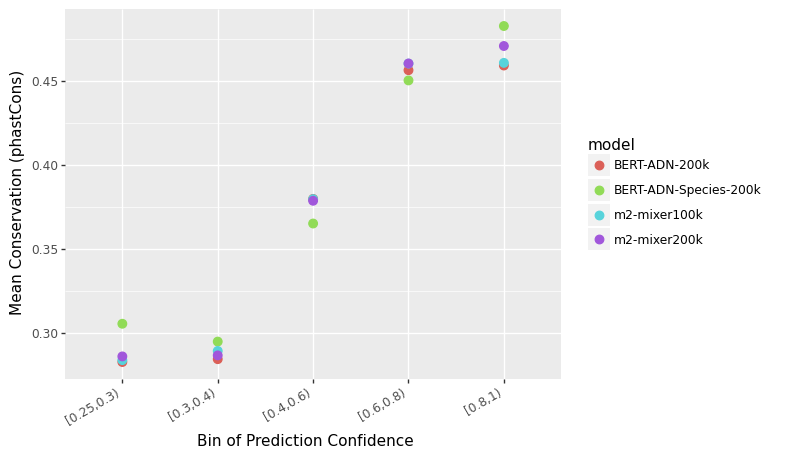

<ggplot: (1422417907688)>

In [50]:
p = (p9.ggplot(data=cons_df.groupby(['model','max_prb_bin'])["ce_Conservation"].mean().reset_index(), 
           mapping=p9.aes(x="max_prb_bin",y="ce_Conservation", color="model"))
 + p9.geom_point(size=3)
 + p9.labs(x="Bin of Prediction Confidence",y="Mean Conservation (phastCons)")
 + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
p

In [51]:
scipy.stats.mannwhitneyu(cons_df.query('max_prb_bin == "[0.8,1)" and model == "BERT-ADN-200k"')["ce_Conservation"],
                    cons_df.query('max_prb_bin == "[0.8,1)" and model == "BERT-ADN-Species-200k"')["ce_Conservation"])

MannwhitneyuResult(statistic=118586214.5, pvalue=1.3058971427699476e-07)

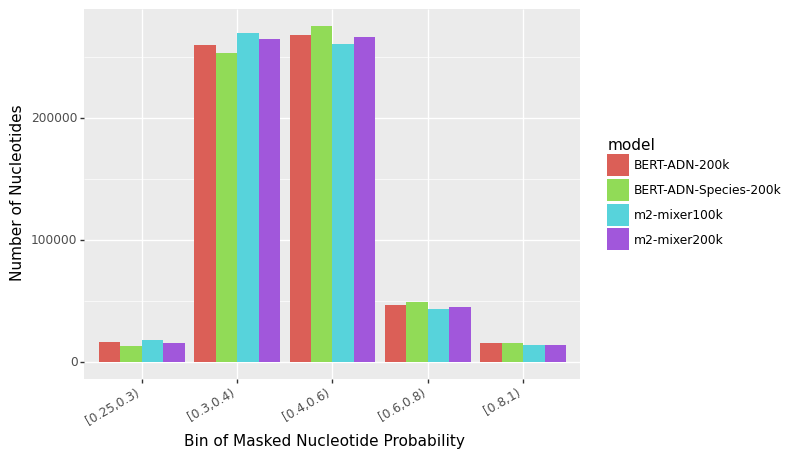

<ggplot: (1422384936135)>

In [52]:
p = (p9.ggplot(data=cons_df, 
           mapping=p9.aes(x="max_prb_bin", fill="model"))
 + p9.geom_bar(position="dodge")
 + p9.labs(x="Bin of Masked Nucleotide Probability",y="Number of Nucleotides")
 + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
p

### Binning the reconstruction probability

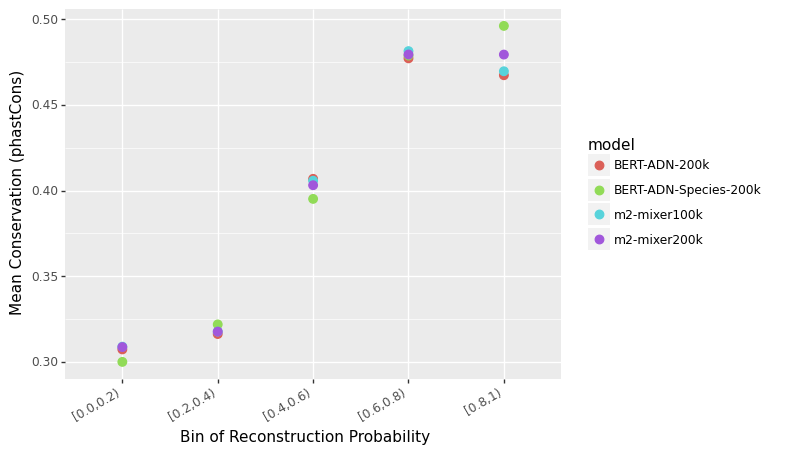

<ggplot: (1422384818682)>

In [53]:
p = (p9.ggplot(data=cons_df.groupby(['model','target_prb_bin'])["ce_Conservation"].mean().reset_index(), 
           mapping=p9.aes(x="target_prb_bin",y="ce_Conservation", color="model"))
 + p9.geom_point(size=3)
 + p9.labs(x="Bin of Reconstruction Probability",y="Mean Conservation (phastCons)")
 + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
p

In [54]:
scipy.stats.mannwhitneyu(cons_df.query('target_prb_bin == "[0.8,1)" and model == "BERT-ADN-200k"')["ce_Conservation"],
                    cons_df.query('target_prb_bin == "[0.8,1)" and model == "BERT-ADN-Species-200k"')["ce_Conservation"])

MannwhitneyuResult(statistic=92405561.5, pvalue=3.7023066163656176e-10)

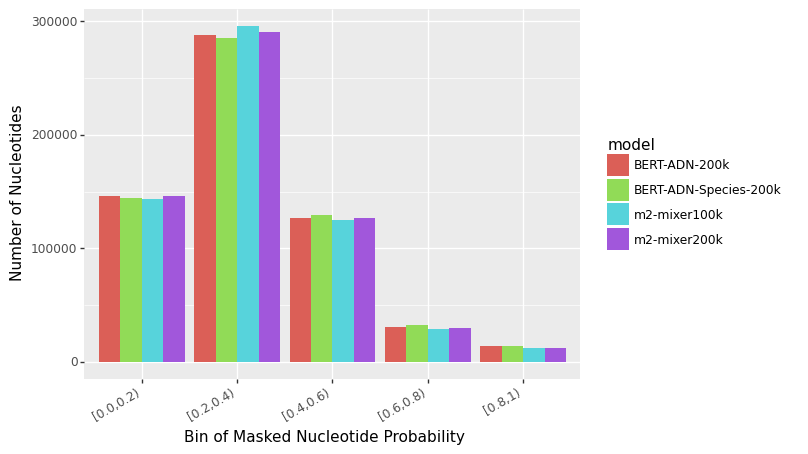

<ggplot: (1422414411261)>

In [55]:
(p9.ggplot(data=cons_df, 
           mapping=p9.aes(x="target_prb_bin", fill="model"))
 + p9.geom_bar(position="dodge")
 + p9.labs(x="Bin of Masked Nucleotide Probability",y="Number of Nucleotides")
 + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)

## PUF3 binding

In [35]:
def match_puf3_bind_site(model, dataset = dataset_matched):
    motif = "TGTAAATA"
    # load predictions and targets
    if model == "Conservation":
        path = project_path+"outputs/scer_conservation_withstop_downstream_fixedlen/"
    else:
        path = paths_dict[model]
    prbs = torch.load(path + "prbs.pt")[:,:4]
    targets = torch.load(path + "masked_targets.pt")
    # get sequences and find matches to puf3 consensus
    match_rows = dataset["three_prime_seq"].apply(lambda seq: overlapping_matcher(motif, seq))
    # extract genes with binding evidence
    puf3_bind_df = pd.read_csv(project_path + "data/Binding/puf3_clip_targets.tsv",sep="\t")
    puf3_binding_genes = set(puf3_bind_df["Gene"])
    out_rows = []
    for row,data_row in zip(match_rows,[x[1] for x in dataset.iterrows()]):
        pos = data_row["concat_start"]
        gene = data_row["gene_id"]
        for match in row:
            start = match.span(0)[0]
            end = match.span(0)[1]
            # exclude motif matches outside the annotated 3' UTR
            #if end > data_row["rel_end"]:
            #    continue  
            match_pos = torch.tensor(list(range(pos+start,pos+end)))
            # compute metrics
            if model == "Conservation":
                metrics = get_conservation_for_motif_site(prbs, targets, match_pos, motif)
            else:
                metrics = get_metrics_for_motif_site(prbs, targets, match_pos, motif)
            # add metadata
            metrics["model"] = model
            metrics["binding"] = gene in puf3_binding_genes
            metrics["ce"] = metrics["cross_entropy_unambig"]
            out_rows.append(metrics)
    return pd.DataFrame(out_rows)

In [36]:
puf3_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","m2-mixer100k","m2-mixer200k","m2-agnostic","Conservation"]#, "BERT-ADN-Species-Sacch_incl_488k"]#["BERT-ADN-200k","BERT-ADN-Species-200k","BERT-ADN-Sacch_incl","BERT-ADN-Species-Sacch_incl","Conservation"]

for model in roc_models:
    puf3_dfs.append(match_puf3_bind_site(model))

In [37]:
puf3_roc = pd.concat(puf3_dfs)

In [38]:
puf3_roc.query('model == "Conservation"')["binding"].mean()

0.47580645161290325

In [39]:
set(puf3_roc["model"])

{'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Conservation',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [40]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(puf3_roc, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
m2-mixer100k
m2-mixer200k
m2-agnostic
Conservation


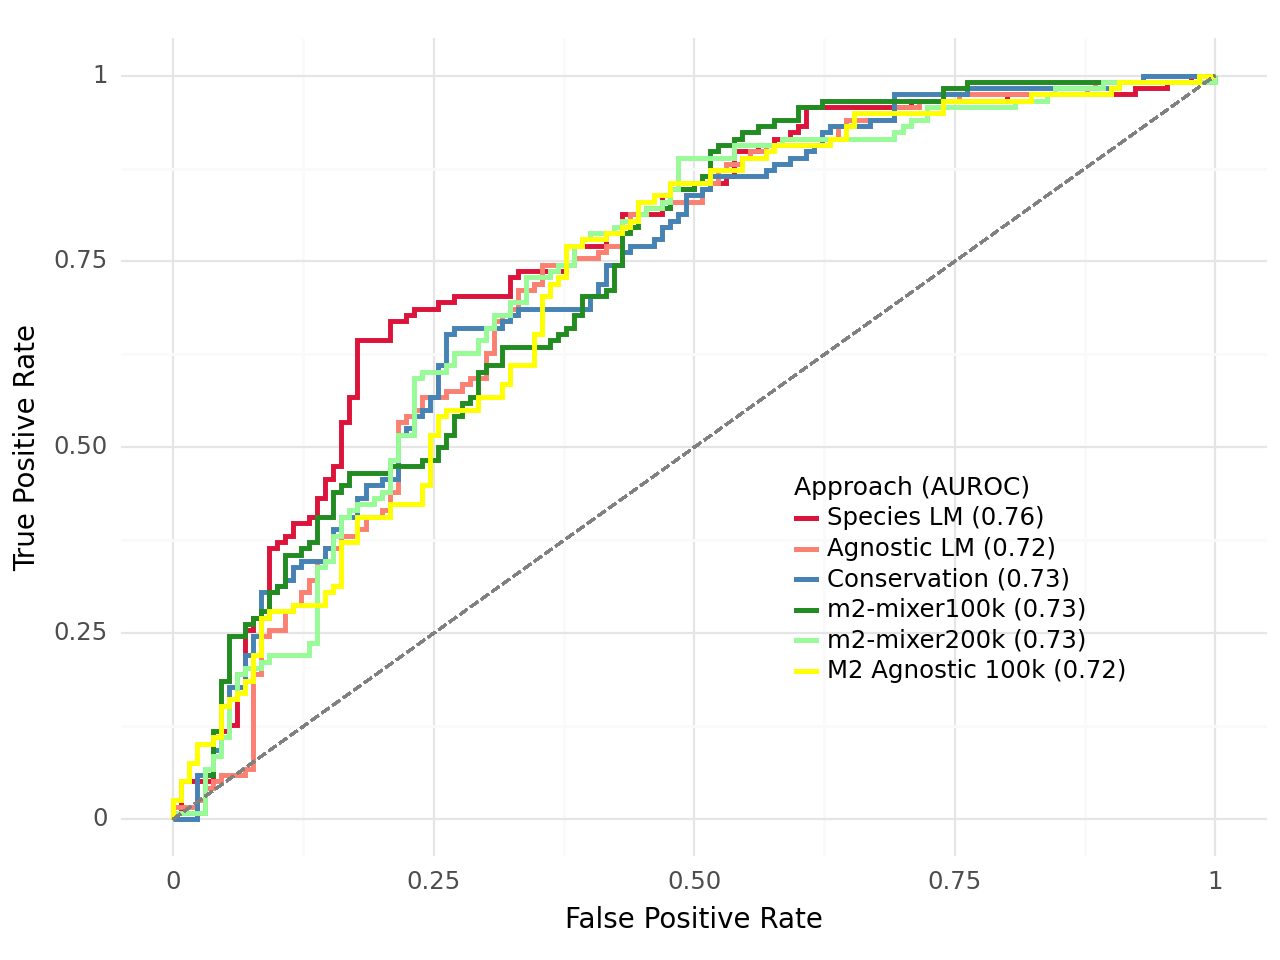

<Figure Size: (640 x 480)>

In [41]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "m2-mixer100k":"m2-mixer100k ({:2.2f})".format(roc_dict["m2-mixer100k"]["roc_auc"]),
    "m2-mixer200k":"m2-mixer200k ({:2.2f})".format(roc_dict["m2-mixer200k"]["roc_auc"]),
    "m2-agnostic":"M2 Agnostic 100k ({:2.2f})".format(roc_dict["m2-agnostic"]["roc_auc"])
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "forestgreen", "palegreen", "yellow"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.75,0.4), 
            legend_direction='vertical')
)
p.save("outputs/predictions/Puf3_classification_roc" + ".png", width=3.5, height=3.5, dpi=300)

p

## Motifs within/outside annotated 3'UTR

In [14]:
def locate_utr3_bind_site(model, dataset = dataset_matched, motif = "TGTAAATA"):
    if model == "Conservation":
        path = project_path+"outputs/scer_conservation_withstop_downstream_fixedlen/"
    else:
        path = paths_dict[model]
    # get prbs
    prbs = torch.load(path + "prbs.pt")[:,:4]
    targets = torch.load(path + "masked_targets.pt")
    # get sequences and find matches to consensus motif
    match_rows = dataset["three_prime_seq"].apply(lambda seq: overlapping_matcher(motif, seq))
    out_rows = []
    for row,data_row in zip(match_rows,[x[1] for x in dataset.iterrows()]):
        pos = data_row["concat_start"]
        gene = data_row["gene_id"]
        for match in row:
            start = match.span(0)[0]
            end = match.span(0)[1]
            # check if it is within the annotated 3' UTR
            if end > data_row["rel_end"]:
                within = False
            else:
                within = True
            # get metrics
            match_pos = torch.tensor(list(range(pos+start,pos+end)))
            # compute metrics
            if model == "Conservation":
                metrics = get_conservation_for_motif_site(prbs, targets, match_pos, motif)
            else:
                metrics = get_metrics_for_motif_site(prbs, targets, match_pos, motif)
            # add metadata
            metrics["model"] = model
            metrics["within"] = within
            metrics["ce"] = metrics["cross_entropy_unambig"]
            out_rows.append(metrics)
    return pd.DataFrame(out_rows)

### PUF3

In [77]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k",  "m2-mixer100k", "m2-mixer200k", "m2-agnostic", "Conservation"]#, "BERT-ADN-Species-Sacch_incl_488k"]#["BERT-ADN-200k","BERT-ADN-Species-200k","BERT-ADN-Sacch_incl","BERT-ADN-Species-Sacch_incl","Conservation"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site(model))

In [78]:
utr3_site_roc = pd.concat(utr3_site_dfs)

In [79]:
print(len(utr3_site_roc.query('model == "Conservation"')["within"]))
print(utr3_site_roc.query('model == "Conservation"')["within"].mean())

248
0.8387096774193549


In [80]:
set(utr3_site_roc["model"])

{'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Conservation',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [81]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(utr3_site_roc, "ce", model, label_col="within")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
m2-mixer100k
m2-mixer200k
m2-agnostic
Conservation


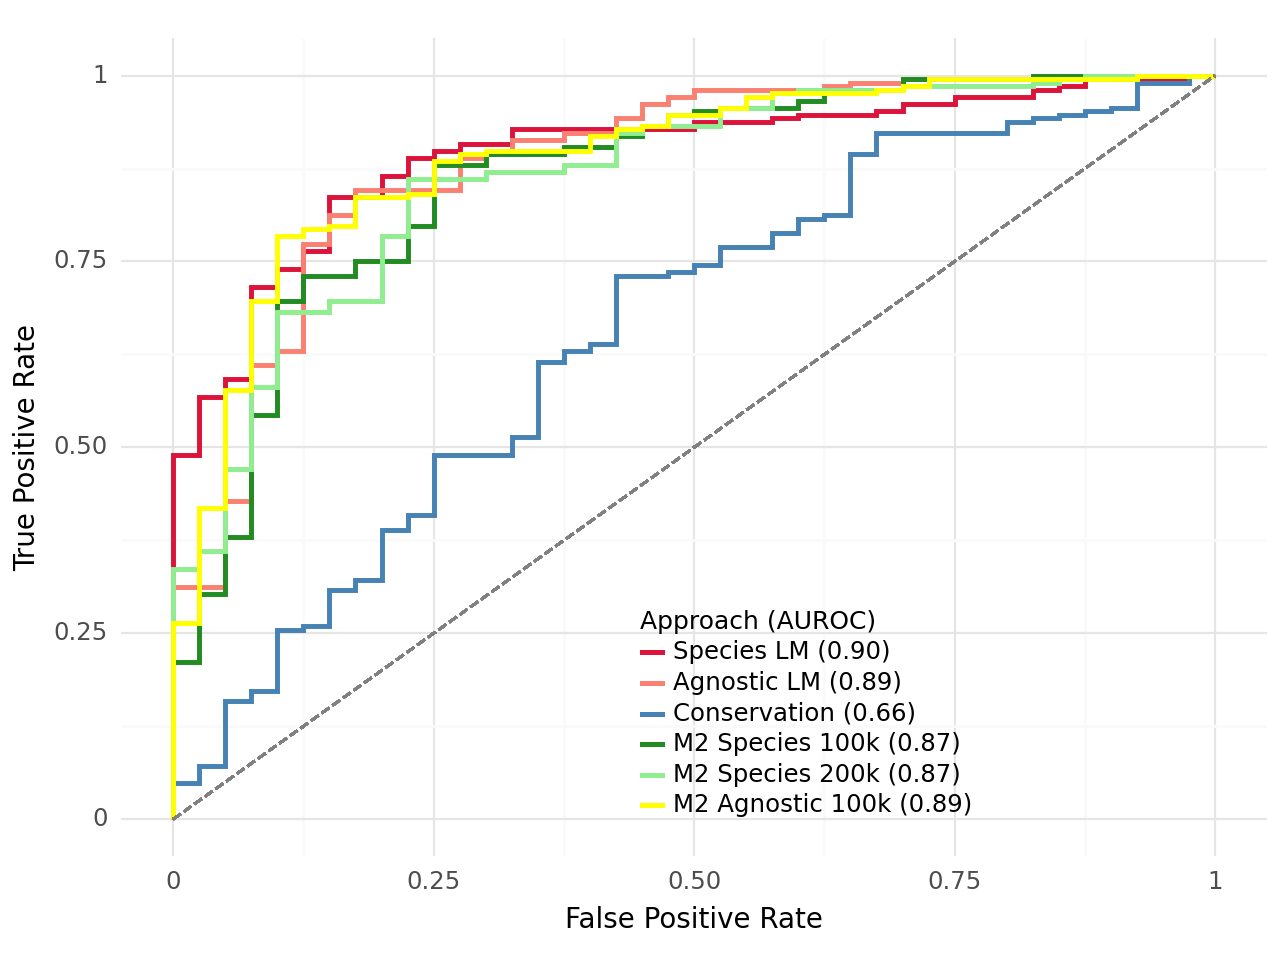

<Figure Size: (640 x 480)>

In [82]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "m2-mixer100k":"M2 Species 100k ({:2.2f})".format(roc_dict["m2-mixer100k"]["roc_auc"]),
    "m2-mixer200k":"M2 Species 200k ({:2.2f})".format(roc_dict["m2-mixer200k"]["roc_auc"]),
    "m2-agnostic":"M2 Agnostic 100k ({:2.2f})".format(roc_dict["m2-agnostic"]["roc_auc"])
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "forestgreen", "lightgreen", "yellow"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
p.save("./outputs/predictions/Puf3_distance_roc" + ".png", width=4.5, height=4.5, dpi=300)

p

### WHI3

In [51]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","m2-mixer100k", "m2-mixer200k", "m2-agnostic", "Conservation"]#["BERT-ADN-200k","BERT-ADN-Species-200k","BERT-ADN-Sacch_incl","BERT-ADN-Species-Sacch_incl","Conservation"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site(model, motif = "TGCAT"))

In [52]:
utr3_site_roc = pd.concat(utr3_site_dfs)

In [53]:
print(len(utr3_site_roc.query('model == "Conservation"')["within"]))
print(utr3_site_roc.query('model == "Conservation"')["within"].mean())

1859
0.5433028509951587


In [54]:
set(utr3_site_roc["model"])

{'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Conservation',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [55]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(utr3_site_roc, "ce", model, label_col="within")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
m2-mixer100k
m2-mixer200k
m2-agnostic
Conservation


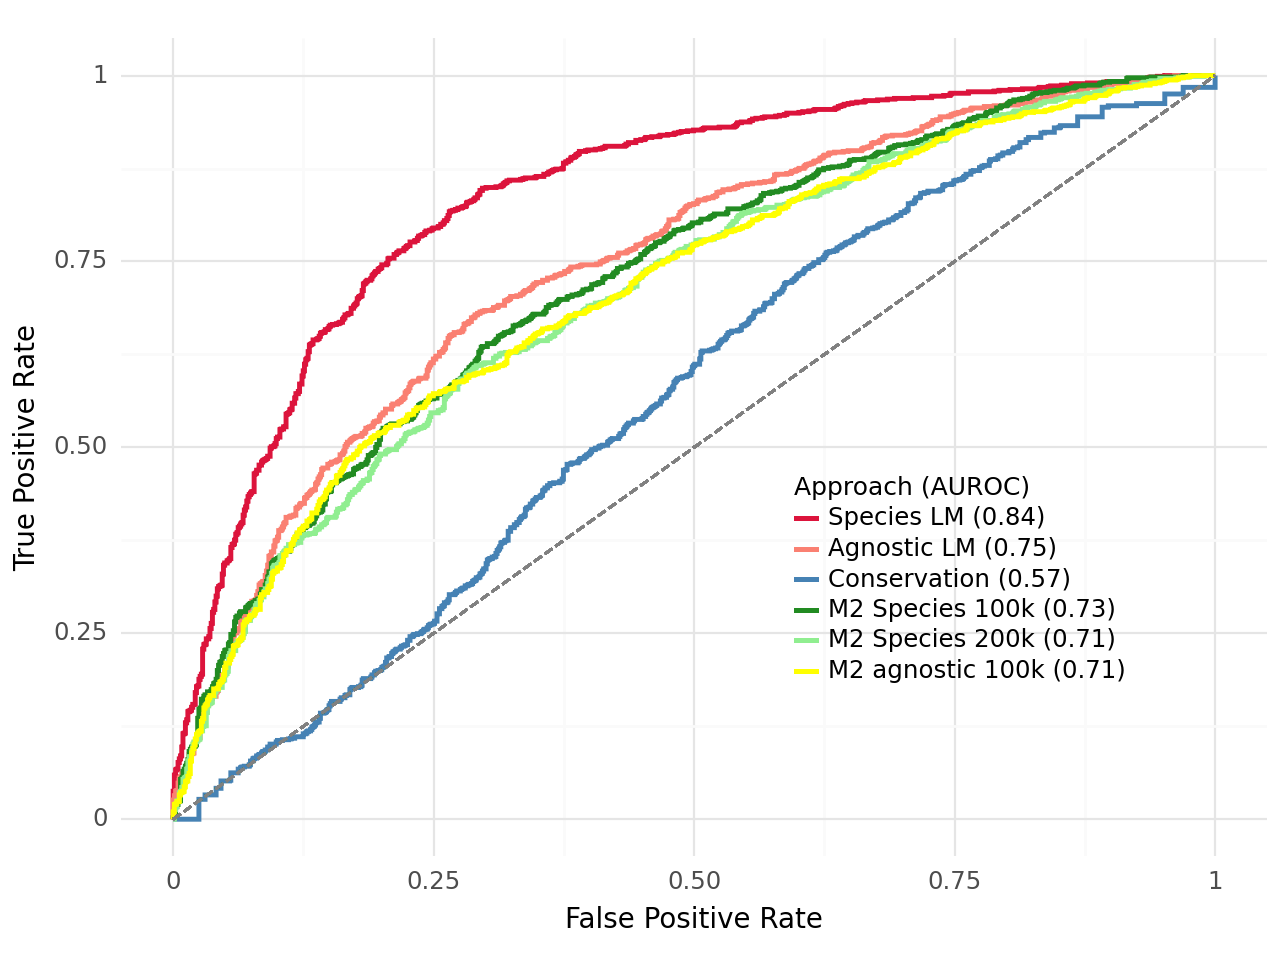

<Figure Size: (640 x 480)>

In [86]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "m2-mixer100k":"M2 Species 100k ({:2.2f})".format(roc_dict["m2-mixer100k"]["roc_auc"]),
    "m2-mixer200k":"M2 Species 200k ({:2.2f})".format(roc_dict["m2-mixer200k"]["roc_auc"]),
    "m2-agnostic":"M2 agnostic 100k ({:2.2f})".format(roc_dict["m2-agnostic"]["roc_auc"])
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "forestgreen", "lightgreen", "yellow"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.75, 0.4), 
            legend_direction='vertical')
)
p.save("outputs/predictions/3utr_whi3_roc" + ".png", width=3.5, height=3.5, dpi=300)

p

### PIN4

In [70]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","m2-mixer100k", "m2-mixer200k", "m2-agnostic","Conservation"]#["BERT-ADN-200k","BERT-ADN-Species-200k","BERT-ADN-Sacch_incl","BERT-ADN-Species-Sacch_incl","Conservation"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site(model, motif = "TTTAATGA"))

In [71]:
utr3_site_roc = pd.concat(utr3_site_dfs)

In [72]:
print(len(utr3_site_roc.query('model == "Conservation"')["within"]))
print(utr3_site_roc.query('model == "Conservation"')["within"].mean())

103
0.7475728155339806


In [73]:
set(utr3_site_roc["model"])

{'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Conservation',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [74]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(utr3_site_roc, "ce", model, label_col="within")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
m2-mixer100k
m2-mixer200k
m2-agnostic
Conservation


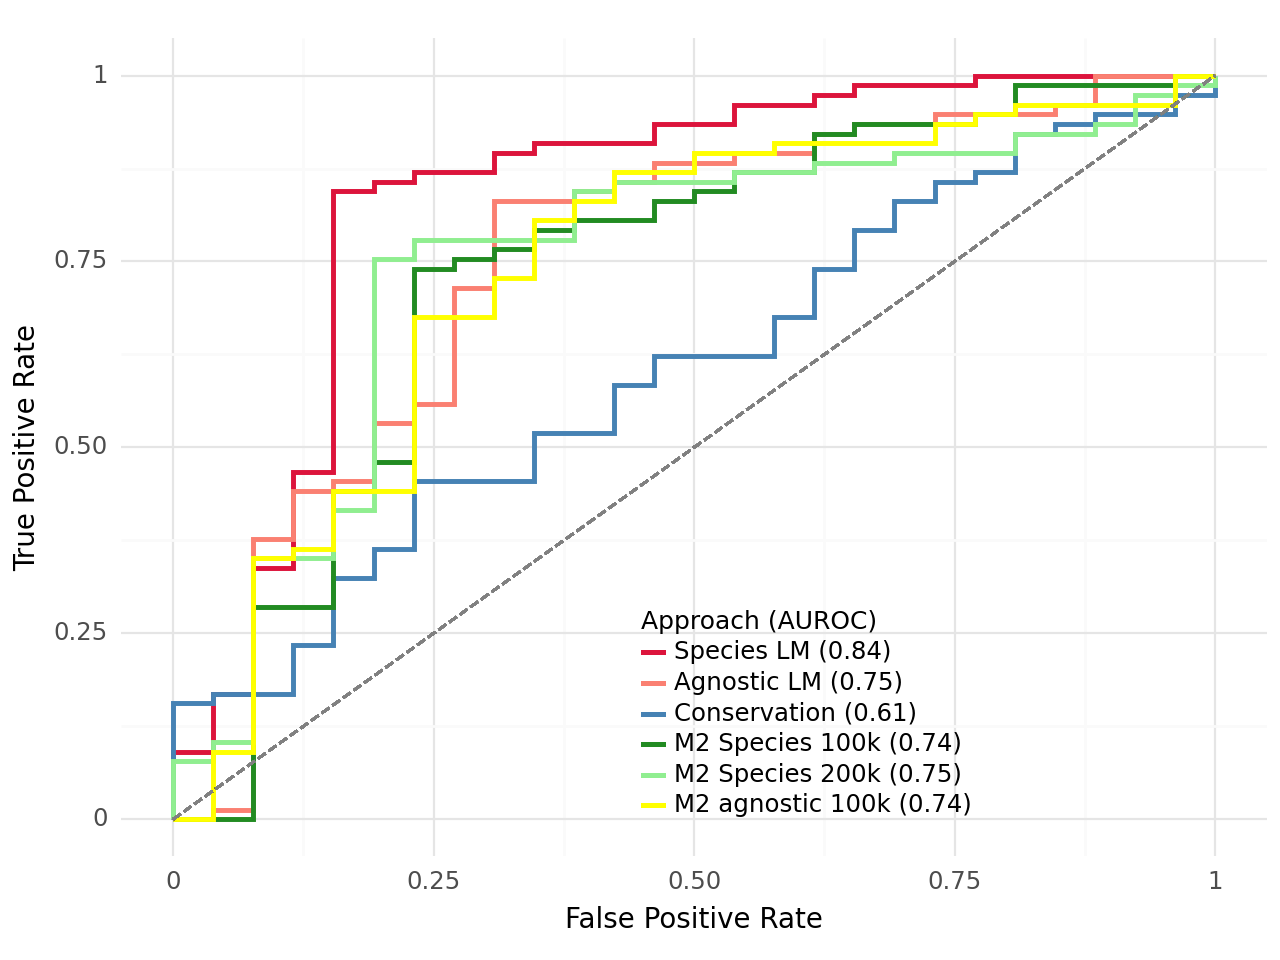

<Figure Size: (640 x 480)>

In [75]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "m2-mixer100k":"M2 Species 100k ({:2.2f})".format(roc_dict["m2-mixer100k"]["roc_auc"]),
    "m2-mixer200k":"M2 Species 200k ({:2.2f})".format(roc_dict["m2-mixer200k"]["roc_auc"]),
    "m2-agnostic":"M2 agnostic 100k ({:2.2f})".format(roc_dict["m2-agnostic"]["roc_auc"])
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "forestgreen", "lightgreen", "yellow"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
p.save("outputs/predictions/3utr_pin4_roc" + ".png", width=4.5, height=4.5, dpi=300)

p

### PUF4

In [83]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","m2-mixer100k", "m2-mixer200k", "m2-agnostic","Conservation"]#["BERT-ADN-200k","BERT-ADN-Species-200k","BERT-ADN-Sacch_incl","BERT-ADN-Species-Sacch_incl","Conservation"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site(model, motif = "TGTA[CT]AATA"))

In [84]:
utr3_site_roc = pd.concat(utr3_site_dfs)

In [85]:
print(len(utr3_site_roc.query('model == "Conservation"')["within"]))
print(utr3_site_roc.query('model == "Conservation"')["within"].mean())

96
0.8229166666666666


In [86]:
set(utr3_site_roc["model"])

{'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Conservation',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [87]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(utr3_site_roc, "ce", model, label_col="within")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
m2-mixer100k
m2-mixer200k
m2-agnostic
Conservation


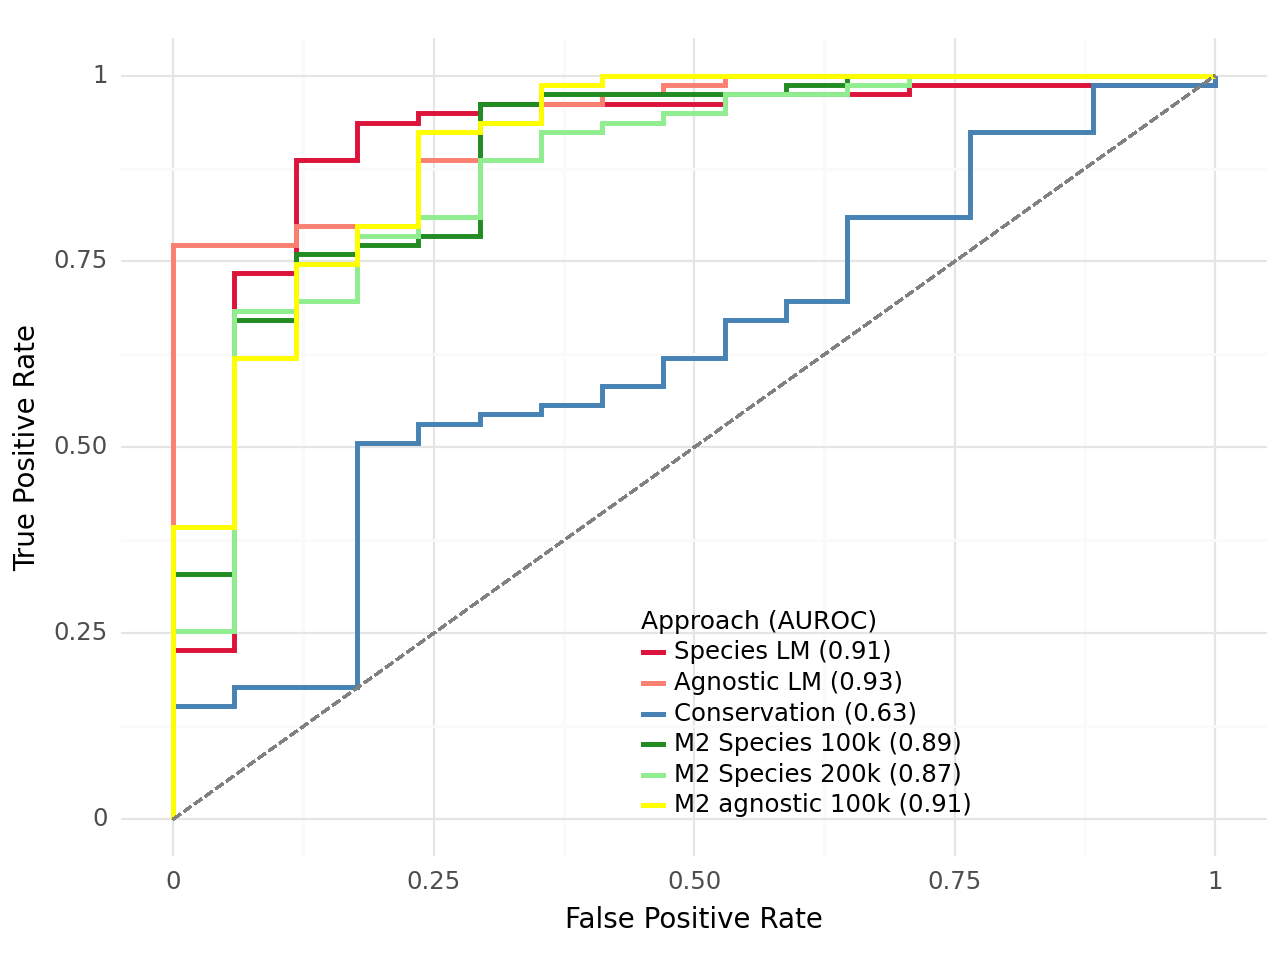

<Figure Size: (640 x 480)>

In [90]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "m2-mixer100k":"M2 Species 100k ({:2.2f})".format(roc_dict["m2-mixer100k"]["roc_auc"]),
    "m2-mixer200k":"M2 Species 200k ({:2.2f})".format(roc_dict["m2-mixer200k"]["roc_auc"]),
    "m2-agnostic":"M2 agnostic 100k ({:2.2f})".format(roc_dict["m2-agnostic"]["roc_auc"])
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "forestgreen", "lightgreen", "yellow"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
p.save("outputs/predictions/3utr_puf4_roc" + ".png", width=4.5, height=4.5, dpi=300)

p

### PRSE

In [91]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","m2-mixer100k", "m2-mixer200k", "m2-agnostic"]#["BERT-ADN-200k","BERT-ADN-Species-200k","BERT-ADN-Sacch_incl","BERT-ADN-Species-Sacch_incl","Conservation"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site(model, motif = "ATATTC"))

In [92]:
utr3_site_roc = pd.concat(utr3_site_dfs)

In [93]:
print(len(utr3_site_roc.query('model == "Conservation"')["within"]))
print(utr3_site_roc.query('model == "Conservation"')["within"].mean())

1024
0.6123046875


In [94]:
set(utr3_site_roc["model"])

{'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Conservation',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [95]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(utr3_site_roc, "ce", model, label_col="within")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
m2-mixer100k
m2-mixer200k
m2-agnostic


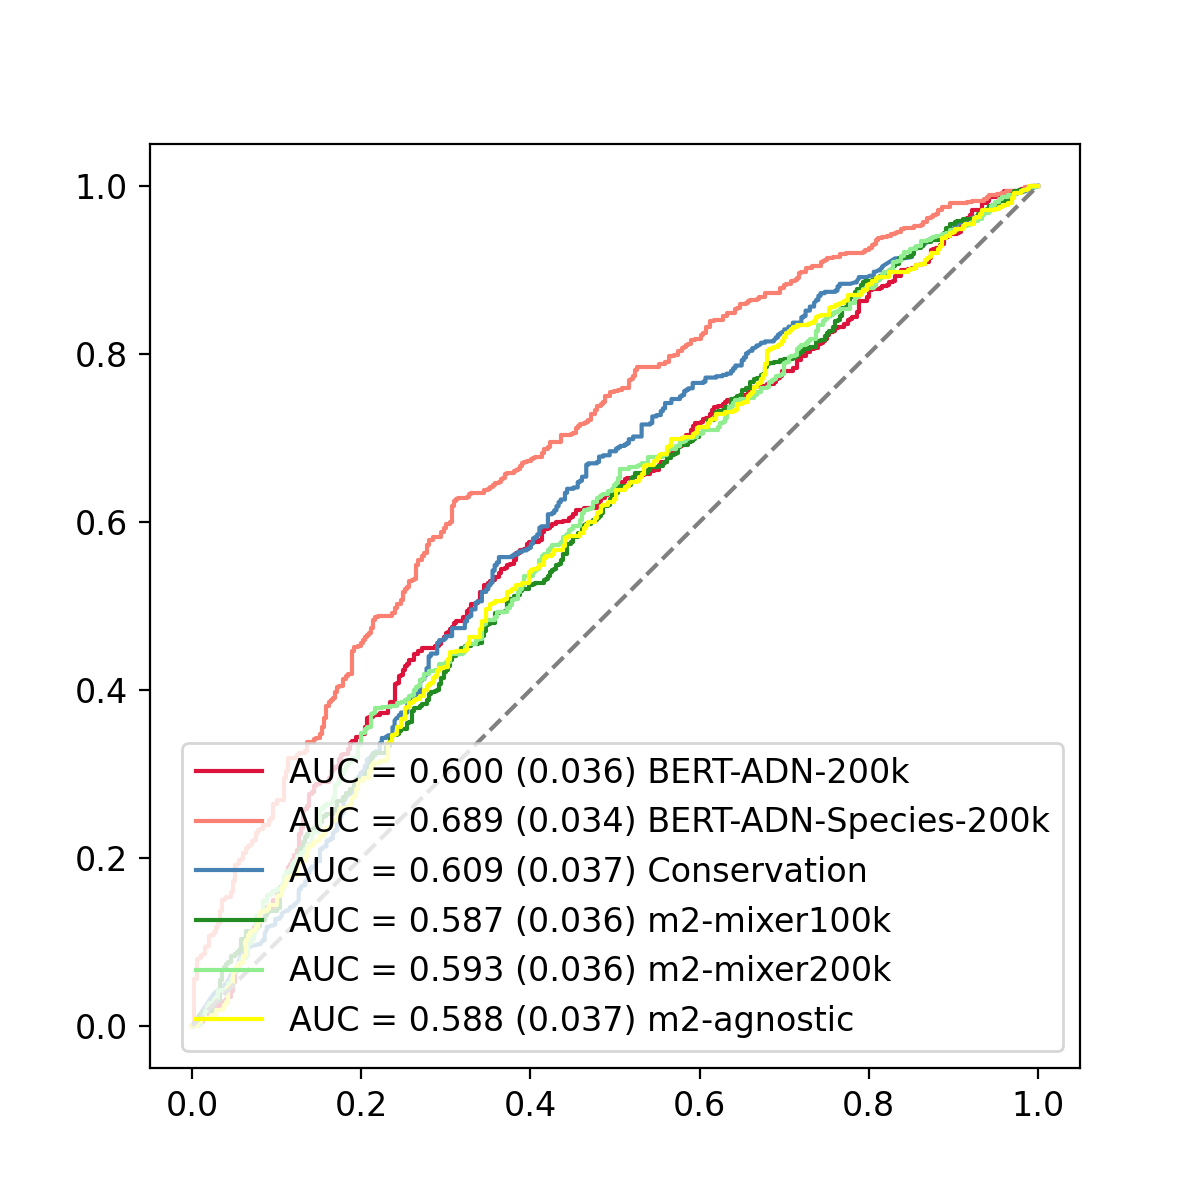

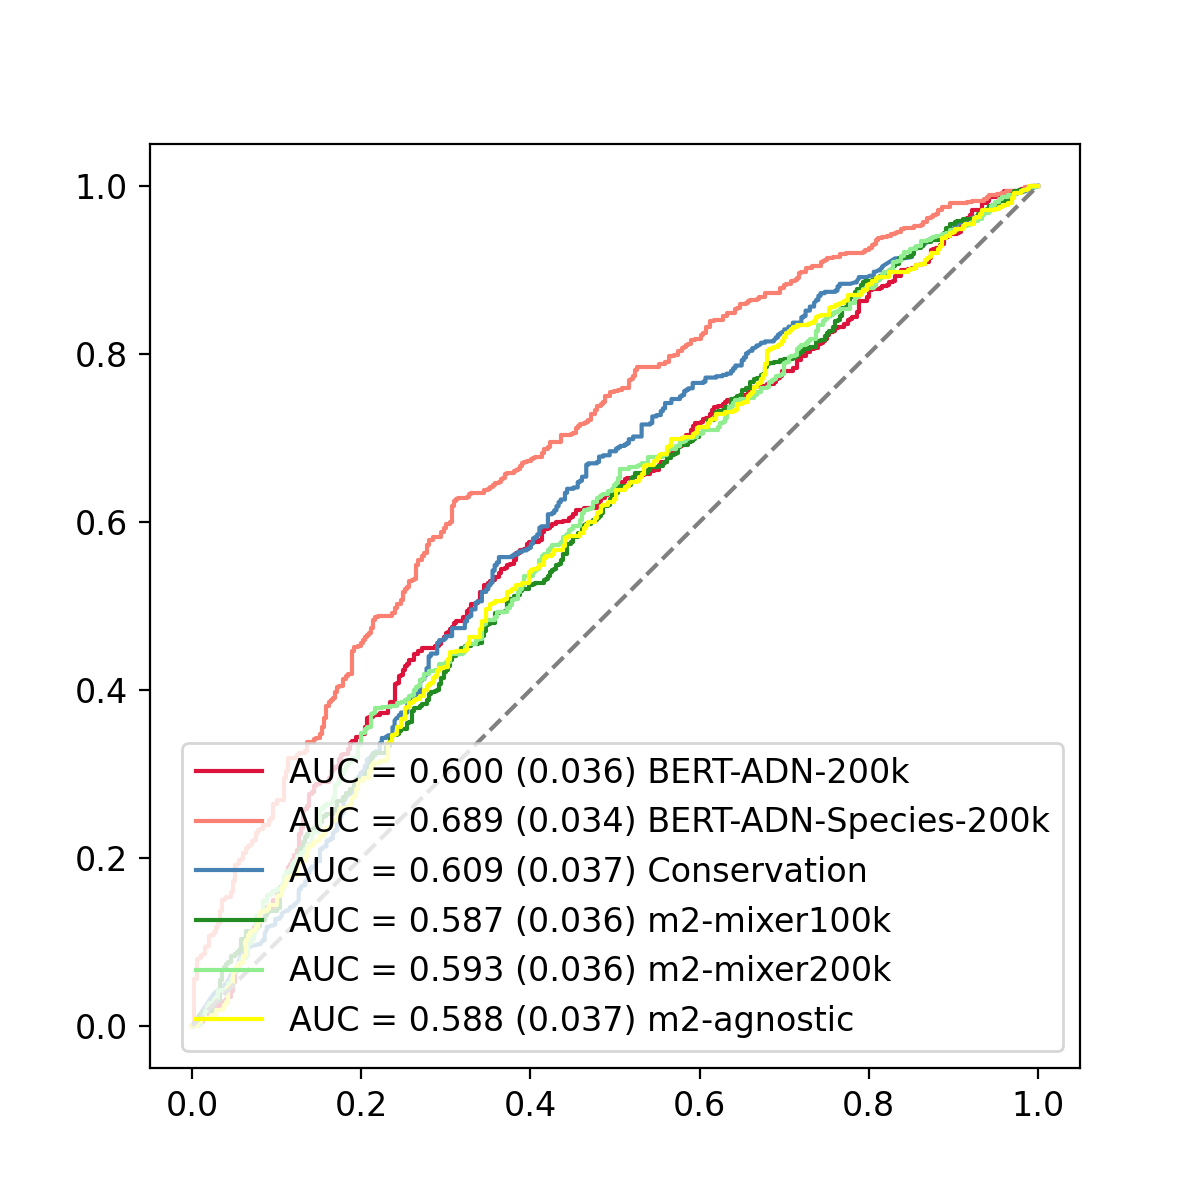

In [96]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
colors = ["crimson","salmon","steelblue", "forestgreen", "lightgreen", "yellow"]#["yellow","purple","green","black","blue","pink"]

for model, color in zip(roc_models, colors):
    ax.plot(roc_dict[model]["fpr"],roc_dict[model]["tpr"], color=color, label="AUC = {:2.3f} ({:2.3f}) {}".format(roc_dict[model]["roc_auc"], 2*np.sqrt(roc_dict[model]["var"]), model))
    #ax.plot(roc_dict[model]["fpr"],roc_dict[model]["tpr"], color=color, label="AUC = {:2.3f} {}".format(roc_dict[model]["roc_auc"], model))
    #ax.plot(roc_dict[model]["rec"],roc_dict[model]["prec"], color=color, label="AUPRC = {:2.2f} {}".format(roc_dict[model]["auprc"], model))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)
fig

### TATA Box (not 3' UTR)

In [58]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","m2-mixer100k","m2-mixer200k", "m2-agnostic"]#["BERT-ADN-200k","BERT-ADN-Species-200k","BERT-ADN-Sacch_incl","BERT-ADN-Species-Sacch_incl","Conservation"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site(model, motif = "TATA[AT]A[AT][AG]"))

In [59]:
utr3_site_roc = pd.concat(utr3_site_dfs)

In [60]:
print(len(utr3_site_roc.query('model == "Conservation"')["within"]))
print(utr3_site_roc.query('model == "Conservation"')["within"].mean())

3691
0.6903278244378217


In [61]:
set(utr3_site_roc["model"])

{'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Conservation',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [62]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(utr3_site_roc, "ce", model, label_col="within")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
m2-mixer100k
m2-mixer200k
m2-agnostic


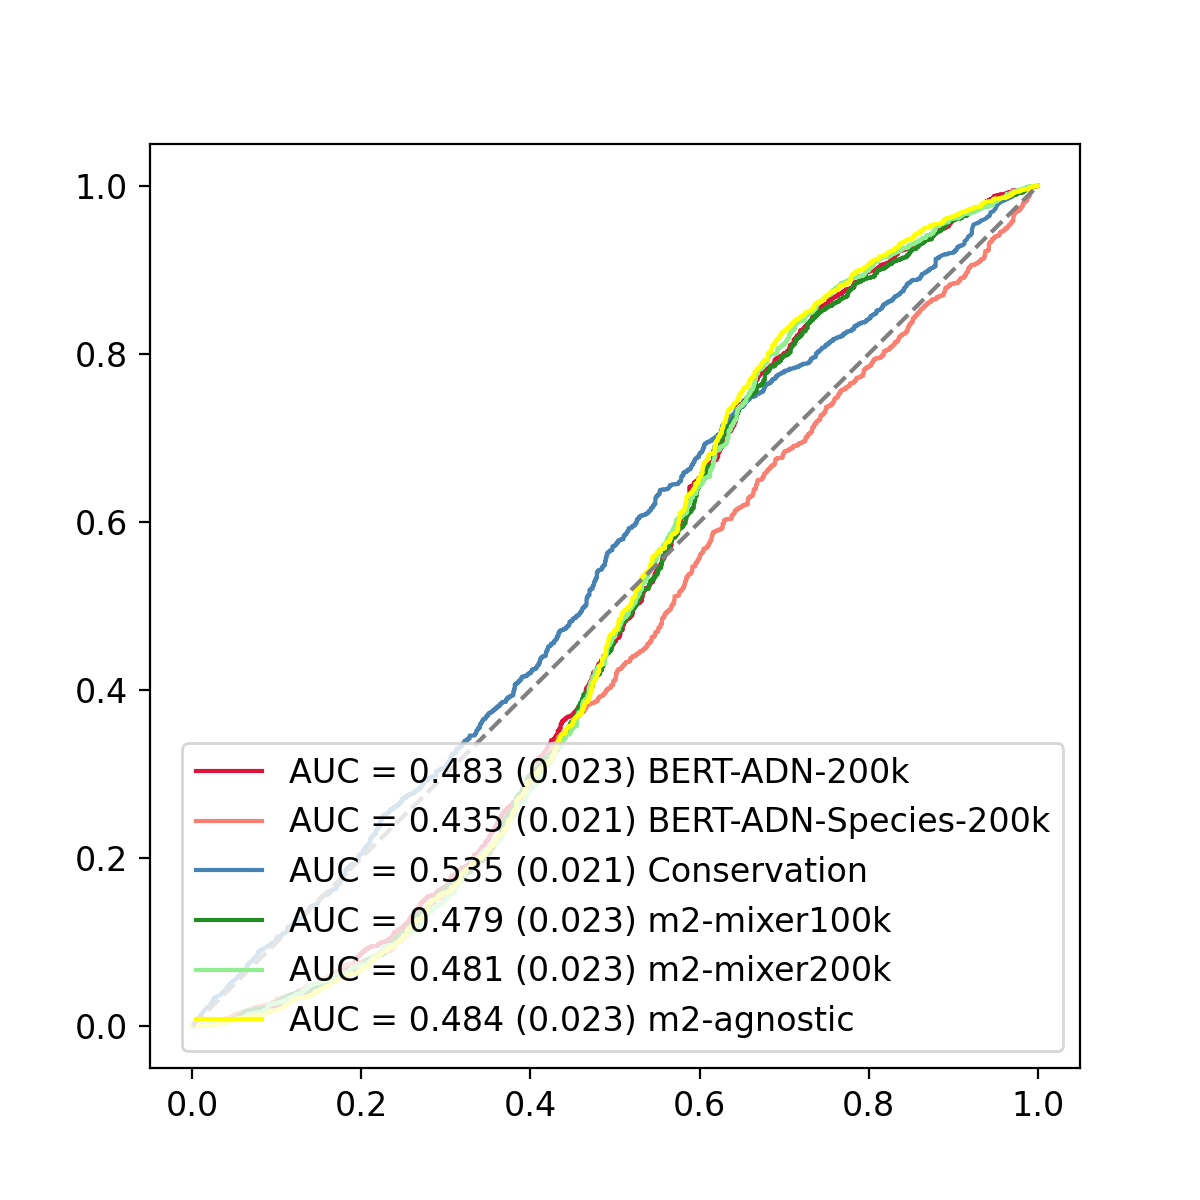

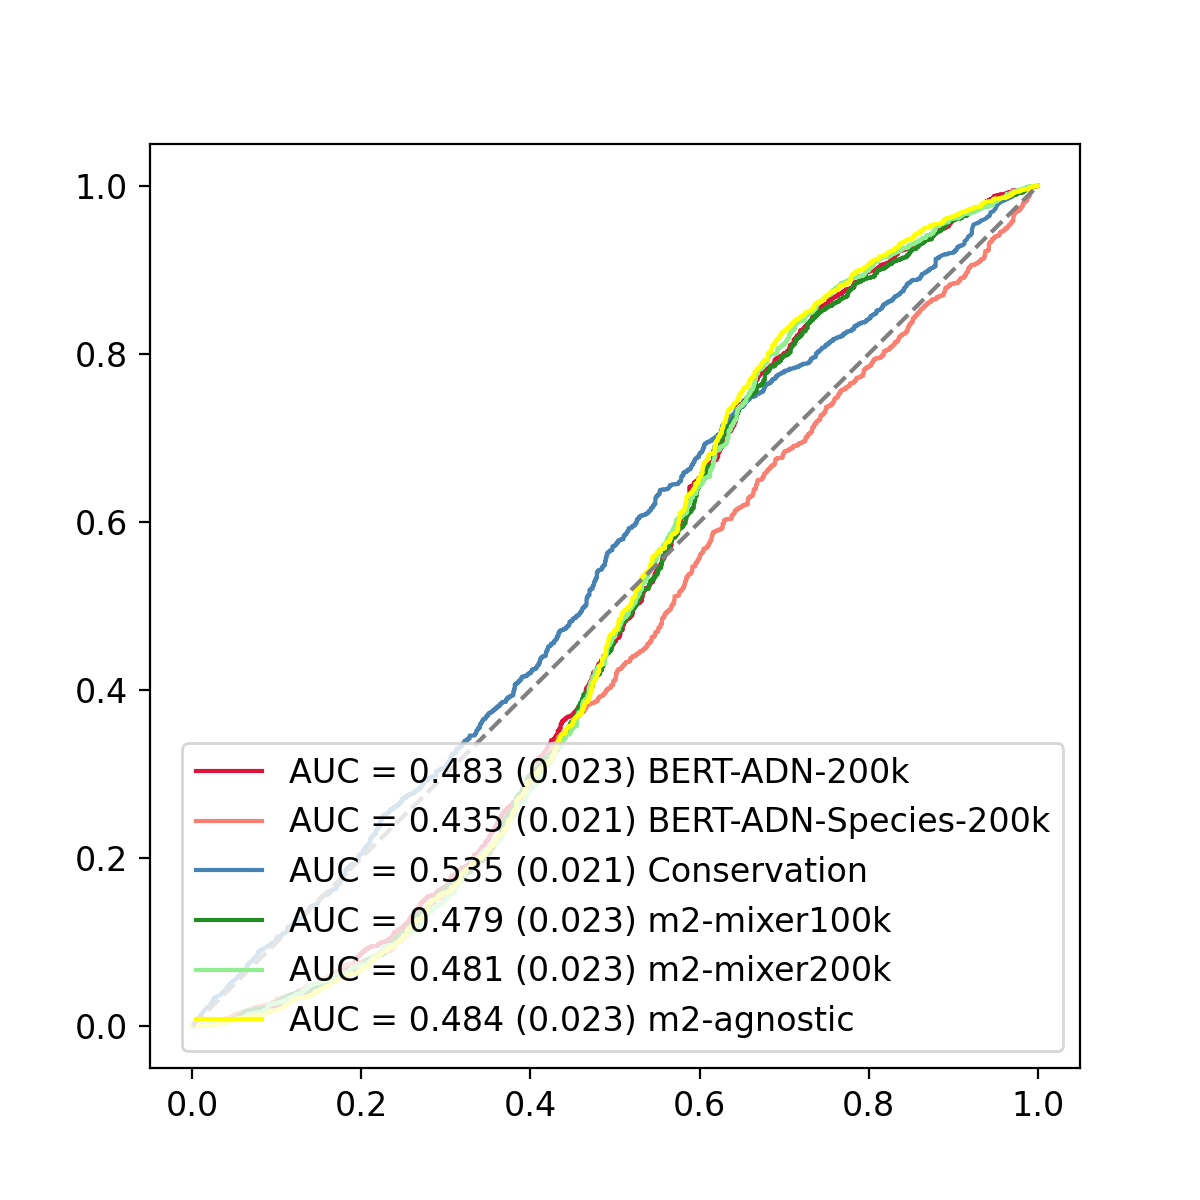

In [63]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
colors = ["crimson","salmon","steelblue", "forestgreen", "lightgreen", "yellow"]#["yellow","purple","green","black","blue","pink"]

for model, color in zip(roc_models, colors):
    ax.plot(roc_dict[model]["fpr"],roc_dict[model]["tpr"], color=color, label="AUC = {:2.3f} ({:2.3f}) {}".format(roc_dict[model]["roc_auc"], 2*np.sqrt(roc_dict[model]["var"]), model))
    #ax.plot(roc_dict[model]["fpr"],roc_dict[model]["tpr"], color=color, label="AUC = {:2.3f} {}".format(roc_dict[model]["roc_auc"], model))
    #ax.plot(roc_dict[model]["rec"],roc_dict[model]["prec"], color=color, label="AUPRC = {:2.2f} {}".format(roc_dict[model]["auprc"], model))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)
fig

### REB1 (not 3' UTR)

In [15]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation", "m2-mixer100k", "m2-mixer200k", "m2-agnostic"]#["BERT-ADN-200k","BERT-ADN-Species-200k","BERT-ADN-Sacch_incl","BERT-ADN-Species-Sacch_incl","Conservation"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site(model, motif = "CGGGTAA"))

In [16]:
utr3_site_roc = pd.concat(utr3_site_dfs)

In [17]:
print(len(utr3_site_roc.query('model == "Conservation"')["within"]))
print(utr3_site_roc.query('model == "Conservation"')["within"].mean())

68
0.20588235294117646


In [18]:
set(utr3_site_roc["model"])

{'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Conservation',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [19]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(utr3_site_roc, "ce", model, label_col="within")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
m2-mixer100k
m2-mixer200k
m2-agnostic


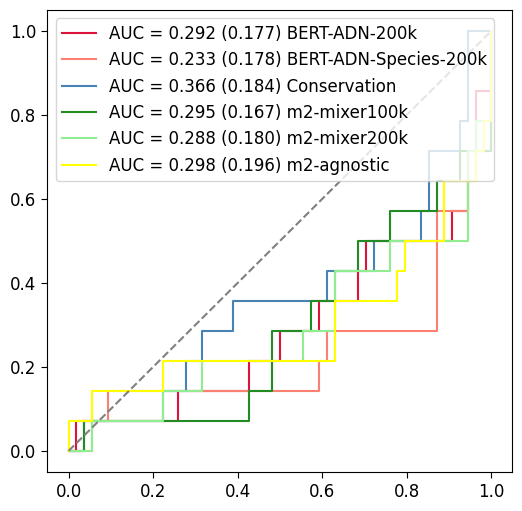

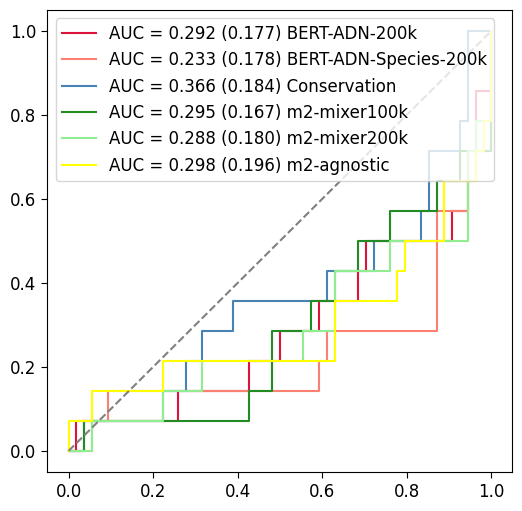

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
colors = ["crimson","salmon","steelblue", "forestgreen", "lightgreen", "yellow"]#["yellow","purple","green","black","blue","pink"]

for model, color in zip(roc_models, colors):
    ax.plot(roc_dict[model]["fpr"],roc_dict[model]["tpr"], color=color, label="AUC = {:2.3f} ({:2.3f}) {}".format(roc_dict[model]["roc_auc"], 2*np.sqrt(roc_dict[model]["var"]), model))
    #ax.plot(roc_dict[model]["fpr"],roc_dict[model]["tpr"], color=color, label="AUC = {:2.3f} {}".format(roc_dict[model]["roc_auc"], model))
    #ax.plot(roc_dict[model]["rec"],roc_dict[model]["prec"], color=color, label="AUPRC = {:2.2f} {}".format(roc_dict[model]["auprc"], model))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=2)
fig.savefig('outputs/predictions/3utr_reb1_roc.png')

fig

### CBF1 (not 3' UTR)

In [22]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation", "m2-mixer100k", "m2-mixer200k", "m2-agnostic"]#["BERT-ADN-200k","BERT-ADN-Species-200k","BERT-ADN-Sacch_incl","BERT-ADN-Species-Sacch_incl","Conservation"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site(model, motif = "CACGTG"))

In [23]:
utr3_site_roc = pd.concat(utr3_site_dfs)

In [24]:
print(len(utr3_site_roc.query('model == "Conservation"')["within"]))
print(utr3_site_roc.query('model == "Conservation"')["within"].mean())

103
0.3592233009708738


In [25]:
set(utr3_site_roc["model"])

{'BERT-ADN-200k',
 'BERT-ADN-Species-200k',
 'Conservation',
 'm2-agnostic',
 'm2-mixer100k',
 'm2-mixer200k'}

In [26]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(utr3_site_roc, "ce", model, label_col="within")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
m2-mixer100k
m2-mixer200k
m2-agnostic


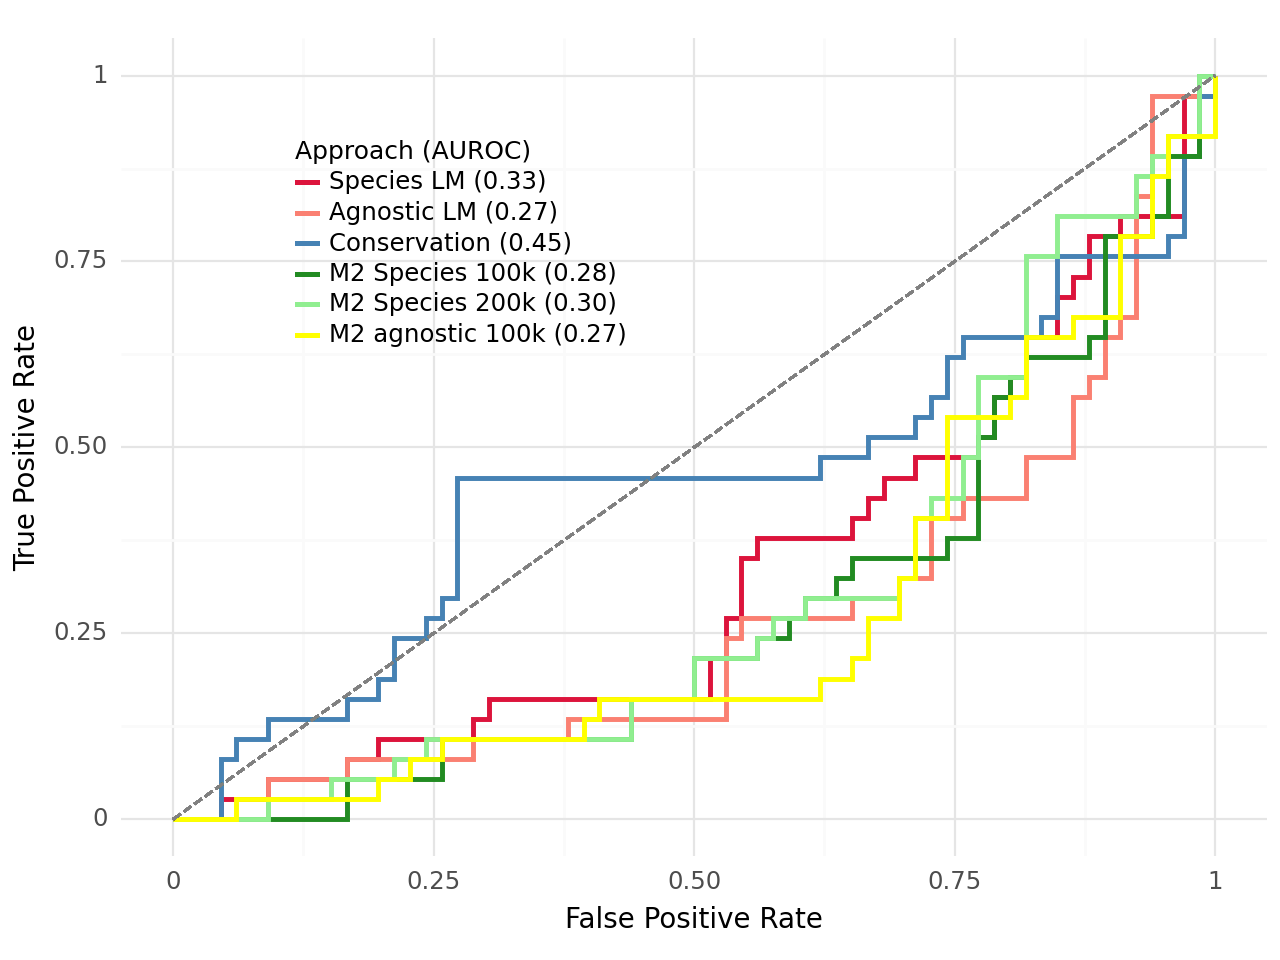

<Figure Size: (640 x 480)>

In [28]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "m2-mixer100k":"M2 Species 100k ({:2.2f})".format(roc_dict["m2-mixer100k"]["roc_auc"]),
    "m2-mixer200k":"M2 Species 200k ({:2.2f})".format(roc_dict["m2-mixer200k"]["roc_auc"]),
    "m2-agnostic":"M2 agnostic 100k ({:2.2f})".format(roc_dict["m2-agnostic"]["roc_auc"])
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "forestgreen", "lightgreen", "yellow"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.36,0.75), 
            legend_direction='vertical')
)
p.save("outputs/predictions/3utr_cbf1_roc" + ".png", width=4.5, height=4.5, dpi=300)

p

## Reconstruction as function of distance to UTR3 End

In [34]:
def locate_utr3_bind_site_rel_end(model, dataset = dataset_matched, motif = "TGTAAATA", puf3_binding=False):
    if model == "Conservation":
        path = project_path+"outputs/scer_conservation_withstop_downstream_fixedlen/"
    else:
        path = paths_dict[model]
    # get prbs
    prbs = torch.load(path + "prbs.pt")[:,:4]
    targets = torch.load(path + "masked_targets.pt")
    # get sequences and find matches to consensus motif
    match_rows = dataset["three_prime_seq"].apply(lambda seq: overlapping_matcher(motif, seq))
    if puf3_binding:
        # extract genes with binding evidence
        puf3_bind_df = pd.read_csv(project_path + "data/Binding/puf3_clip_targets.tsv",sep="\t")
        puf3_binding_genes = set(puf3_bind_df["Gene"])
    out_rows = []
    for row,data_row in zip(match_rows,[x[1] for x in dataset.iterrows()]):
        pos = data_row["concat_start"]
        gene = data_row["gene_id"]
        for match in row:
            start = match.span(0)[0]
            end = match.span(0)[1]
            dist_to_stop = start
            # get distance to the annotated 3' UTR
            dist_to_end = end - data_row["rel_end"]
            # get metrics
            match_pos = torch.tensor(list(range(pos+start,pos+end)))
            if model == "Conservation":
                metrics = get_conservation_for_motif_site(prbs, targets, match_pos, motif)
            else:
                metrics = get_metrics_for_motif_site(prbs, targets, match_pos, motif)
            # add metadata
            metrics["model"] = model
            metrics["distance_to_stop"] = dist_to_stop
            metrics["distance_to_end"] = dist_to_end
            metrics["ce"] = metrics["cross_entropy_unambig"]
            if puf3_binding:
                metrics["binding"] = gene in puf3_binding_genes
            out_rows.append(metrics)
    return pd.DataFrame(out_rows)

### PUF3

In [35]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation", "m2-mixer100k", "m2-mixer200k", "m2-agnostic"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site_rel_end(model,puf3_binding=True))

utr3_sites = pd.concat(utr3_site_dfs)

In [36]:
# add a grouping to the dataframe

def grouping(model):
    group1 = model.isin(['BERT-ADN-200k', 'm2-mixer200k'])
    group2 = model == 'BERT-ADN-Species-200k'
    return group1 * 1 + group2 * 2

def add_grouping(df):
    df_m2_group2 = df[df['model'].isin(['m2-mixer200k'])].copy()
    df_m2_group2['group'] = 2 
    df_groups = df.assign(group=lambda x: grouping(x.model))
    return pd.concat([df_m2_group2, df_groups])
    
df_groups = add_grouping(utr3_sites)

from IPython.core.display import display


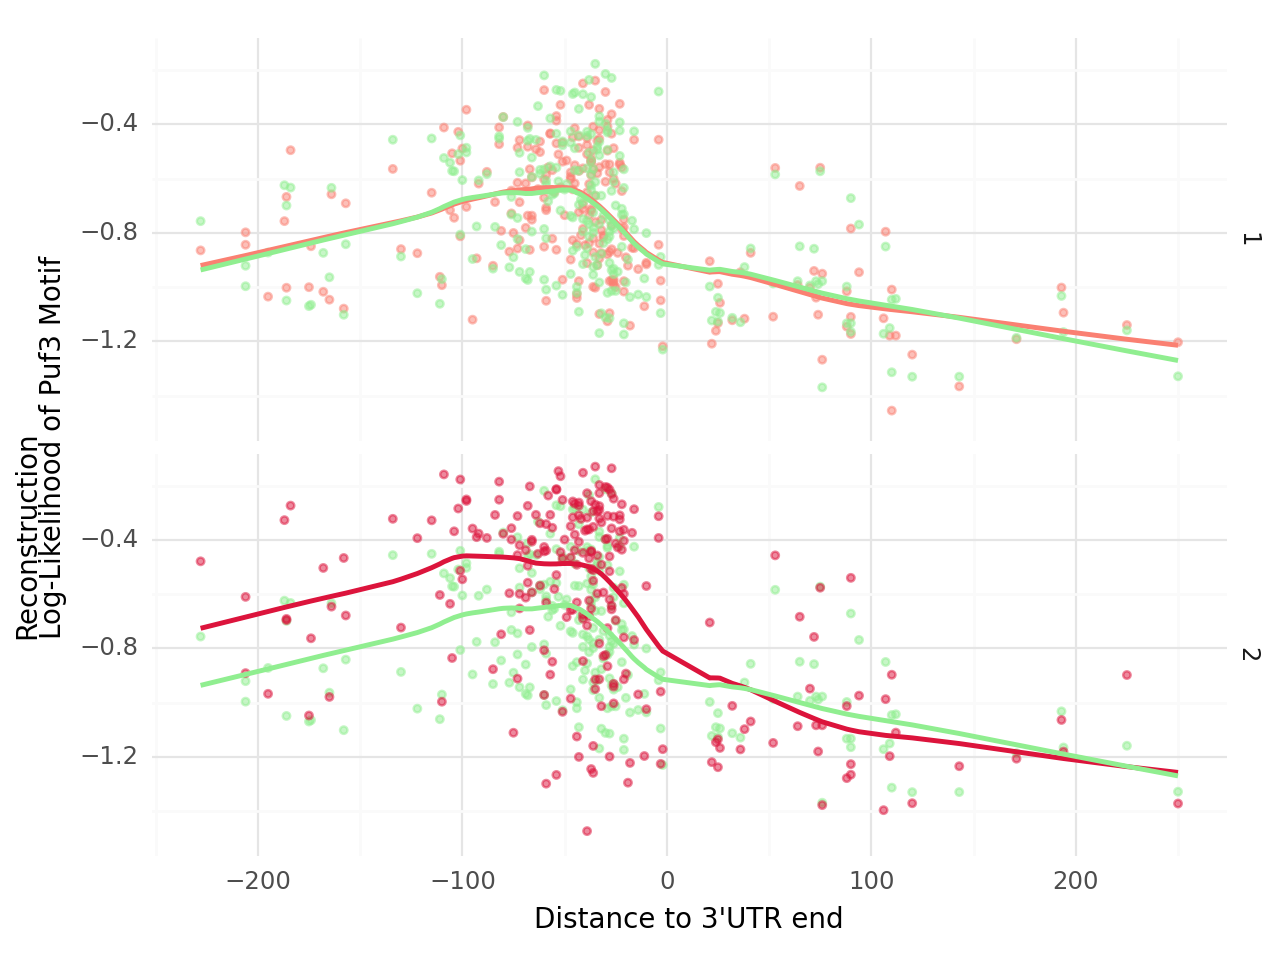

<Figure Size: (640 x 480)>

In [32]:
import patchworklib as pw

p = (p9.ggplot(data=df_groups.query('model == "BERT-ADN-200k" or model == "BERT-ADN-Species-200k" or model == "m2-mixer200k"'), 
           mapping=p9.aes(x="distance_to_end",y="ce", color="model"))
 + p9.geom_point(size=1, alpha = 0.5)
 + p9.coord_cartesian(ylim=(-1.5,-0.15))
 + p9.geom_smooth(mapping=p9.aes(color="model"), method="lowess", span=0.6)  
 + p9.scale_colour_manual(["salmon","crimson", "lightgreen", "forestgreen"])
 + p9.labs(x="Distance to 3'UTR end",y="Reconstruction\nLog-Likelihood of Puf3 Motif")
 + p9.theme_minimal()
 + p9.facet_grid("group ~ . ")
 + p9.theme(legend_text = p9.element_text(size=9),
        axis_title=p9.element_text(size=10),
        legend_position='none',
        legend_direction='vertical'
         )
)

p.save("outputs/predictions/Puf3_distance" + ".png", width=4.0, height=4.0, dpi=300)

p

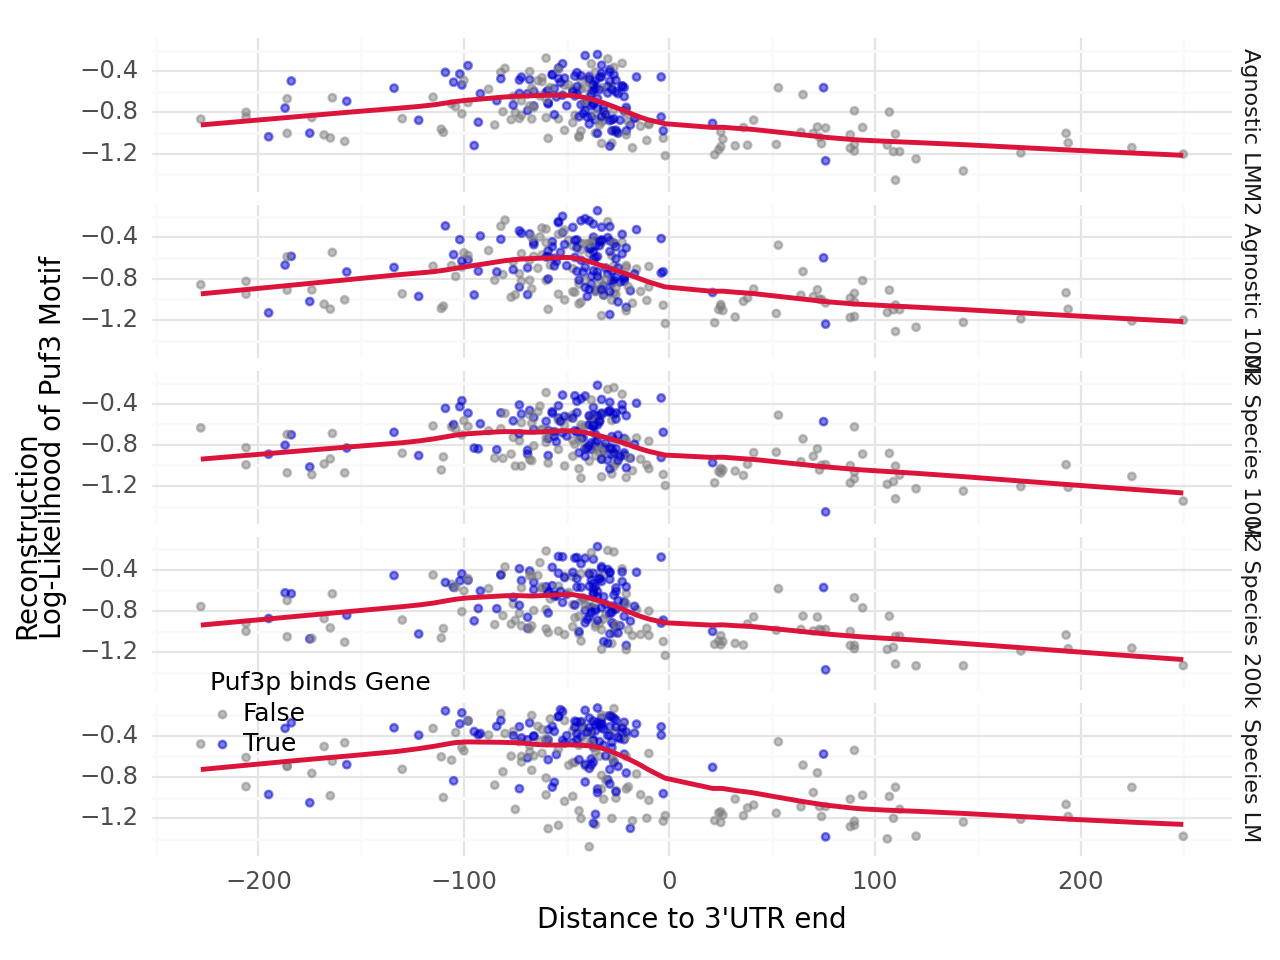

<Figure Size: (640 x 480)>

In [38]:
name_dict = {
    "BERT-ADN-Species-200k": "Vanilla Species LM",
    "BERT-ADN-200k": "Vanilla Agnostic LM",
    "Conservation": "Conservation",
    "m2-mixer100k": "M2 Species 100k",
    "m2-mixer200k": "M2 Species 200k",
    "m2-agnostic": "M2 Agnostic 100k"
}


utr3_sites['model'] = utr3_sites['model'].replace(name_dict)

p = (p9.ggplot(data=utr3_sites.query('model == "Species LM" or model == "Agnostic LM" or model == "M2 Species 200k" or model =="M2 Species 100k" or model == "M2 Agnostic 100k"'), 
           mapping=p9.aes(x="distance_to_end",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.5)
 + p9.coord_cartesian(ylim=(-1.5,-0.15))
 + p9.scale_color_manual(values=["grey","mediumblue"])
 + p9.geom_smooth(method="lowess", color="crimson", span = 0.6)
 + p9.labs(x="Distance to 3'UTR end",y="Reconstruction\nLog-Likelihood of Puf3 Motif",
          color="Puf3p binds Gene")
 + p9.theme_minimal()
 + p9.facet_grid("model ~ .", space="free")
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            legend_position=(0.25,0.26), 
            legend_direction='vertical',
        axis_title=p9.element_text(size=10),
        strip_text=p9.element_text(size=8)
    )
)

p.save("outputs/predictions/Puf3_distance_grid" + ".png", width=4.0, height=8.0, dpi=300)

p

In [55]:
utr3_sites

mean_target_prb  accuracy  mean_target_prb_unambig  \
0           0.343622     0.625                 0.343622   
1           0.288115     0.375                 0.288115   
2           0.500464     1.000                 0.500464   
3           0.461319     0.750                 0.461319   
4           0.387493     0.625                 0.387493   
..               ...       ...                      ...   
98          0.256566     0.125                 0.256566   
99          0.524380     0.625                 0.524380   
100         0.444871     0.625                 0.444871   
101         0.265713     0.375                 0.265713   
102         0.431982     0.875                 0.431982   

     cross_entropy_unambig  accuracy_unambig  \
0                -1.096991             0.625   
1                -1.380299             0.375   
2                -0.705097             1.000   
3                -0.971349             0.750   
4                -0.988765             0.625   
..                     ...               ...   
98               -1.414573             0.125   
99               -0.713437             0.625   
100              -0.949795             0.625   
101              -1.350888             0.375   
102              -0.873277             0.875   

                                             prbs_area  \
0    [[tensor(0.2034, dtype=torch.float64), tensor(...   
1    [[tensor(0.4003, dtype=torch.float64), tensor(...   
2    [[tensor(0.3191, dtype=torch.float64), tensor(...   
3    [[tensor(0.6322, dtype=torch.float64), tensor(...   
4    [[tensor(0.3453, dtype=torch.float64), tensor(...   
..                                                 ...   
98   [[tensor(0.3182), tensor(0.1481), tensor(0.218...   
99   [[tensor(0.2308), tensor(0.0425), tensor(0.035...   
100  [[tensor(0.1596), tensor(0.2698), tensor(0.047...   
101  [[tensor(0.3214), tensor(0.1568), tensor(0.180...   
102  [[tensor(0.5072), tensor(0.1375), tensor(0.117...   

                                          targets_area             model  \
0    [tensor(1), tensor(0), tensor(0), tensor(0), t...       Agnostic LM   
1    [tensor(3), tensor(1), tensor(1), tensor(3), t...       Agnostic LM   
2    [tensor(3), tensor(2), tensor(3), tensor(1), t...       Agnostic LM   
3    [tensor(2), tensor(0), tensor(0), tensor(2), t...       Agnostic LM   
4    [tensor(1), tensor(3), tensor(0), tensor(0), t...       Agnostic LM   
..                                                 ...               ...   
98   [tensor(0), tensor(1), tensor(3), tensor(3), t...  M2 Agnostic 100k   
99   [tensor(3), tensor(0), tensor(0), tensor(3), t...  M2 Agnostic 100k   
100  [tensor(3), tensor(3), tensor(3), tensor(3), t...  M2 Agnostic 100k   
101  [tensor(0), tensor(2), tensor(0), tensor(0), t...  M2 Agnostic 100k   
102  [tensor(3), tensor(0), tensor(3), tensor(2), t...  M2 Agnostic 100k   

     distance_to_stop  distance_to_end        ce  
0                  47              -74 -1.096991  
1                  91              -38 -1.380299  
2                  41             -100 -0.705097  
3                 135              -47 -0.971349  
4                 112              -38 -0.988765  
..                ...              ...       ...  
98                150              -17 -1.414573  
99                106               -5 -0.713437  
100                73             -150 -0.949795  
101               201              -91 -1.350888  
102               101              -32 -0.873277  

[618 rows x 11 columns]

### WHI3

In [65]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation", "m2-mixer100k", "m2-mixer200k", "m2-agnostic"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site_rel_end(model, motif="TGCAT"))

utr3_sites = pd.concat(utr3_site_dfs)

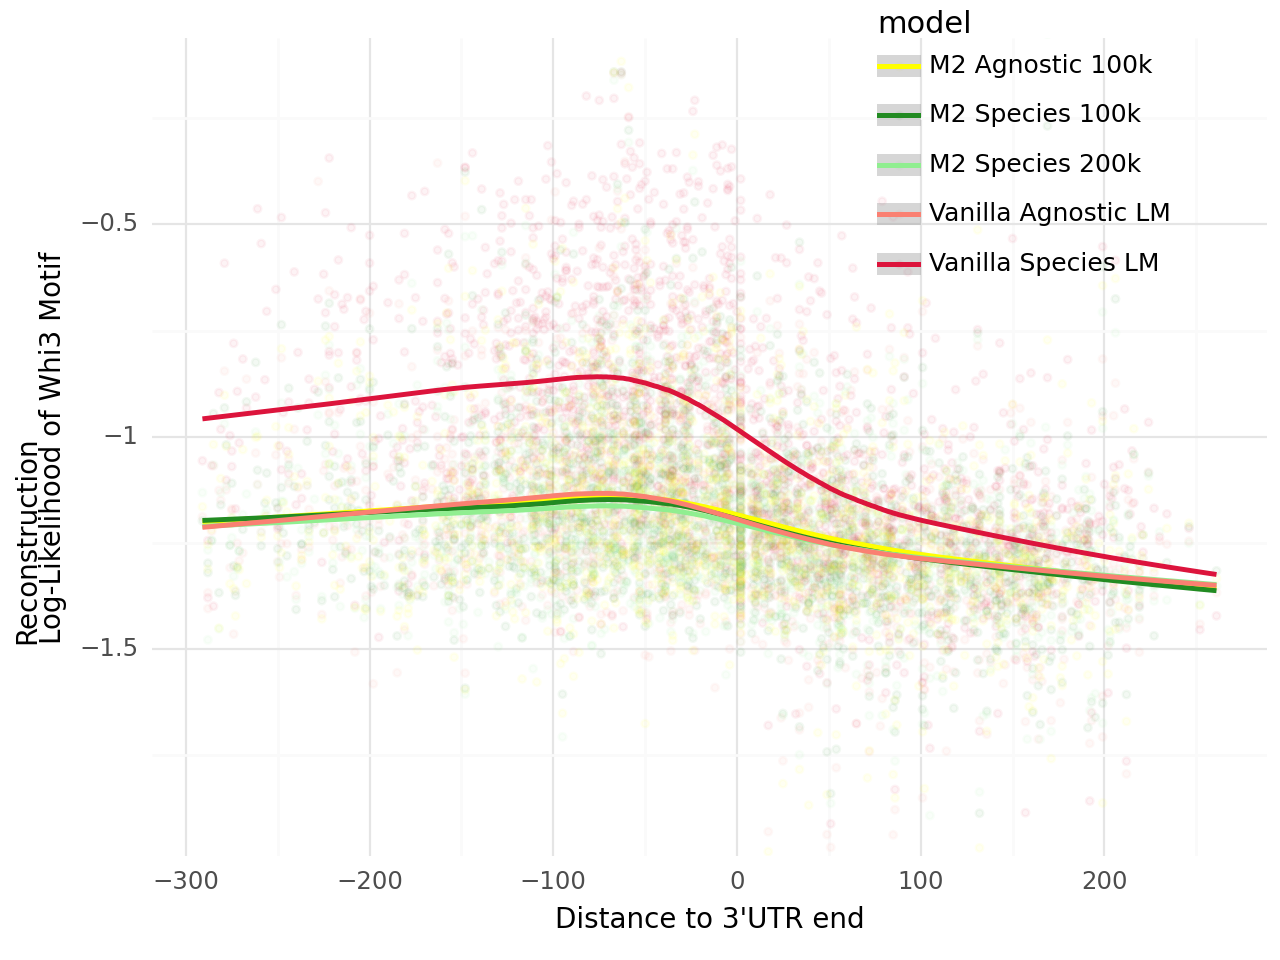

<Figure Size: (640 x 480)>

In [67]:
name_dict = {
    "BERT-ADN-Species-200k": "Vanilla Species LM",
    "BERT-ADN-200k": "Vanilla Agnostic LM",
    "Conservation": "Conservation",
    "m2-mixer100k": "M2 Species 100k",
    "m2-mixer200k": "M2 Species 200k",
    "m2-agnostic": "M2 Agnostic 100k"
}

utr3_sites['model'] = utr3_sites['model'].replace(name_dict)

p = (p9.ggplot(data=utr3_sites.query('model == "Vanilla Species LM" or model == "Vanilla Agnostic LM" or model == "M2 Species 200k" or model =="M2 Species 100k" or model == "M2 Agnostic 100k"'), 
               mapping=p9.aes(x="distance_to_end",y="ce", color="model"))

 + p9.geom_point(size=1, alpha = 0.05, raster=True)
 + p9.coord_cartesian(ylim=(-1.9,-0.15))
 + p9.geom_smooth(method="lowess", span = 0.6, mapping=p9.aes(color="model"))    
 + p9.labs(x="Distance to 3'UTR end",y="Reconstruction\nLog-Likelihood of Whi3 Motif")
 + p9.theme_minimal()
 + p9.scale_colour_manual(["yellow","forestgreen", "lightgreen","salmon", "crimson"])
 + p9.theme(legend_text = p9.element_text(size=9),
        legend_position=(0.8, 0.85), 
        legend_direction='vertical',
        axis_title=p9.element_text(size=10),)
)

p.save("outputs/predictions/3utr_whi3_distance_all" + ".png", width=4.0, height=3.0, dpi=300)

p

### PIN4

In [69]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation", "m2-mixer100k", "m2-mixer200k", "m2-agnostic"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site_rel_end(model, motif= "TTTAATGA"))

utr3_sites = pd.concat(utr3_site_dfs)

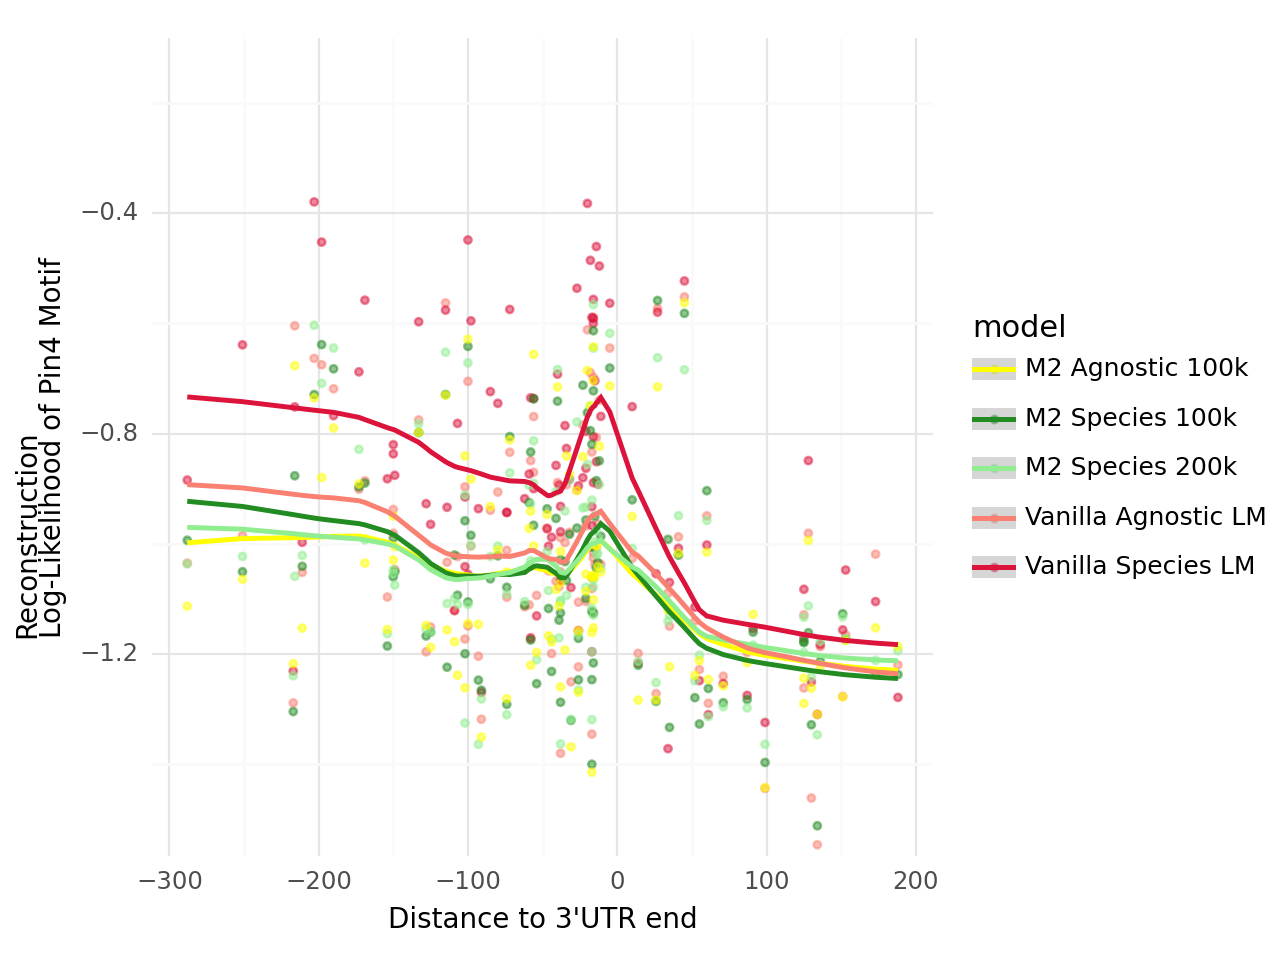

<Figure Size: (640 x 480)>

In [70]:
name_dict = {
    "BERT-ADN-Species-200k": "Vanilla Species LM",
    "BERT-ADN-200k": "Vanilla Agnostic LM",
    "Conservation": "Conservation",
    "m2-mixer100k": "M2 Species 100k",
    "m2-mixer200k": "M2 Species 200k",
    "m2-agnostic": "M2 Agnostic 100k"
}

utr3_sites['model'] = utr3_sites['model'].replace(name_dict)

p = (p9.ggplot(data=utr3_sites.query('model == "Vanilla Species LM" or model == "Vanilla Agnostic LM" or model == "M2 Species 200k" or model =="M2 Species 100k" or model == "M2 Agnostic 100k"'), 
               mapping=p9.aes(x="distance_to_end",y="ce", color="model"))
 + p9.geom_point(size=1, alpha = 0.5)
 + p9.coord_cartesian(ylim=(-1.5,-0.15))
 + p9.geom_smooth(mapping=p9.aes(color="model"),method="lowess",span = 0.4)    
 + p9.labs(x="Distance to 3'UTR end",y="Reconstruction\nLog-Likelihood of Pin4 Motif")
 + p9.scale_colour_manual(["yellow","forestgreen", "lightgreen","salmon", "crimson"])
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
        axis_title=p9.element_text(size=10),)
)

p.save("outputs/predictions/3utr_pin4_distance" + ".png", width=6.0, height=4.5, dpi=300)

p

### PUF4

In [75]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation", "m2-mixer200k", "m2-agnostic", "m2-mixer100k"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site_rel_end(model, motif= "TGTA[CT]AATA"))

utr3_sites = pd.concat(utr3_site_dfs)

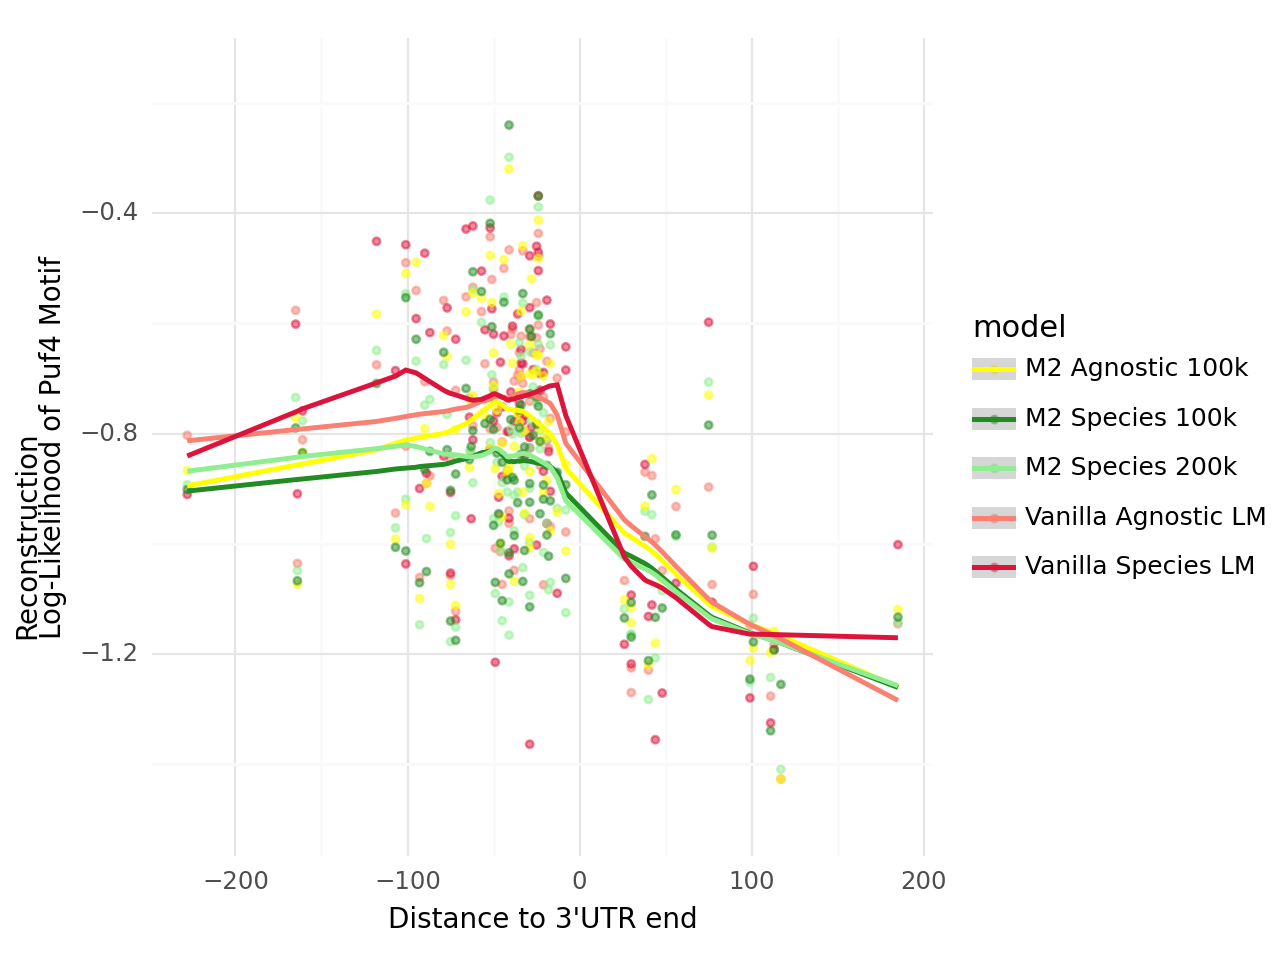

<Figure Size: (640 x 480)>

In [76]:
#grouped = add_grouping(utr3_sites)
name_dict = {
    "BERT-ADN-Species-200k": "Vanilla Species LM",
    "BERT-ADN-200k": "Vanilla Agnostic LM",
    "Conservation": "Conservation",
    "m2-mixer100k": "M2 Species 100k",
    "m2-mixer200k": "M2 Species 200k",
    "m2-agnostic": "M2 Agnostic 100k"
}

utr3_sites['model'] = utr3_sites['model'].replace(name_dict)

p = (p9.ggplot(data=utr3_sites.query('model == "Vanilla Species LM" or model == "Vanilla Agnostic LM" or model == "M2 Species 200k" or model =="M2 Species 100k" or model == "M2 Agnostic 100k"'), 
               mapping=p9.aes(x="distance_to_end",y="ce", color="model"))
 + p9.geom_point(size=1, alpha = 0.5)
 + p9.coord_cartesian(ylim=(-1.5,-0.15))
 + p9.geom_smooth(mapping=p9.aes(color="model"), method="lowess", span = 0.6)
 + p9.labs(x="Distance to 3'UTR end",y="Reconstruction\nLog-Likelihood of Puf4 Motif")
 + p9.scale_colour_manual(["yellow","forestgreen", "lightgreen","salmon", "crimson"])
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
        axis_title=p9.element_text(size=10),)
)

p.save("outputs/predictions/3utr_puf4_distance" + ".png", width=6, height=3.0, dpi=300)

p

### REB1

In [78]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation", "m2-mixer200k", "m2-agnostic", "m2-mixer100k"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site_rel_end(model, motif= "CGGGTAA"))

utr3_sites = pd.concat(utr3_site_dfs)

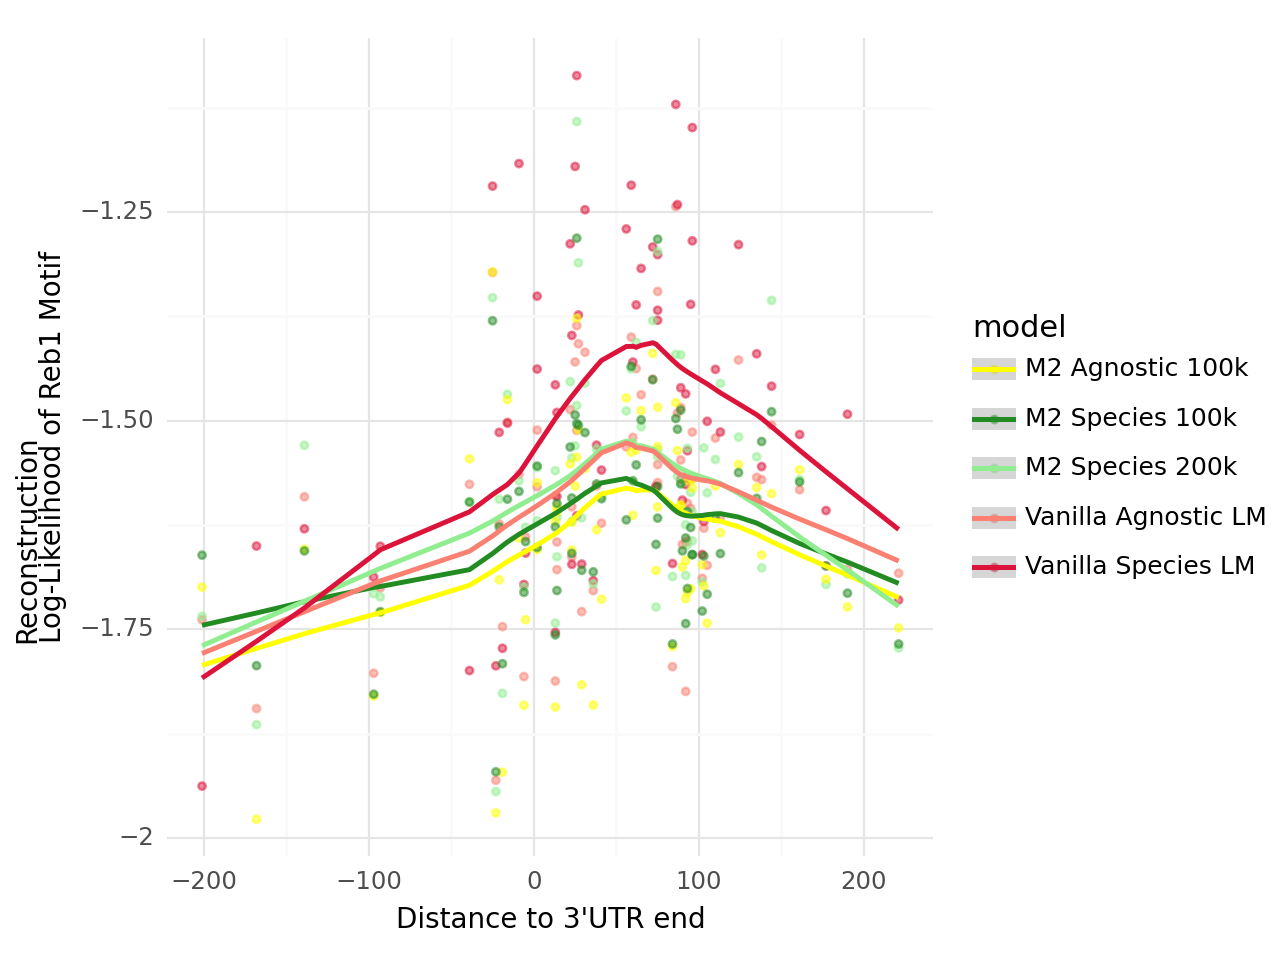

<Figure Size: (640 x 480)>

In [80]:
#grouped = add_grouping(utr3_sites)
name_dict = {
    "BERT-ADN-Species-200k": "Vanilla Species LM",
    "BERT-ADN-200k": "Vanilla Agnostic LM",
    "Conservation": "Conservation",
    "m2-mixer100k": "M2 Species 100k",
    "m2-mixer200k": "M2 Species 200k",
    "m2-agnostic": "M2 Agnostic 100k"
}

utr3_sites['model'] = utr3_sites['model'].replace(name_dict)


p = (p9.ggplot(data=utr3_sites.query('model == "Vanilla Species LM" or model == "Vanilla Agnostic LM" or model == "M2 Species 200k" or model =="M2 Species 100k" or model == "M2 Agnostic 100k"'), 
           mapping=p9.aes(x="distance_to_end",y="ce", color="model"))
 + p9.geom_point(size=1, alpha = 0.5)
 #+ p9.coord_cartesian(ylim=(-1.5,-0.15))
 + p9.geom_smooth(method="lowess", mapping=p9.aes(color="model"), span = 0.6)
 + p9.scale_colour_manual(["yellow","forestgreen", "lightgreen","salmon", "crimson"])
 + p9.labs(x="Distance to 3'UTR end",y="Reconstruction\nLog-Likelihood of Reb1 Motif")
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
        axis_title=p9.element_text(size=10),)
)

p.save("outputs/predictions/3utr_reb1_distance" + ".png", width=6, height=3.0, dpi=300)

p

### CBF1

In [81]:
utr3_site_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation", "m2-mixer200k", "m2-agnostic", "m2-mixer100k"]

for model in roc_models:
    utr3_site_dfs.append(locate_utr3_bind_site_rel_end(model, motif= "CACGTG"))

utr3_sites = pd.concat(utr3_site_dfs)

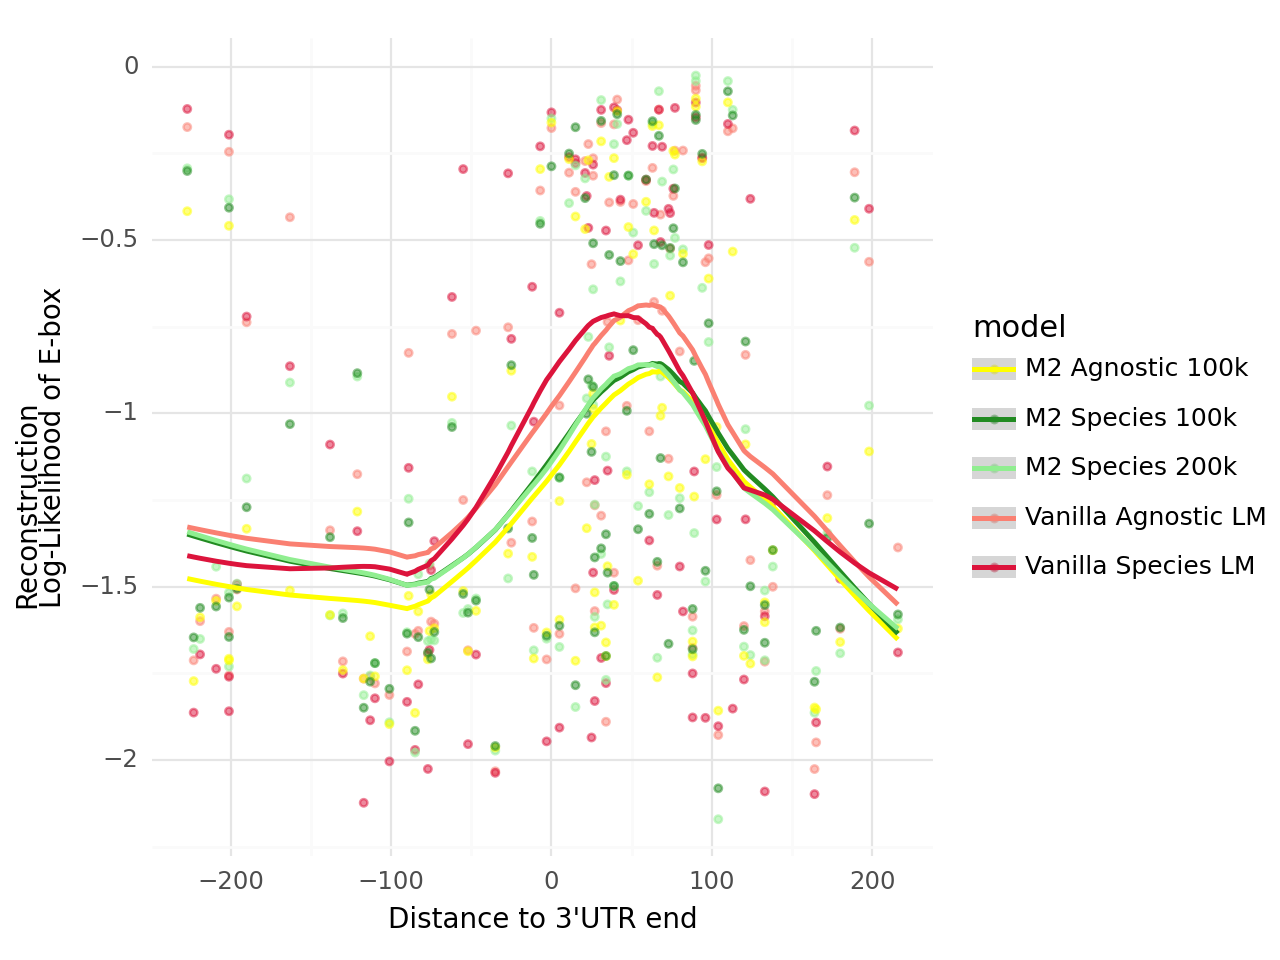

<Figure Size: (640 x 480)>

In [86]:
#grouped = add_grouping(utr3_sites)
name_dict = {
    "BERT-ADN-Species-200k": "Vanilla Species LM",
    "BERT-ADN-200k": "Vanilla Agnostic LM",
    "Conservation": "Conservation",
    "m2-mixer100k": "M2 Species 100k",
    "m2-mixer200k": "M2 Species 200k",
    "m2-agnostic": "M2 Agnostic 100k"
}

utr3_sites['model'] = utr3_sites['model'].replace(name_dict)


p = (p9.ggplot(data=utr3_sites.query('model == "Vanilla Species LM" or model == "Vanilla Agnostic LM" or model == "M2 Species 200k" or model =="M2 Species 100k" or model == "M2 Agnostic 100k"'), 
           mapping=p9.aes(x="distance_to_end",y="ce", color="model"))
 + p9.geom_point(size=1, alpha = 0.5)
 #+ p9.coord_cartesian(ylim=(-1.5,-0.15))
 + p9.geom_smooth(method="lowess", mapping=p9.aes(color="model"), span = 0.6)
 + p9.scale_colour_manual(["yellow","forestgreen", "lightgreen","salmon", "crimson"])
 + p9.labs(x="Distance to 3'UTR end",y="Reconstruction\nLog-Likelihood of E-box")
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
        axis_title=p9.element_text(size=10),)
)

p.save("outputs/predictions/3utr_ebox_distance" + ".png", width=6.0, height=4.5, dpi=300)

p

## Actual and predicted biases as function of distance

In [25]:
def locate_utr3_rel_end(model, dataset = dataset_matched):
    if model == "Conservation":
        path = project_path+"outputs/scer_conservation_withstop_downstream_fixedlen/"
    else:
        path = paths_dict[model]
    # get prbs
    prbs = torch.load(path + "prbs.pt")[:,:4]
    targets = torch.load(path + "masked_targets.pt")
    out_dfs = []
    for _, data_row in dataset.iterrows():
        pos = data_row["concat_start"]
        end_pos = data_row["concat_end"]
        gene = data_row["gene_id"]
        # get distances to the annotated 3' UTR
        dist_to_end = np.arange(0,end_pos-pos) - data_row["rel_end"]
        # get metrics
        match_position = list(range(pos,end_pos))
        prbs_match = prbs[torch.tensor(match_position),:]
        targets_match = targets[torch.tensor(match_position)]
        target_prbs = (torch.nn.functional.one_hot(targets_match, num_classes=4)*prbs_match).max(axis=1)[0]
        if model == "Conservation":
            target_prbs = torch.nan_to_num(target_prbs)
            out_dfs.append(pd.DataFrame({
                "model":model,
                "distance_to_stop":np.arange(0,300),
                "distance_to_end":dist_to_end,
                "target_prbs": target_prbs,
                "prbs_AT": target_prbs,
                "acc":  target_prbs,
                "targets":targets_match,
                "preds":targets_match,
            }))
        else:
            out_dfs.append(pd.DataFrame({
                "model":model,
                "distance_to_stop":np.arange(0,300),
                "distance_to_end":dist_to_end,
                "target_prbs": target_prbs,
                "prbs_AT": prbs_match[:,0] + prbs_match[:,3],
                "acc": prbs_match.argmax(axis=1) == targets_match,
                "targets":targets_match,
                "preds":prbs_match.argmax(axis=1),
                "prbs_A":prbs_match[:,0],
                "prbs_C":prbs_match[:,1],
                "prbs_G":prbs_match[:,2],
                "prbs_T":prbs_match[:,3],
            }))
    return pd.concat(out_dfs)

In [26]:
#utr3_biases = locate_utr3_rel_end("BERT-ADN-Species-200k", dataset = dataset_matched)

utr3_biases_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation", "m2-mixer200k", "m2-agnostic", "m2-mixer100k"]

for model in roc_models:
    utr3_biases_dfs.append(locate_utr3_rel_end(model, dataset=dataset_matched))

utr3_biases = pd.concat(utr3_biases_dfs)

In [27]:
utr3_biases["pred_bias"] = (utr3_biases["preds"] == 0).astype('int') + (utr3_biases["preds"] == 3).astype('int')
utr3_biases["true_bias"] = (utr3_biases["targets"] == 0).astype('int') + (utr3_biases["targets"] == 3).astype('int')

In [28]:
utr3_biases["true_A"] = (utr3_biases["targets"] == 0).astype('int')
utr3_biases["true_T"] = (utr3_biases["targets"] == 3).astype('int')

In [29]:
dataset_matched["rel_end"].median()

122.0

In [22]:
utr3_biases

model  distance_to_stop  distance_to_end  target_prbs   prbs_AT  \
0    BERT-ADN-200k                 0             -300     0.997759  0.998603   
1    BERT-ADN-200k                 1             -299     0.259982  0.739590   
2    BERT-ADN-200k                 2             -298     0.736520  0.737559   
3    BERT-ADN-200k                 3             -297     0.396438  0.650731   
4    BERT-ADN-200k                 4             -296     0.185260  0.605718   
..             ...               ...              ...          ...       ...   
295    m2-agnostic               295              219     0.218760  0.610079   
296    m2-agnostic               296              220     0.239532  0.577238   
297    m2-agnostic               297              221     0.325666  0.641145   
298    m2-agnostic               298              222     0.192510  0.629425   
299    m2-agnostic               299              223     0.333586  0.585718   

       acc  targets  preds    prbs_A    prbs_C    prbs_G    prbs_T  pred_bias  \
0     True        3      3  0.000843  0.000327  0.001070  0.997759          1   
1    False        2      0  0.738522  0.000429  0.259982  0.001067          1   
2     True        0      0  0.736520  0.000539  0.261902  0.001039          1   
3     True        0      0  0.396438  0.106572  0.242697  0.254293          1   
4    False        2      3  0.291952  0.209022  0.185260  0.313766          1   
..     ...      ...    ...       ...       ...       ...       ...        ...   
295  False        2      3  0.300958  0.171162  0.218760  0.309121          1   
296  False        0      3  0.239532  0.271604  0.151158  0.337706          1   
297   True        0      0  0.325666  0.188437  0.170418  0.315479          1   
298  False        2      3  0.293440  0.178064  0.192510  0.335986          1   
299   True        3      3  0.252132  0.157648  0.256634  0.333586          1   

     true_bias  true_A  true_T  
0            1       0       1  
1            0       0       0  
2            1       1       0  
3            1       1       0  
4            0       0       0  
..         ...     ...     ...  
295          0       0       0  
296          1       1       0  
297          1       1       0  
298          0       0       0  
299          1       0       1  

[6582000 rows x 16 columns]

In [ ]:
# TODO ist der falsch?

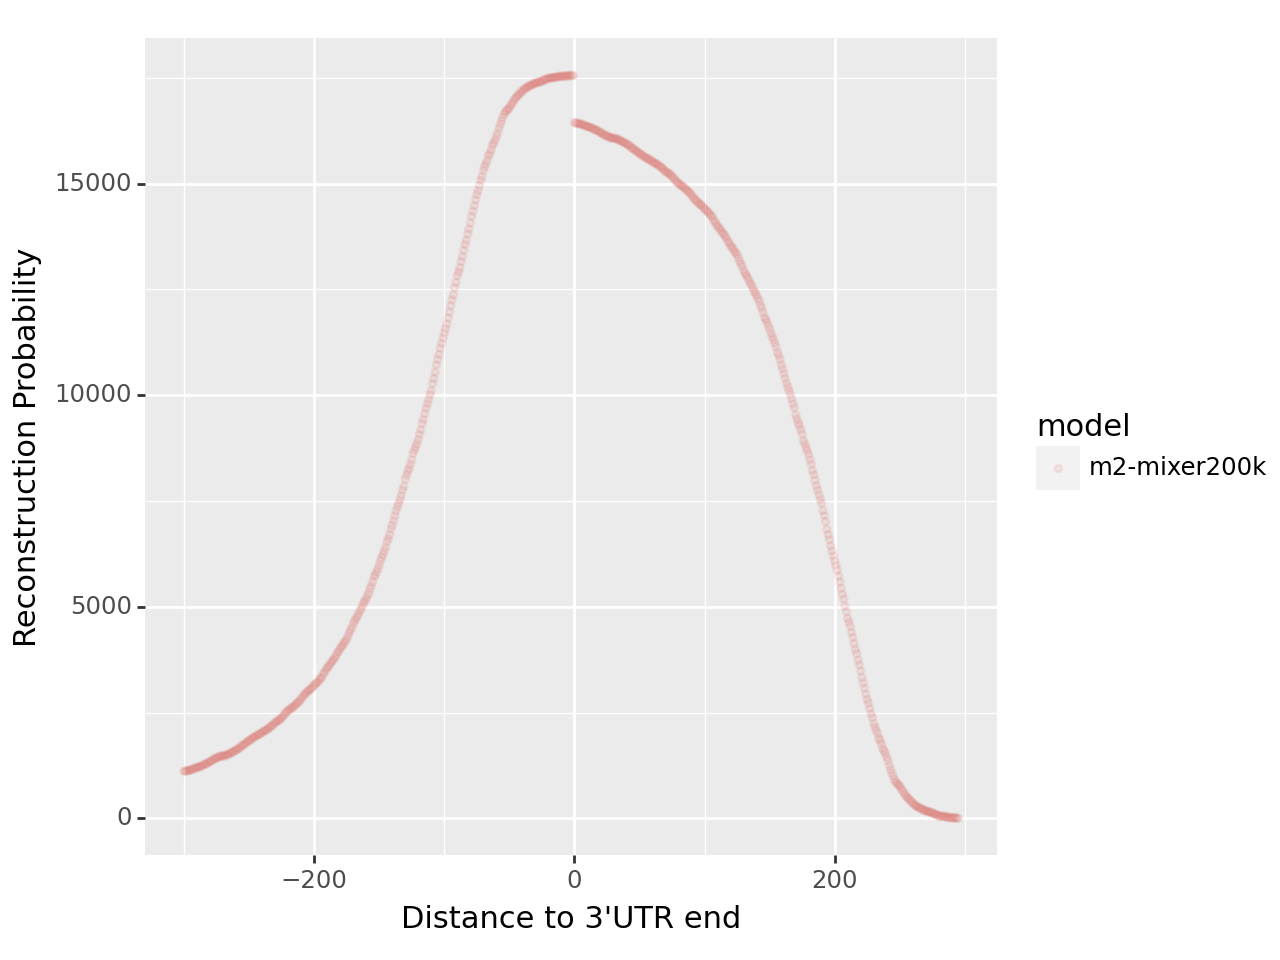

<Figure Size: (640 x 480)>

In [135]:
p = (p9.ggplot(data=utr3_biases.groupby('distance_to_end')[["target_prbs"]].count().reset_index(), 
           mapping=p9.aes(x="distance_to_end",y="target_prbs", color="model"))
 + p9.geom_point(size=1, alpha = 0.1)
 #+ p9.geom_smooth(method="lowess", color="blue")
 + p9.labs(x="Distance to 3'UTR end",y="Reconstruction Probability")
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
p

In [30]:
cols = ["target_prbs", "acc", "prbs_AT", "true_bias", "prbs_A", "true_A", "prbs_T", "true_T"]

#TODO cast acc to int
utr3_biases = utr3_biases.astype({'acc': 'int'})
utr3_biases_grouped = utr3_biases.groupby(['distance_to_end', 'model'])[cols].mean().reset_index()
utr3_biases_se = utr3_biases.groupby(['distance_to_end', 'model'])[cols].sem().reset_index().rename(columns={col: col + "_se" for col in cols})
utr3_biases_grouped = utr3_biases_grouped.merge(utr3_biases_se, on=["distance_to_end", "model"])
utr3_biases_grouped = utr3_biases_grouped.dropna()
utr3_biases_grouped["target_prbs_high"] = utr3_biases_grouped["target_prbs"] + (utr3_biases_grouped["target_prbs_se"] * 2)
utr3_biases_grouped["target_prbs_low"] = utr3_biases_grouped["target_prbs"] - (utr3_biases_grouped["target_prbs_se"] * 2)
utr3_biases_grouped["acc_high"] = utr3_biases_grouped["acc"] + (utr3_biases_grouped["acc_se"] * 2)
utr3_biases_grouped["acc_low"] = utr3_biases_grouped["acc"] - (utr3_biases_grouped["acc_se"] * 2)


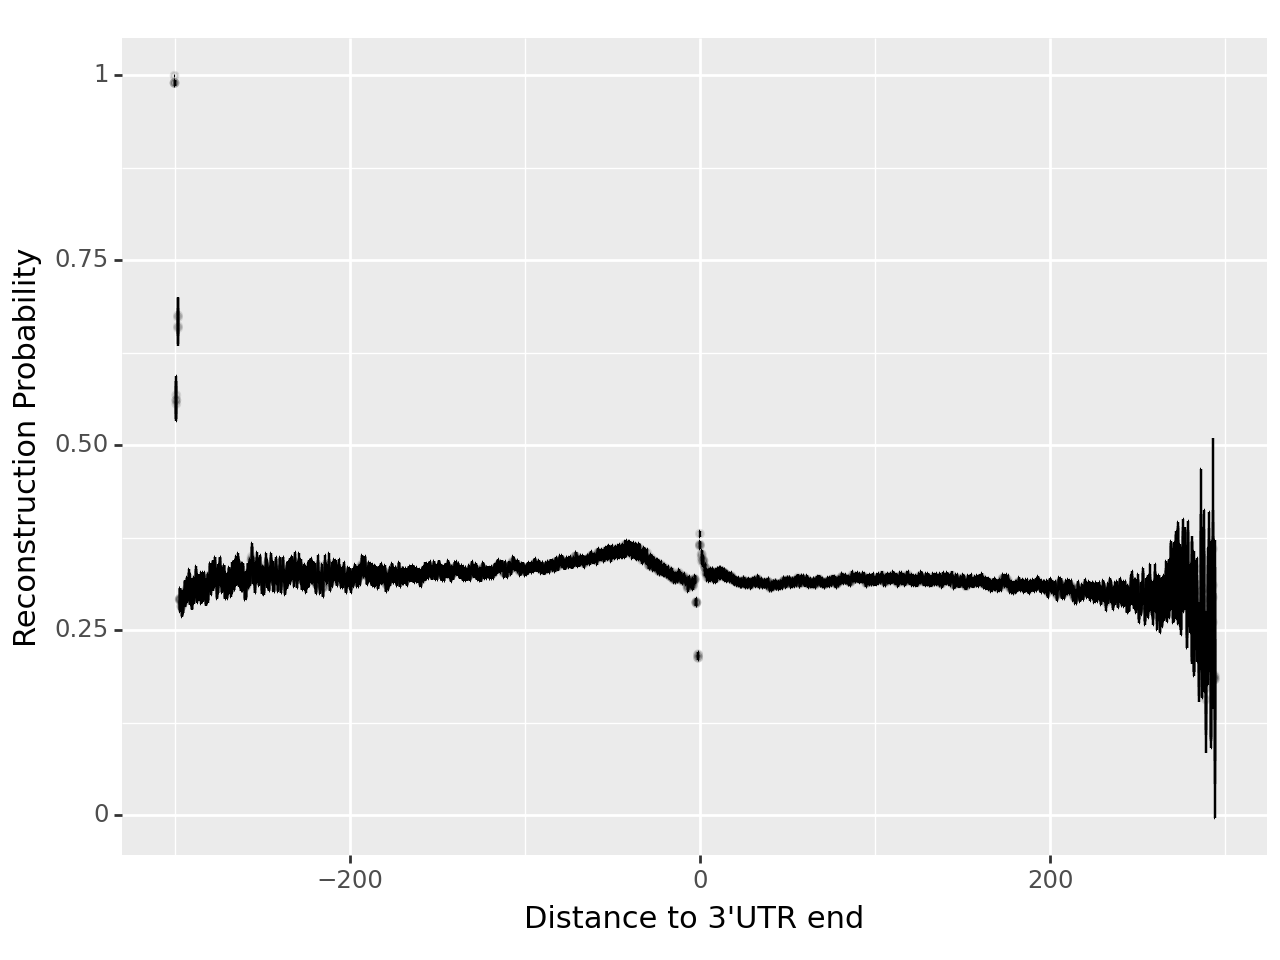

<Figure Size: (640 x 480)>

In [89]:
p = (p9.ggplot(data=utr3_biases_grouped, 
           mapping=p9.aes(x="distance_to_end",y="target_prbs"))
 + p9.geom_point(size=1, alpha = 0.1)
 + p9.geom_errorbar(mapping=p9.aes(ymin="target_prbs_low",ymax="target_prbs_high"))
 #+ p9.geom_smooth(method="lowess", color="blue")
 + p9.labs(x="Distance to 3'UTR end",y="Reconstruction Probability")
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
p

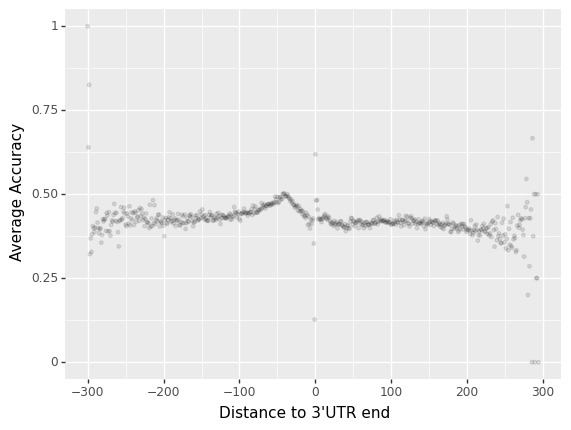

<ggplot: (1432162799255)>

In [135]:
p = (p9.ggplot(data=utr3_biases_grouped, 
           mapping=p9.aes(x="distance_to_end",y="acc"))
 + p9.geom_point(size=1, alpha = 0.1)
 #+ p9.geom_errorbar(mapping=p9.aes(ymin="acc_low",ymax="acc_high"))
 #+ p9.geom_smooth(method="lowess", color="blue")
 + p9.labs(x="Distance to 3'UTR end",y="Average Accuracy")
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
p

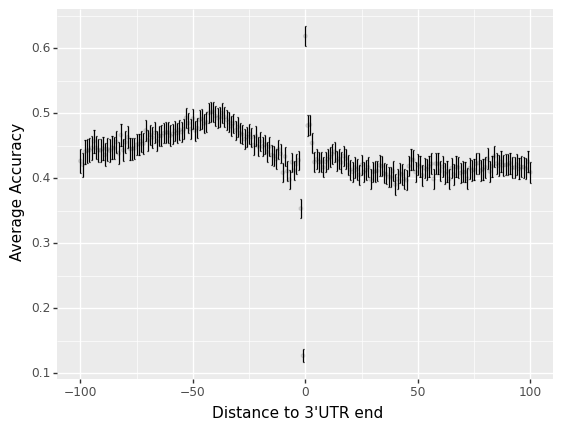

<ggplot: (1432131685298)>

In [136]:
p = (p9.ggplot(data=utr3_biases_grouped.query('distance_to_end > -101 and distance_to_end < 101'), 
           mapping=p9.aes(x="distance_to_end",y="acc"))
 + p9.geom_point(size=1, alpha = 0.1)
 + p9.geom_errorbar(mapping=p9.aes(ymin="acc_low",ymax="acc_high"))
 #+ p9.geom_smooth(method="lowess", color="blue")
 + p9.labs(x="Distance to 3'UTR end",y="Average Accuracy")
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
p

In [34]:
utr3_biases_grouped

distance_to_end                  model  target_prbs       acc   prbs_AT  \
0                -300          BERT-ADN-200k     0.989325  1.000000  0.993100   
1                -300  BERT-ADN-Species-200k     0.999259  1.000000  0.999372   
3                -300            m2-agnostic     0.989723  1.000000  0.993455   
4                -300           m2-mixer200k     0.989484  1.000000  0.993230   
5                -299          BERT-ADN-200k     0.561026  0.639286  0.708821   
...               ...                    ...          ...       ...       ...   
2969              293           m2-mixer200k     0.260847  0.500000  0.658818   
2970              294          BERT-ADN-200k     0.186634  0.000000  0.619913   
2971              294  BERT-ADN-Species-200k     0.183521  0.000000  0.595877   
2973              294            m2-agnostic     0.183740  0.000000  0.679771   
2974              294           m2-mixer200k     0.188804  0.000000  0.649728   

      true_bias    prbs_A    true_A    prbs_T    true_T  ...  prbs_AT_se  \
0      1.000000  0.003775  0.000000  0.989325  1.000000  ...    0.001229   
1      1.000000  0.000113  0.000000  0.999259  1.000000  ...    0.000103   
3      1.000000  0.003732  0.000000  0.989723  1.000000  ...    0.001202   
4      1.000000  0.003746  0.000000  0.989484  1.000000  ...    0.000978   
5      0.639286  0.697157  0.632143  0.011664  0.007143  ...    0.004421   
...         ...       ...       ...       ...       ...  ...         ...   
2969   0.750000  0.240427  0.500000  0.418391  0.250000  ...    0.010882   
2970   0.500000  0.331226  0.500000  0.288687  0.000000  ...    0.047874   
2971   0.500000  0.287507  0.500000  0.308370  0.000000  ...    0.049150   
2973   0.500000  0.311302  0.500000  0.368470  0.000000  ...    0.052004   
2974   0.500000  0.273120  0.500000  0.376608  0.000000  ...    0.062742   

      true_bias_se  prbs_A_se  true_A_se  prbs_T_se  true_T_se  \
0         0.000000   0.000778   0.000000   0.002003   0.000000   
1         0.000000   0.000016   0.000000   0.000119   0.000000   
3         0.000000   0.000834   0.000000   0.002027   0.000000   
4         0.000000   0.000611   0.000000   0.001583   0.000000   
5         0.028749   0.005582   0.028870   0.005010   0.005042   
...            ...        ...        ...        ...        ...   
2969      0.250000   0.068349   0.288675   0.072555   0.250000   
2970      0.500000   0.088046   0.500000   0.040172   0.000000   
2971      0.500000   0.076526   0.500000   0.027375   0.000000   
2973      0.500000   0.033700   0.500000   0.018304   0.000000   
2974      0.500000   0.011295   0.500000   0.051447   0.000000   

      target_prbs_high  target_prbs_low  acc_high   acc_low  
0             0.993331         0.985319  1.000000  1.000000  
1             0.999496         0.999021  1.000000  1.000000  
3             0.993777         0.985669  1.000000  1.000000  
4             0.992650         0.986318  1.000000  1.000000  
5             0.586296         0.535756  0.696784  0.581787  
...                ...              ...       ...       ...  
2969          0.377702         0.143992  1.077350 -0.077350  
2970          0.299727         0.073542  0.000000  0.000000  
2971          0.238443         0.128599  0.000000  0.000000  
2973          0.371462        -0.003981  0.000000  0.000000  
2974          0.334846         0.042761  0.000000  0.000000  

[2380 rows x 22 columns]

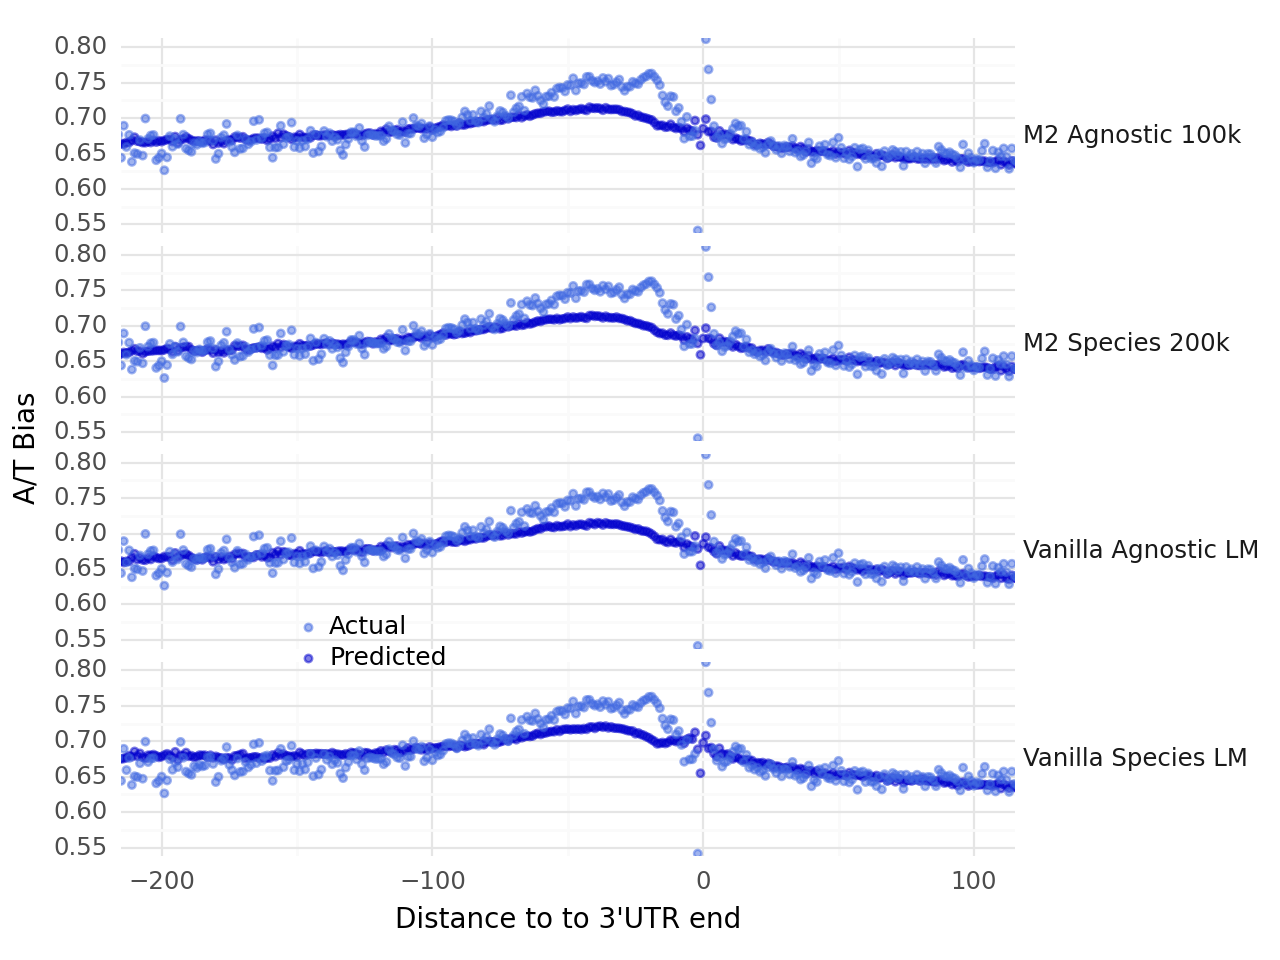

<Figure Size: (640 x 480)>

In [33]:
#grouped = add_grouping(utr3_sites)
name_dict = {
    "BERT-ADN-Species-200k": "Vanilla Species LM",
    "BERT-ADN-200k": "Vanilla Agnostic LM",
    "Conservation": "Conservation",
    "m2-mixer100k": "M2 Species 100k",
    "m2-mixer200k": "M2 Species 200k",
    "m2-agnostic": "M2 Agnostic 100k"
}

utr3_biases_grouped['model'] = utr3_biases_grouped['model'].replace(name_dict)


#p = (p9.ggplot(data=utr3_sites.query('model == "Vanilla Species LM" or model == "Vanilla Agnostic LM" or model == "M2 Species 200k" or model =="M2 Species 100k" or model == "M2 Agnostic 100k"'), 

utr3_cropped = utr3_biases_grouped[utr3_biases_grouped['model'] != 'M2 Species 100k']

p = (p9.ggplot(data=(utr3_cropped[["distance_to_end","prbs_AT","true_bias","model"]].rename(columns={"prbs_AT":"Predicted","true_bias":"Actual"})
                     .melt(id_vars=["distance_to_end", "model"])
                    ), 
           mapping=p9.aes(x="distance_to_end",y="value",color="variable"))
 + p9.geom_point(size=1, alpha = 0.5)
 + p9.coord_cartesian(xlim=(-200,100),ylim=(0.55,0.8))
 #+ p9.geom_smooth(method="lowess", color="blue")
 + p9.scale_color_manual(values=["royalblue", "mediumblue"])
 + p9.labs(x="Distance to to 3'UTR end",y="A/T Bias", color="")
 + p9.theme_minimal()
 + p9.facet_grid("model ~ .")
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.29,0.35), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
            strip_text_y = p9.element_text(angle = 0)  # Add this line to rotate the facet labels
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)

p.save("outputs/predictions/MotifContext_utr3" + ".png", width=6.0, height=6.0, dpi=300)

p

In [41]:
utr3_biases_grouped[["distance_to_end","prbs_AT","true_bias","model"]].rename(columns={"prbs_AT":"Predicted","true_bias":"Actual"}).melt(id_vars=["distance_to_end","model"])

distance_to_end                  model   variable     value
0                -300          BERT-ADN-200k  Predicted  0.993100
1                -300  BERT-ADN-Species-200k  Predicted  0.999372
2                -300            m2-agnostic  Predicted  0.993455
3                -300           m2-mixer200k  Predicted  0.993230
4                -299          BERT-ADN-200k  Predicted  0.708821
...               ...                    ...        ...       ...
4755              293           m2-mixer200k     Actual  0.750000
4756              294          BERT-ADN-200k     Actual  0.500000
4757              294  BERT-ADN-Species-200k     Actual  0.500000
4758              294            m2-agnostic     Actual  0.500000
4759              294           m2-mixer200k     Actual  0.500000

[4760 rows x 4 columns]

# Upstream

In [139]:
dataset = pd.read_parquet(project_path+"data/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/saccharomyces_cerevisiae_five_prime.parquet")
dataset = dataset.loc[dataset["five_prime_seq"].str.len() == 1003]

In [140]:
# determine positions in concatenated data
start = 0
starts = []
stops = []
for _,row in dataset.iterrows():
    starts.append(start)
    stops.append(start + len(row["five_prime_seq"]))
    start = start + len(row["five_prime_seq"]) 
    
dataset["concat_start"] = starts
dataset["concat_end"] = stops

In [141]:
background = {"A":0.31,
              "C":0.19,
              "G":0.19,
              "T":0.31}

high_conf_motifs = pd.read_csv(project_path+"data/Motifs/high_conf_motifs.tsv",sep="\t")

base_path_motif = project_path+"data/Motifs/All_PFMs/1.02/ALIGNED_ENOLOGO_FORMAT_PFMS/{}.pfm"
high_conf_pfms = {k:pd.read_csv(base_path_motif.format(v),sep="\t",header=None).sort_values(0) for k,v in zip(high_conf_motifs["Motif Name"], #.set_index(0).to_numpy()
                                                                                                              high_conf_motifs["Motif ID"])}
high_conf_pssms = {k:motifs.parse(["\t".join([str(row[ix]) for ix in range(len(row))]) for _,row in v.iterrows()],"pfm-four-rows")[0].counts.normalize(pseudocounts=0.001).log_odds(background)
                   for k,v in high_conf_pfms.items()}
high_conf_ic = {k:np.array([v["A"],v["C"],v["G"],v["T"]]) for k,v in high_conf_pssms.items()}
high_conf_ic = {k:high_conf_pfms[k].set_index(0).to_numpy()*v for k,v in high_conf_ic.items()}

In [142]:
paths_dict = {
    "Nucleotide Distribution":project_path+"outputs/0_markov_scer_upstream_withoutstop/", 
    "All 1-Markov":project_path+"outputs/1_markov_scer_upstream_withoutstop/", 
    "All 2-Markov":project_path+"outputs/2_markov_scer_upstream_withoutstop/",  
    "All 3-Markov":project_path+"outputs/3_markov_scer_upstream_withoutstop/", 
    "All 4-Markov":project_path+"outputs/4_markov_scer_upstream_withoutstop/", 
    "All 5-Markov":project_path+"outputs/5_markov_scer_upstream_withoutstop/", 
    "All 6-Markov":project_path+"outputs/6_markov_scer_upstream_withoutstop/", 
    "BERT-ADN-200k":project_path+'outputs/bertadn_origtest_convolved_prb_agnostic_scer_upstream_1024_withoutstop/',
    "BERT-ADN-Species-200k":project_path+'outputs/bertadn_origtest_convolved_prb_kazachstania_africana_cbs_2517_gca_000304475_scer_upstream_1024_withoutstop/',
    "Far-Alignment":project_path+"outputs/scer_align_far_withstop_upstream/",
    "Close-Alignment":project_path+"outputs/scer_align_close_withstop_upstream/",
}

In [143]:
for model in paths_dict:
    path = paths_dict[model]
    targets = torch.load(path + "masked_targets.pt")
    prbs = torch.load(path + "prbs.pt")[:,:4]
    #prbs = prbs/prbs.sum(axis=1, keepdims=True) # normalize
    # compute metrics
    target_prbs = (torch.nn.functional.one_hot(targets)*prbs).max(axis=1)[0]
    acc = torch.sum(prbs.argmax(axis=1) == targets)/targets.shape[0]
    avg_target_prbs = torch.mean(target_prbs)
    if "Alignment" in model:
        prbs_smoothed = prbs + 0.01
        prbs_smoothed = prbs_smoothed/prbs_smoothed.sum(axis=1, keepdims=True)
        ce = torch.nn.functional.nll_loss(torch.log(prbs_smoothed), targets)
    else:
        ce = torch.nn.functional.nll_loss(torch.log(prbs), targets)
    perplexity = torch.exp(ce)
    #print("{}: prb = {:.3f}, accuracy = {:.3f}".format(model,avg_target_prbs, acc))
    print("{}: CE = {:.3f}, accuracy = {:.3f}".format(model, ce, acc))

Nucleotide Distribution: CE = 1.377, accuracy = 0.308
All 1-Markov: CE = 1.369, accuracy = 0.341
All 2-Markov: CE = 1.364, accuracy = 0.343
All 3-Markov: CE = 1.356, accuracy = 0.341
All 4-Markov: CE = 1.354, accuracy = 0.339
All 5-Markov: CE = 1.353, accuracy = 0.338
All 6-Markov: CE = 1.358, accuracy = 0.331
BERT-ADN-200k: CE = 1.234, accuracy = 0.435
BERT-ADN-Species-200k: CE = 1.211, accuracy = 0.442
Far-Alignment: CE = 1.490, accuracy = 0.466
Close-Alignment: CE = 1.164, accuracy = 0.762


In [144]:
def match_motif(motif, dataset = dataset):
    info_pos = np.array([i for i,x in enumerate(re.sub("\[.\]|\[..\]",".",motif)) if x != "."])
    print(info_pos)
    match_data = find_matches_noduplicates_upstream(dataset, motif)
    pos = 0
    counter = 0
    col = "five_prime_seq"
    match_positions = []
    for _,data_row in match_data.iterrows():
        pos = data_row["concat_start"]
        counter += 1
        start = data_row["match_start"]
        end = data_row["match_end"]
        match_positions += [x for x in pos + start + info_pos]
    return match_positions
 
    
def match_location(loc="kozak", dataset = dataset, only_annot=True):
    pos = 0
    match_positions = []
    for _,row in dataset.iterrows():
        pos = row["concat_end"]
        if loc == "kozak":
            match_positions += [pos-6,pos-5,pos-4]
        elif loc == "kozak-3":
            match_positions += [pos-6]
        elif loc == "all":
            pos = row["concat_start"]
            match_positions += list(range(pos,pos+len(row["five_prime_seq"])))
        else:
            assert False
    return match_positions 

def compute_metrics(model, match_positions, motif, paths_dict=paths_dict, species="scer"):
    if len(match_positions) == 0:
        return {
            "species":species,
            "model":model,
            "motif":motif,
            "n":0,
            "mean_target_prb":0,
            "cross_entropy":0,
            "accuracy":0,
            "acc_se":0,
            "acc_low":0,
            "acc_high":1,
        }
    path = paths_dict[model]
    targets = torch.load(path + "masked_targets.pt")
    prbs = torch.load(path + "prbs.pt")[:,:4]
    # select matching positions
    prbs = prbs[torch.tensor(match_positions),:]
    targets = targets[torch.tensor(match_positions)]
    # compute metrics
    target_prbs = (torch.nn.functional.one_hot(targets,num_classes=4)*prbs).max(axis=1)[0]
    acc = torch.sum(prbs.argmax(axis=1) == targets)/targets.shape[0]
    acc_se = torch.sqrt(acc*(1-acc)/targets.shape[0])
    avg_target_prbs = torch.mean(target_prbs)
    target_prb_sd = torch.std_mean(target_prbs)[0]
    if "Alignment" in model:
        prbs_smoothed = prbs + 0.01
        prbs_smoothed = prbs_smoothed/prbs_smoothed.sum(axis=1, keepdims=True)
        ce = torch.nn.functional.nll_loss(torch.log(prbs_smoothed), targets)
    else:
        ce = torch.nn.functional.nll_loss(torch.log(prbs), targets)
    perplexity = torch.exp(ce)
    n = targets.shape[0]
    return {
            "species":species,
            "model":model,
            "motif":motif,
            "n":targets.shape[0],
            "mean_target_prb":avg_target_prbs.item(),
            "cross_entropy":ce.item(),
            "accuracy":acc.item(),
            "acc_se":acc_se.item(),
            "acc_low":acc.item() - 2*acc_se.item(),
            "acc_high":acc.item() + 2*acc_se.item(),
        }

In [145]:
rows = []

upstream_motifs = ["[CA]GGGTAA",
                   "CA[TC]CC[GA]TACA[TC]", 
                   "TATA[AT]A[AT][AG]", 
                   "CACGTG",
                   "GAA..TTCT[AG]GAA", 
                   "TAGCCGCC",
                   "AATTTTTCA", 
                   "ACGCGT", 
                   "GTAAACA",
                   "G[CA]GATGAG[CA]T", 
                   "A[GA]CCCTAA",
                   "TTACGTAA"
                  ]
upstream_loc = ["kozak-3","all"]#["kozak","kozak-3","all"]

for motif in upstream_motifs + upstream_loc:
    if motif in upstream_loc:
        match_positions = match_location(loc = motif)
    else:
        match_positions = match_motif(motif)
    print(motif)
    for model in paths_dict:
        rows.append(compute_metrics(model, match_positions, motif))
        
metrics_df = pd.DataFrame(rows).sort_values(["motif","accuracy"]).reset_index(drop=True) #.query('model not in ["Close-Alignment"]').

[1 2 3 4 5 6]
[CA]GGGTAA
[0 1 3 4 6 7 8 9]
CA[TC]CC[GA]TACA[TC]
[0 1 2 3 5]
TATA[AT]A[AT][AG]
[0 1 2 3 4 5]
CACGTG
[ 0  1  2  5  6  7  8 10 11 12]
GAA..TTCT[AG]GAA
[0 1 2 3 4 5 6 7]
TAGCCGCC
[0 1 2 3 4 5 6 7 8]
AATTTTTCA
[0 1 2 3 4 5]
ACGCGT
[0 1 2 3 4 5 6]
GTAAACA
[0 2 3 4 5 6 7 9]
G[CA]GATGAG[CA]T
[0 2 3 4 5 6 7]
A[GA]CCCTAA
[0 1 2 3 4 5 6 7]
TTACGTAA
kozak-3
all


## Plot reconstruction

In [146]:
model_order = ["Nucleotide Distribution", 
               'All 3-Markov',
               'All 4-Markov', 
               'All 5-Markov', 
               'All 6-Markov', 
               "Far-Alignment",
               "BERT-ADN-200k", 
               "BERT-ADN-Species-200k",
               "Close-Alignment"]

def assign_model_type(model):
    if "Species" in model:
        return "Species LM"
    elif "BERT" in model or "SSM" in model:
        return "Agnostic LM"
    elif model == "Close-Alignment":
        return "Alignment (close)"
    elif model == "Far-Alignment":
        return "Alignment (far)"
    else:
        return "Baseline"
    
model_rename = {
    "Nucleotide Distribution":"Majority Class",
    'All 3-Markov':"Best k-mer",#"7-mers",
    'All 4-Markov':"Best k-mer",#"9-mers",
    'All 5-Markov':"Best k-mer",#"11-mers", 
    'All 6-Markov':"Best k-mer",#"13-mers", 
    "Far-Alignment": "Far-Alignment", #"WGA (inter-genus)",
    "SSM":"SSM", 
    "SSM-Species":"SSM-Species", 
    "BERT-ADN-200k":"Agnostic LM",
    "BERT-ADN-Species-200k":"Species LM",
    "BERT-ADN-Sacch_incl":"BERT-Saccharomyces",
    "BERT-ADN-Species-Sacch_incl":"BERT-Species-Saccharomyces",
    'BERT-ADN-Species-Sacch_incl-cglabrata':"BERT-Species-Saccharomyces-CG",
    'BERT-ADN-Species-Sacch_incl_685k-cglabrata' :"BERT-Spec-Sacch-685k-CG",
    'BERT-ADN-Species-Sacch_incl_800k':"BERT-Spec-Sacch-800k",
    "Close-Alignment" : "Close-Alignment"#"WGA (intra-genus)",
}

motif_rename = {
    'all' : 'all',
    "CA[TC]CC[GA]TACA[TC]":"Rap1", #modisco hit
    "AATTTTTCA": "RRPE (Stb3)", # modisco hit
    "TAGCCGCC":"Ume6", # modisco hit
    "[CA]GGGTAA" : 'Reb1', #modsco hit
    "G[CA]GATGAG[CA]T":"PAC (Tod6)", # modisco hit
    "GAA..TTCT[AG]GAA":"Hsf1",
     "A[GA]CCCTAA": "Tbf1", # modsico hit
    "TATA[AT]A[AT][AG]":"TATA-box", # modisco hit
    "ACGCGT": "Mbp1", # modisco hit
    "CACGTG":"E-box (Cbf1)", # modisco hit
    "GTAAACA": "Fkh1/2", # modisco hit
    #"kozak-3":"Start Codon - 3",
}

motifs_of_interest = list(motif_rename.keys())

plot_df = metrics_df.query('motif in @motifs_of_interest and model in @model_order')
plot_df['motif'] = plot_df['motif'].apply(lambda x: motif_rename[x])

In [147]:
plot_df.query('model == "BERT-ADN-Species-200k"')

species                  model         motif        n  mean_target_prb   
9      scer  BERT-ADN-Species-200k   RRPE (Stb3)     3474         0.609537  \
20     scer  BERT-ADN-Species-200k          Mbp1     3402         0.405662   
31     scer  BERT-ADN-Species-200k          Tbf1      966         0.476514   
41     scer  BERT-ADN-Species-200k  E-box (Cbf1)     4548         0.464458   
54     scer  BERT-ADN-Species-200k          Rap1      528         0.761685   
64     scer  BERT-ADN-Species-200k          Hsf1      250         0.567615   
73     scer  BERT-ADN-Species-200k        Fkh1/2     4487         0.379144   
86     scer  BERT-ADN-Species-200k    PAC (Tod6)     1272         0.870319   
97     scer  BERT-ADN-Species-200k          Ume6     1112         0.672130   
108    scer  BERT-ADN-Species-200k      TATA-box    34730         0.642704   
130    scer  BERT-ADN-Species-200k          Reb1     4950         0.632015   
140    scer  BERT-ADN-Species-200k           all  6586701         0.345037   

     cross_entropy  accuracy    acc_se   acc_low  acc_high  
9         0.598552  0.836212  0.006279  0.823654  0.848770  
20        1.172750  0.528807  0.008558  0.511690  0.545923  
31        0.950854  0.566253  0.015945  0.534362  0.598143  
41        1.137027  0.537599  0.007393  0.522813  0.552385  
54        0.339209  0.918561  0.011903  0.894755  0.942367  
64        0.663864  0.844000  0.022949  0.798102  0.889898  
73        1.131026  0.491420  0.007463  0.476493  0.506346  
86        0.183040  0.958333  0.005603  0.947128  0.969539  
97        0.528281  0.832734  0.011192  0.810350  0.855118  
108       0.553318  0.824417  0.002042  0.820334  0.828500  
130       0.652281  0.737576  0.006253  0.725069  0.750082  
140       1.211124  0.441976  0.000194  0.441589  0.442363

In [148]:
plot_df["model_type"] = plot_df["model"].apply(assign_model_type)
plot_df["model_cat"] = plot_df["model"].apply(lambda x: model_rename[x])

plot_df = plot_df.query('model_cat != "Close-Alignment"').merge((plot_df.query('model_cat == "Close-Alignment"')
                                                                   [["motif","accuracy"]].rename(columns = {"accuracy":"acc_close"})
                                                                  ), on = "motif")

plot_df["model_cat"] = pd.Categorical(plot_df["model_cat"], categories=list(dict.fromkeys(model_rename.values())))
plot_df["model_type"] = pd.Categorical(plot_df["model_type"], categories=["Baseline","Alignment (far)", "Agnostic LM", "Species LM"])

plot_df["motif_cat"] = pd.Categorical(plot_df["motif"], categories=motif_rename.values())

In [149]:
plot_df = plot_df.sort_values(["motif","accuracy"], ascending=False).drop_duplicates(["motif","model_cat"], keep="first")

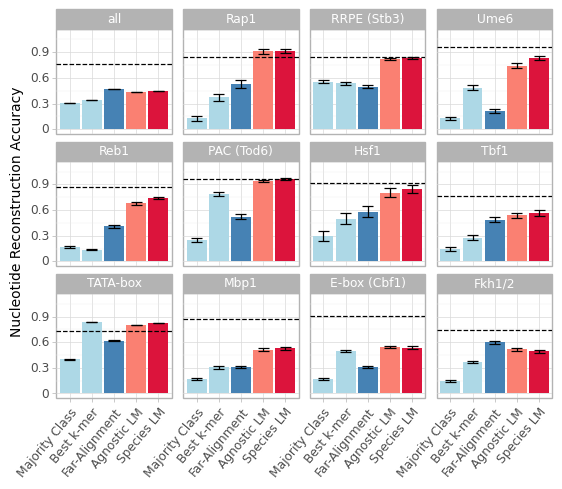

<ggplot: (1432131684319)>

In [150]:
p = (p9.ggplot(data = plot_df,mapping=p9.aes(x="model_cat",y="accuracy", fill="model_type")) 
 + p9.geom_bar(stat="identity")
 + p9.geom_errorbar(mapping=p9.aes(x="model_cat", ymin="acc_low",ymax="acc_high"))
 + p9.geom_hline(mapping=p9.aes(yintercept="acc_close"), linetype="dashed")
 + p9.scale_fill_manual(values=["lightblue","steelblue","salmon","crimson"])
 + p9.coord_cartesian(ylim=(0,1.12))
 + p9.facet_wrap('~motif_cat')
 + p9.labs(x="", y="Nucleotide Reconstruction Accuracy", fill = 'Model Type')
 + p9.theme_light()
 + p9.theme(legend_position="none",
            legend_text=p9.element_text(size=9),legend_title=p9.element_text(size=9),
            subplots_adjust={'wspace': 0.1},
            axis_text_x=p9.element_text(rotation=50, hjust=1, rotation_mode='anchor'),
            legend_box_margin=0,legend_key_width=6,
            axis_title=p9.element_text(size=10))
)

#p.save("../Graphics/Paper/Reconstruction_upstream" + ".svg", width=6.4, height=6.0, dpi=300)

p

## Relationship with Conservation

In [151]:
def get_overall_metrics(model):
    if model == "Conservation":
        path = project_path+"outputs/scer_conservation_withoutstop_upstream/"
    else:
        path = paths_dict[model]
    # get prbs
    prbs = torch.load(path + "prbs.pt")[:,:4]
    targets = torch.load(path + "masked_targets.pt")
    # compute the cross-entropy and accuracy
    if model == "Conservation":
        ce = (torch.nn.functional.one_hot(targets)*prbs).max(axis=1)[0]
        ce = torch.nan_to_num(ce)
        target_prb = ce
        max_prb = ce
    else:
        ce = -torch.nn.functional.nll_loss(torch.log(prbs), targets, reduction="none")
        target_prb = (torch.nn.functional.one_hot(targets)*prbs).max(axis=1)[0]
        max_prb = (prbs).max(axis=1)[0]
    # aggregate results
    return_df = pd.DataFrame({"pos":np.arange(ce.shape[0]),"model":model,"ce":ce.numpy(),"target_prb":target_prb.numpy(),"max_prb":max_prb.numpy()})
    return return_df

In [152]:
conservation_dfs = []

for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation"]:
    conservation_dfs.append(get_overall_metrics(model))

In [153]:
conservation_df = pd.concat(conservation_dfs)

In [154]:
conservation_merged = conservation_df.query('model=="BERT-ADN-Species-200k"').sort_values('ce').merge(conservation_df.query('model=="Conservation"')[["ce","target_prb","pos"]],suffixes=("","_Conservation"), on="pos")
conservation_merged_agnostic = conservation_df.query('model=="BERT-ADN-200k"').sort_values('ce').merge(conservation_df.query('model=="Conservation"')[["ce","target_prb","pos"]],suffixes=("","_Conservation"), on="pos")

In [155]:
def make_labels_from_fixed_bins(bins):
    lower = list(np.array(bins))
    upper = lower[1:] + [1]
    bins = ["[{},{})".format(np.round(x,2),np.round(y,2)) for x,y in zip(lower,upper)]
    return bins

In [156]:
# binning into quantiles
quantiles = 5
labels = list(range(quantiles))
bins_prb = [x for x in np.quantile(conservation_merged["max_prb"],q=np.arange(quantiles)/quantiles)] + [float('inf')]
conservation_merged['quantile'] = pd.cut(conservation_merged['max_prb'], bins=bins_prb, right=True, labels=labels, 
                                           retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True).fillna(labels[0])
bins_prb_agnostic = [x for x in np.quantile(conservation_merged_agnostic["max_prb"],q=np.arange(quantiles)/quantiles)] + [float('inf')]
conservation_merged_agnostic['quantile'] = pd.cut(conservation_merged_agnostic['max_prb'], bins=bins_prb_agnostic, right=True, labels=labels, 
                                                    retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True).fillna(labels[0])
# binning the probability
n_bins = 5
bins = list(np.arange(n_bins)/n_bins)
labels =  make_labels_from_fixed_bins(bins)
bins = bins + [float('inf')]
conservation_merged['target_prb_bin'] = pd.cut(conservation_merged['target_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)
conservation_merged_agnostic['target_prb_bin'] = pd.cut(conservation_merged_agnostic['target_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)

# binning the max probability
bins = [0.2499999, 0.3, 0.4, 0.6, 0.8]
labels =  make_labels_from_fixed_bins(bins)
bins = bins + [float('inf')]
conservation_merged['max_prb_bin'] = pd.cut(conservation_merged['max_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)
conservation_merged_agnostic['max_prb_bin'] = pd.cut(conservation_merged_agnostic['max_prb'], bins=bins, right=True, labels=labels, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)



In [157]:
cons_df = pd.concat([conservation_merged,conservation_merged_agnostic])

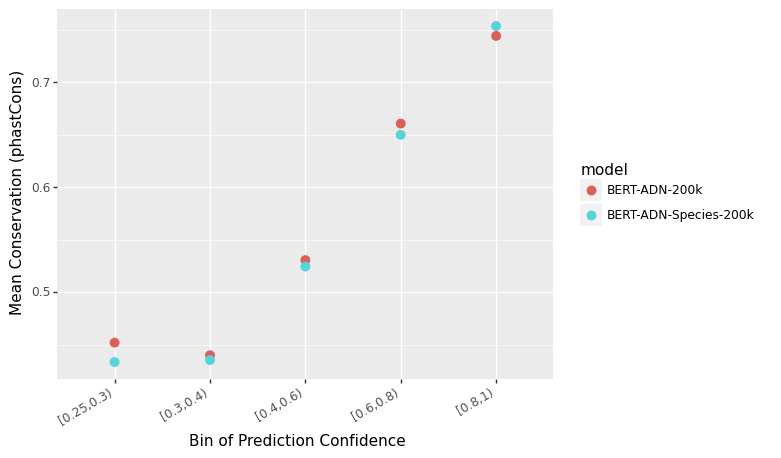

<ggplot: (1432131537917)>

In [158]:
(p9.ggplot(data=cons_df.groupby(['model','max_prb_bin'])["ce_Conservation"].mean().reset_index(), 
           mapping=p9.aes(x="max_prb_bin",y="ce_Conservation", color="model"))
 + p9.geom_point(size=3)
 + p9.labs(x="Bin of Prediction Confidence",y="Mean Conservation (phastCons)")
 + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)

In [159]:
scipy.stats.mannwhitneyu(cons_df.query('max_prb_bin == "[0.8,1)" and model == "BERT-ADN-200k"')["ce_Conservation"],
                    cons_df.query('max_prb_bin == "[0.8,1)" and model == "BERT-ADN-Species-200k"')["ce_Conservation"])

MannwhitneyuResult(statistic=33201211795.5, pvalue=0.0003789605929176517)

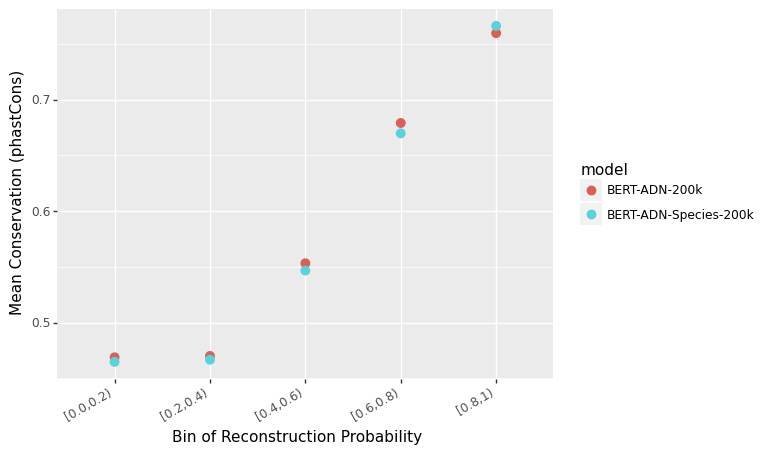

<ggplot: (1432149270513)>

In [160]:
(p9.ggplot(data=cons_df.groupby(['model','target_prb_bin'])["ce_Conservation"].mean().reset_index(), 
           mapping=p9.aes(x="target_prb_bin",y="ce_Conservation", color="model"))
 + p9.geom_point(size=3)
 + p9.labs(x="Bin of Reconstruction Probability",y="Mean Conservation (phastCons)")
 + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)

In [161]:
scipy.stats.mannwhitneyu(cons_df.query('target_prb_bin == "[0.8,1)" and model == "BERT-ADN-200k"')["ce_Conservation"],
                    cons_df.query('target_prb_bin == "[0.8,1)" and model == "BERT-ADN-Species-200k"')["ce_Conservation"])

MannwhitneyuResult(statistic=25500731468.0, pvalue=0.015558567037105498)

## TF Binding + CAGE

In [162]:
background = {"A":0.31,
              "C":0.19,
              "G":0.19,
              "T":0.31}

base_path_motif = project_path + "data/Motifs/All_PFMs/1.02/ALIGNED_ENOLOGO_FORMAT_PFMS/{}.pfm"
high_conf_pfms = {k:pd.read_csv(base_path_motif.format(v),sep="\t",header=None).sort_values(0) for k,v in zip(high_conf_motifs["Motif Name"], #.set_index(0).to_numpy()
                                                                                                              high_conf_motifs["Motif ID"])}
high_conf_pssms = {k:motifs.parse(["\t".join([str(row[ix]) for ix in range(len(row))]) for _,row in v.iterrows()],"pfm-four-rows")[0].counts.normalize().log_odds(background)
                   for k,v in high_conf_pfms.items()}

In [163]:
def match_motif_site_positional(motif = "[CA]GGGTAA", factor="Reb1",
                                    model_list = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation"],
                                    dataset = dataset):
    out_rows = []
    for model in model_list:
        if model == "Conservation":
            path = project_path+"outputs/scer_conservation_withoutstop_upstream/"
        else:
            path = paths_dict[model]
        # get prbs
        prbs = torch.load(path + "prbs.pt")[:,:4]
        targets = torch.load(path + "masked_targets.pt")
        
        match_data = find_matches_noduplicates_upstream(dataset, motif)
        print(len(match_data))
        
        # match with tss sites
        yeast_tss = (pd.read_csv(project_path+"data/Sequences/Annotation/Sequences/{}/consensusClusters.txt".format("saccharomyces_cerevisiae"),sep="\t")
           .rename(columns={"chr":"Chromosome"}))
        yeast_tss["Chromosome"] = yeast_tss["Chromosome"].str.replace("chr","")
        tss_merged = dataset.merge(yeast_tss,on="Chromosome").query('dominant_ctss > five_prime_start and dominant_ctss < five_prime_end and strand == Strand')
        tss_merged["tss_relpos"] = tss_merged.apply(lambda x: x["dominant_ctss"]-x["five_prime_start"] if x["Strand"] == "+" else 1002-((x["dominant_ctss"]-1)-x["five_prime_start"]), axis=1)
        tss_merged["implied_utr_len"] = 1003 - tss_merged["tss_relpos"]
        print(len(tss_merged))
        
        # find distance to tss sites on the same sequence
        tss_merged = tss_merged.merge(match_data, on=["Chromosome", "gene_id", "Strand", "concat_start","concat_end"])
        tss_merged["distance_to_tss"] = tss_merged["tss_relpos"] - tss_merged["match_start"]
        # replace negative values with a big positive number (so these are only kept if there is no upstream tss)
        tss_merged["distance_to_tss_noneg"] = tss_merged["distance_to_tss"].apply(lambda x: x if x > 0 else 9999+np.abs(x))
        # select the closest tss upstream
        tss_merged = tss_merged.sort_values("distance_to_tss_noneg").drop_duplicates(subset=["match_key"],keep="first") 
        print(len(tss_merged))
        
        # extract locations with binding evidence
        bind_df = pd.read_csv(project_path + "data/Binding/Pugh_ChExMix_Peaks/{}_CX.bed".format(factor),names=["Chromosome","Start","End","Name","Score","Whatever"], sep="\t")
        bind_df["Peak_Start"] = bind_df["Start"] - 10
        bind_df["Peak_End"] = bind_df["End"] + 10
        bind_df["Chromosome"] =  bind_df["Chromosome"].str.replace("chr","").apply(lambda x: arabic_to_roman[x if x[0] != "0" else x[1]])
        print("Sites: " + str(len(bind_df)))

        # match motif matches with binding data
        bind_merged = match_data.merge(bind_df,on="Chromosome").query('Peak_Start >= five_prime_start and Peak_End <= five_prime_end')
        bind_merged["Peak_relpos_start"] = bind_merged.apply(lambda x: x["Peak_Start"]-x["five_prime_start"] if x["Strand"] == "+" else 1002-((x["Peak_End"]-1)-x["five_prime_start"]), axis=1)
        bind_merged["Peak_relpos_end"] = bind_merged.apply(lambda x: x["Peak_End"]-x["five_prime_start"] if x["Strand"] == "+" else 1002-((x["Peak_Start"]-1)-x["five_prime_start"]), axis=1)
        bind_merged["peak_match"] = bind_merged.apply(lambda x: (x["match_start"] < x["Peak_relpos_end"]) and (x["match_end"] > x["Peak_relpos_start"]),axis=1).astype('int')
        # record which matches are binding
        bind_merged = bind_merged.groupby(["gene_id","concat_start","concat_end","match_key"])["peak_match"].sum().reset_index()
        binding_matches = set(bind_merged.query("peak_match > 0")["match_key"])
        tss_merged["isBinding"] = tss_merged['match_key'].isin(binding_matches)
        #print(len(match_data))

        # extract info
        for _,data_row in tss_merged.iterrows():
            pos = data_row["concat_start"]
            gene = data_row["gene_id"]
            start = data_row["match_start"]
            end = data_row["match_end"]
            dist_to_start = end - 1001
            # get metrics
            match_pos = torch.tensor(list(range(pos+start,pos+end)))
            # comupte metrics of the match
            if model == "Conservation":
                metrics = get_conservation_for_motif_site(prbs, targets, match_pos, motif)
            else:
                metrics = get_metrics_for_motif_site(prbs, targets, match_pos, motif)
            # add metadata
            metrics["motif"] = motif
            metrics["model"] = model
            metrics["match_key"] = data_row["match_key"]
            metrics["binding"] = data_row["isBinding"]
            metrics["distance_to_tss"] = data_row["distance_to_tss"]
            metrics["tss_pos"] = data_row["dominant_ctss"]
            metrics["implied_utr_len"] = data_row["implied_utr_len"]
            metrics["dist_to_start"] = dist_to_start
            metrics["gene_id"] = data_row["gene_id"]
            metrics["ce"] = metrics["cross_entropy_unambig"]
            out_rows.append(metrics)
    return pd.DataFrame(out_rows)

In [164]:
def get_pssm_scores(df, pssm, offset_left=3, offset_right=-4):
    pwm_rows = []
    for _,row in df.query('model == "Conservation"').iterrows():
        match_string = "".join([number_to_nuc[x] for x in row["targets_area"].numpy()])[offset_left:offset_right]
        #print(match_string)
        pwm_rows.append({
            "model" : "PWM",
            "binding" : row["binding"],
            "ce" : pssm.calculate(match_string),
        })
    return pd.DataFrame(pwm_rows)

### TBF1

In [130]:
tbf1_pos =  match_motif_site_positional(motif = "A[GA]CCCTA", factor = "Tbf1")

NameError: name 'match_motif_site_positional' is not defined

In [167]:
pssm_scores = get_pssm_scores(tbf1_pos, high_conf_pssms["TBF1"], offset_left=3, offset_right=-3)
tbf1_pos_pssm = pd.concat([tbf1_pos, pssm_scores])

In [129]:
tbf1_pos["distance_to_tss_neg"] = -tbf1_pos["distance_to_tss"]

p = (p9.ggplot(data=tbf1_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and (model == "BERT-ADN-Species-200k or model == "BERT-ADN-200k" or model == "m2-mixer200k")"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.5)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 + p9.coord_cartesian(ylim=(-2,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog-Likelihood of Tbf1 motif",
          color="Motif Bound by\nTbf1p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.27,0.75), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_tbf1_distance" + ".svg", width=4, height=3.0, dpi=300)

p

NameError: name 'tbf1_pos' is not defined

In [168]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(tbf1_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


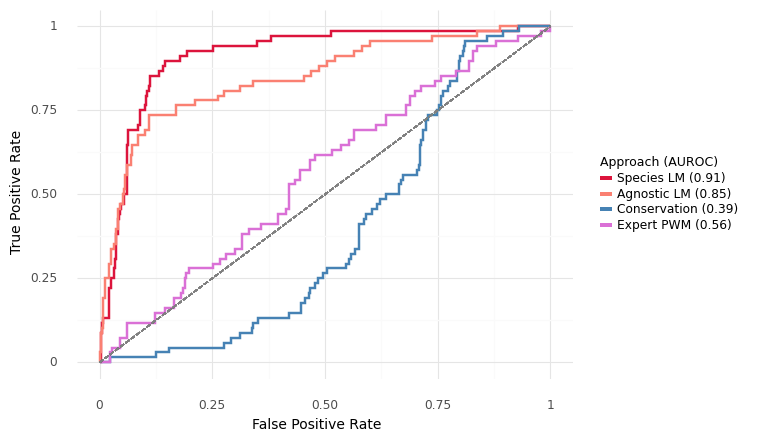

<ggplot: (1432148770289)>

In [170]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            #legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_tbf1_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### E-box

In [171]:
ebox_pos =  match_motif_site_positional(motif = "CACGTG", factor = "Cbf1")

758
8982
686
Sites: 200
758
8982
686
Sites: 200
758
8982
686
Sites: 200


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


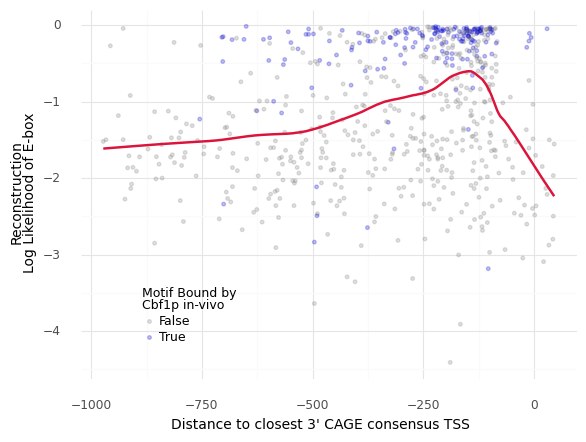

<ggplot: (1432148665483)>

In [172]:
ebox_pos["distance_to_tss_neg"] = -ebox_pos["distance_to_tss"]

p = (p9.ggplot(data=ebox_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.25)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of E-box",
          color="Motif Bound by\nCbf1p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.295,0.26), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_ebox_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [173]:
pssm_scores = get_pssm_scores(ebox_pos, high_conf_pssms["CBF1"], offset_left=3, offset_right=-4)
ebox_pos_pssm = pd.concat([ebox_pos, pssm_scores])

In [174]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(ebox_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


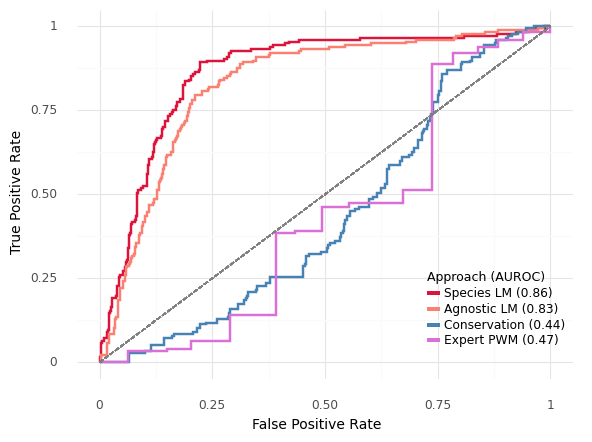

<ggplot: (1432148749523)>

In [175]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.78,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_ebox_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### REB1

In [176]:
reb1_pos =  match_motif_site_positional(motif = "[CA]GGGTAA", factor = "Reb1")

825
8982
718
Sites: 1078
825
8982
718
Sites: 1078
825
8982
718
Sites: 1078


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


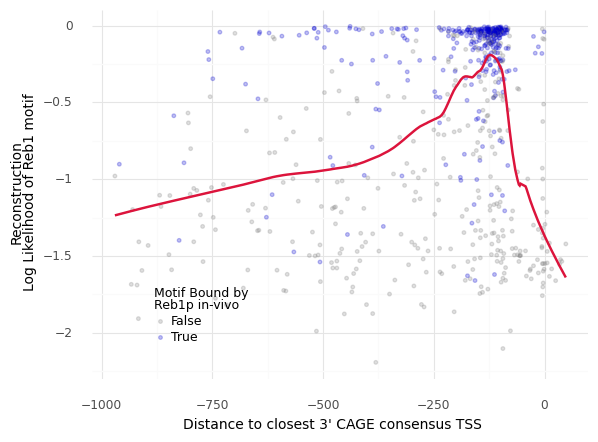

<ggplot: (1432148527782)>

In [177]:
reb1_pos["distance_to_tss_neg"] = -reb1_pos["distance_to_tss"]


p = (p9.ggplot(data=reb1_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.25)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Reb1 motif",
          color="Motif Bound by\nReb1p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.295,0.26), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_reb1_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [178]:
pssm_scores = get_pssm_scores(reb1_pos, high_conf_pssms["REB1"], offset_left=0, offset_right=-3)
reb1_pos_pssm = pd.concat([reb1_pos, pssm_scores])

In [179]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(reb1_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


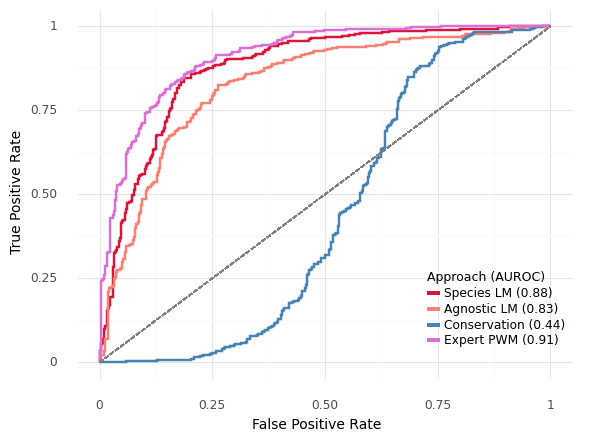

<ggplot: (1432148779204)>

In [180]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.78,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_reb1_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### UME6

In [181]:
ume6_pos =  match_motif_site_positional(motif = "TAGCCGCC", factor = "Ume6")

139
8982
122
Sites: 322
139
8982
122
Sites: 322
139
8982
122
Sites: 322


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


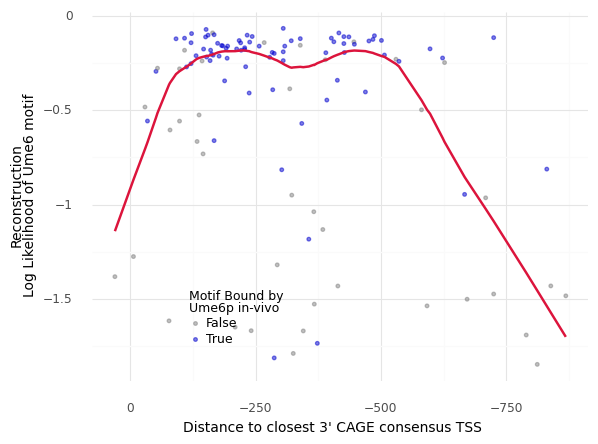

<ggplot: (1432148053995)>

In [182]:
ume6_pos["distance_to_tss_neg"] = -ume6_pos["distance_to_tss"]

p = (p9.ggplot(data=ume6_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.5)
 + p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Ume6 motif",
          color="Motif Bound by\nUme6p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.35,0.26), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_ume6_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [183]:
"".join([number_to_nuc[x] for x in ume6_pos.iloc[0]["targets_area"].numpy()])[5:-2]

'TAGCCGCCTT'

In [184]:
pssm_scores = get_pssm_scores(ume6_pos, high_conf_pssms["UME6"], offset_left=5, offset_right=-2)
ume6_pos_pssm = pd.concat([ume6_pos, pssm_scores])

In [185]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(ume6_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


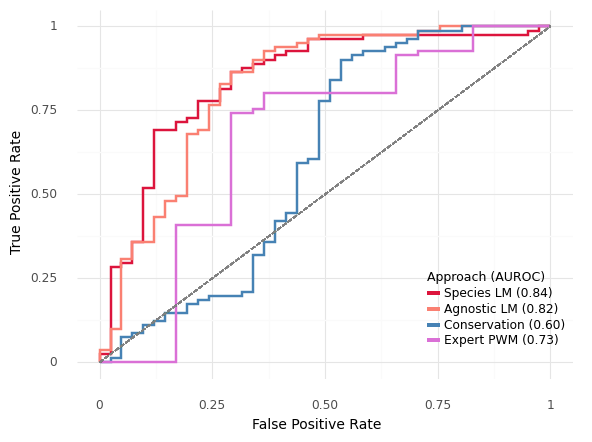

<ggplot: (1432147959974)>

In [186]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.78,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_ume6_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### FKH1

In [187]:
fkh1_pos =  match_motif_site_positional(motif = "GTAAACA", factor = "Fkh1")

641
8982
551
Sites: 625
641
8982
551
Sites: 625
641
8982
551
Sites: 625


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


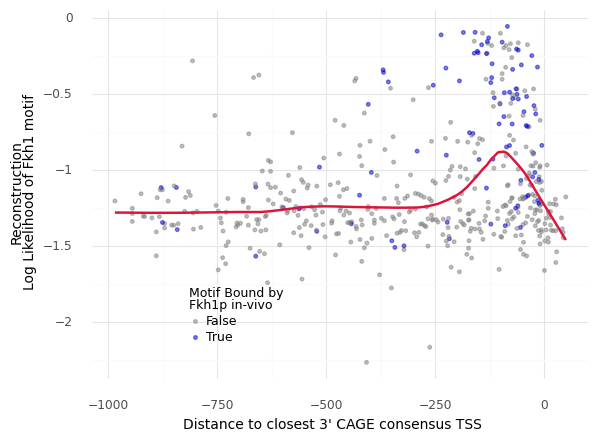

<ggplot: (1432148407528)>

In [188]:
fkh1_pos["distance_to_tss_neg"] = -fkh1_pos["distance_to_tss"]

p = (p9.ggplot(data=fkh1_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.5)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Fkh1 motif",
          color="Motif Bound by\nFkh1p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.35,0.26), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_fkh1_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [189]:
"".join([number_to_nuc[x] for x in fkh1_pos.iloc[0]["targets_area"].numpy()])[3:-1]

'AAGTAAACAAGG'

In [190]:
pssm_scores = get_pssm_scores(fkh1_pos, high_conf_pssms["FKH1"], offset_left=3, offset_right=-1)
fkh1_pos_pssm = pd.concat([fkh1_pos, pssm_scores])

In [191]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(fkh1_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


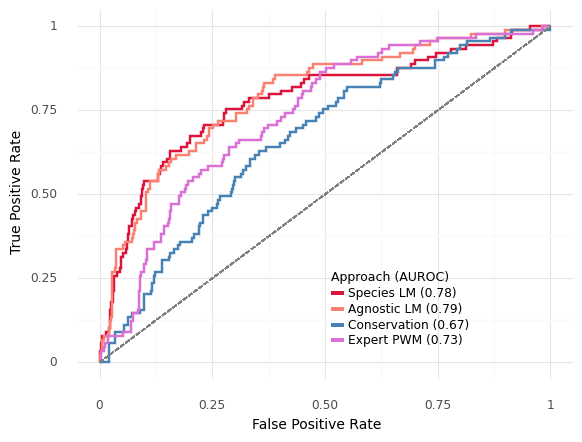

<ggplot: (1432147839684)>

In [192]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_fkh1_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### MBP1

In [193]:
mbp1_pos =  match_motif_site_positional(motif = "ACGCGT", factor = "Mbp1")

567
8982
517
Sites: 142
567
8982
517
Sites: 142
567
8982
517
Sites: 142


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


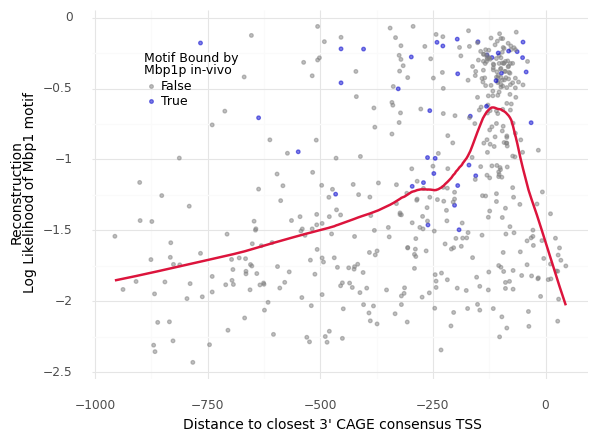

<ggplot: (1432148059886)>

In [194]:
mbp1_pos["distance_to_tss_neg"] = -mbp1_pos["distance_to_tss"]

p = (p9.ggplot(data=mbp1_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.5)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Mbp1 motif",
          color="Motif Bound by\nMbp1p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.28,0.75), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_mbp1_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [195]:
"".join([number_to_nuc[x] for x in mbp1_pos.iloc[0]["targets_area"].numpy()])[3:-2]

'GGACGCGTTG'

In [196]:
pssm_scores = get_pssm_scores(mbp1_pos, high_conf_pssms["MBP1"], offset_left=3, offset_right=-2)
mbp1_pos_pssm = pd.concat([mbp1_pos, pssm_scores])

In [197]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(mbp1_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


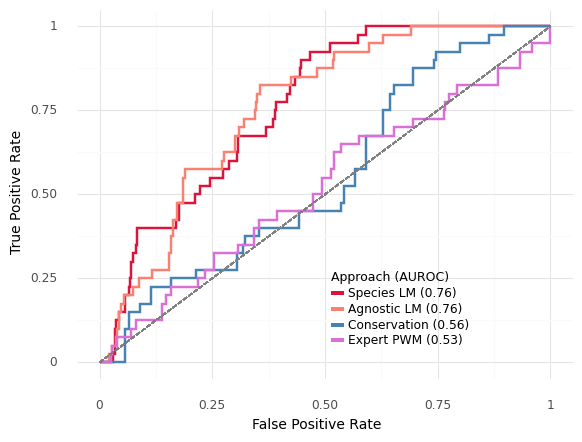

<ggplot: (1432148401201)>

In [198]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_mbp1_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### SWI4

In [199]:
swi4_pos =  match_motif_site_positional(motif = "TTCGCGT", factor = "Swi4")

207
8982
187
Sites: 149
207
8982
187
Sites: 149
207
8982
187
Sites: 149


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


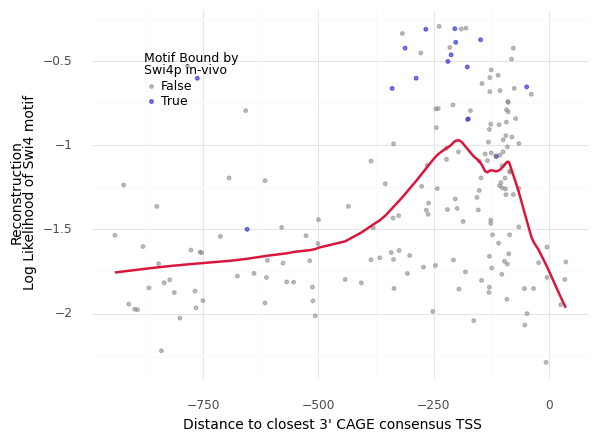

<ggplot: (1432245883254)>

In [200]:
swi4_pos["distance_to_tss_neg"] = -swi4_pos["distance_to_tss"]

p = (p9.ggplot(data=swi4_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.5)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Swi4 motif",
          color="Motif Bound by\nSwi4p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.28,0.75), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_swi4_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [201]:
"".join([number_to_nuc[x] for x in swi4_pos.iloc[0]["targets_area"].numpy()])[4:-4]

'ATTCGCGT'

In [202]:
pssm_scores = get_pssm_scores(swi4_pos, high_conf_pssms["SWI4"], offset_left=4, offset_right=-4)
swi4_pos_pssm = pd.concat([swi4_pos, pssm_scores])

In [203]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(swi4_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


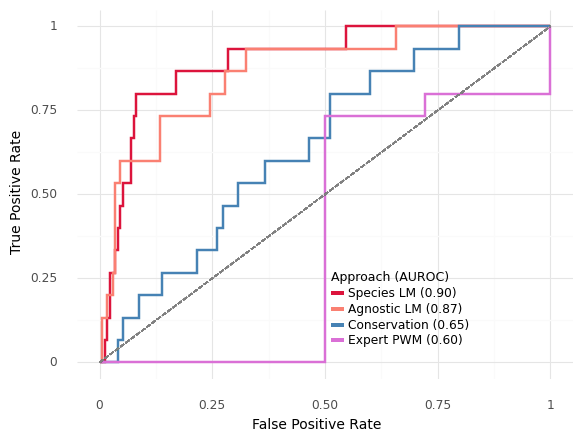

<ggplot: (1432162220424)>

In [204]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_swi4_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### STE12

In [205]:
ste12_pos =  match_motif_site_positional(motif = "TGAAACA", factor = "Ste12")

808
8982
695
Sites: 144
808
8982
695
Sites: 144
808
8982
695
Sites: 144


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


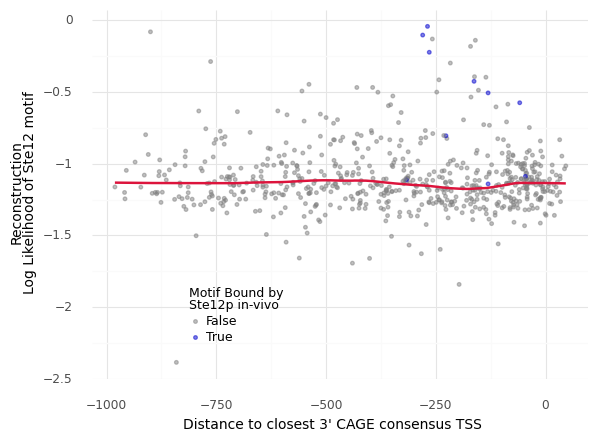

<ggplot: (1432163187899)>

In [206]:
ste12_pos["distance_to_tss_neg"] = -ste12_pos["distance_to_tss"]

p = (p9.ggplot(data=ste12_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.5)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Ste12 motif",
          color="Motif Bound by\nSte12p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.35,0.26), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_ste12_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [207]:
"".join([number_to_nuc[x] for x in ste12_pos.iloc[0]["targets_area"].numpy()])[5:-4]

'TGAAACA'

In [208]:
pssm_scores = get_pssm_scores(ste12_pos, high_conf_pssms["STE12"], offset_left=5, offset_right=-4)
ste12_pos_pssm = pd.concat([ste12_pos, pssm_scores])

In [209]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(ste12_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


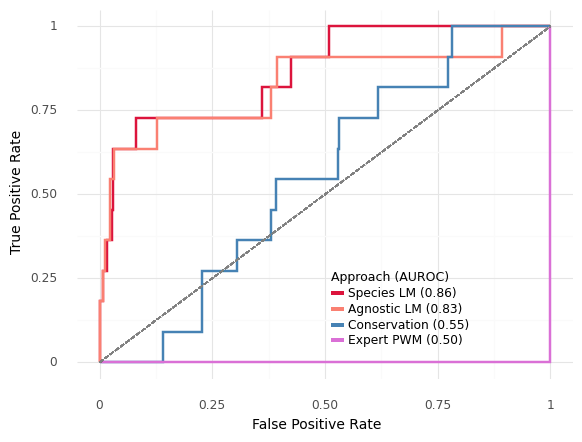

<ggplot: (1432131685295)>

In [210]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_ste12_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### NRG1

In [211]:
nrg1_pos =  match_motif_site_positional(motif = "CCCT", factor = "Nrg1")

14551
8982
12595
Sites: 81
14551
8982
12595
Sites: 81
14551
8982
12595
Sites: 81


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


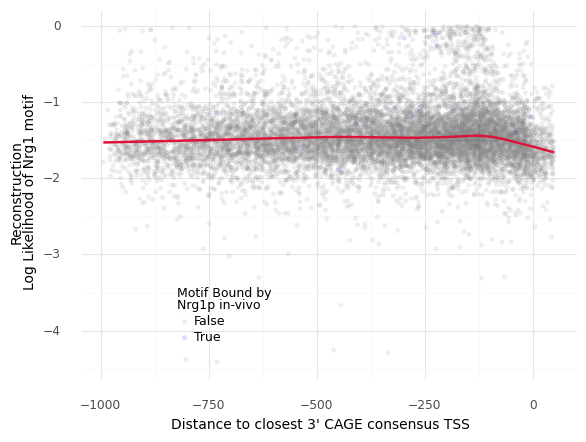

<ggplot: (1432136802693)>

In [212]:
nrg1_pos["distance_to_tss_neg"] = -nrg1_pos["distance_to_tss"]

p = (p9.ggplot(data=nrg1_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.1)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Nrg1 motif",
          color="Motif Bound by\nNrg1p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.35,0.26), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_nrg1_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [213]:
"".join([number_to_nuc[x] for x in nrg1_pos.iloc[0]["targets_area"].numpy()])[2:-1]

'TCACCCTAGA'

In [214]:
pssm_scores = get_pssm_scores(nrg1_pos, high_conf_pssms["NRG1"], offset_left=2, offset_right=-1)
nrg1_pos_pssm = pd.concat([nrg1_pos, pssm_scores])

In [215]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(nrg1_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


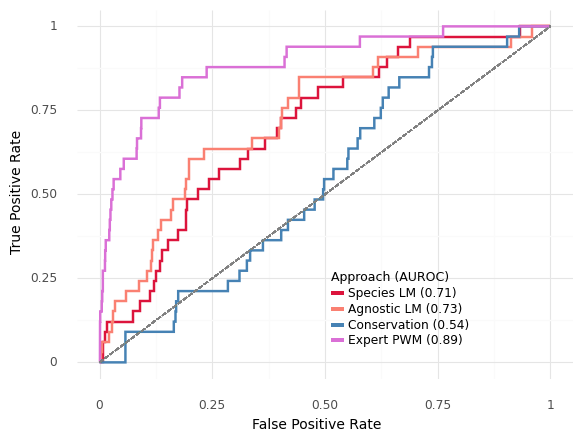

<ggplot: (1432161985783)>

In [216]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_nrg1_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### ABF1

In [217]:
abf1_pos =  match_motif_site_positional(motif = "TCA[CT].....ACG", factor = "Abf1")

911
8982
845
Sites: 724
911
8982
845
Sites: 724
911
8982
845
Sites: 724


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


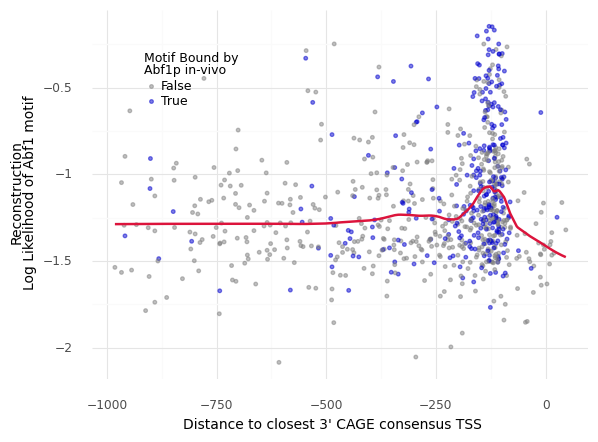

<ggplot: (1432148053983)>

In [218]:
abf1_pos["distance_to_tss_neg"] = -abf1_pos["distance_to_tss"]

p = (p9.ggplot(data=abf1_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.5)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Abf1 motif",
          color="Motif Bound by\nAbf1p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.28,0.75), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_ste12_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [219]:
"".join([number_to_nuc[x] for x in abf1_pos.iloc[0]["targets_area"].numpy()])[2:-1]

'AAGTCATCTGGCACGTTT'

In [220]:
pssm_scores = get_pssm_scores(abf1_pos, high_conf_pssms["ABF1"], offset_left=2, offset_right=-1)
abf1_pos_pssm = pd.concat([abf1_pos, pssm_scores])

In [221]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(abf1_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


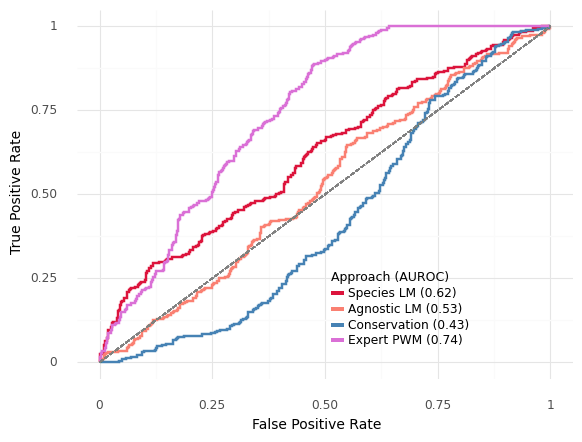

<ggplot: (1432148511543)>

In [222]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_abf1_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### YRR1

In [223]:
yrr1_pos =  match_motif_site_positional(motif = "CGGA..T", factor = "Yrr1")

3316
8982
2798
Sites: 139
3316
8982
2798
Sites: 139
3316
8982
2798
Sites: 139


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


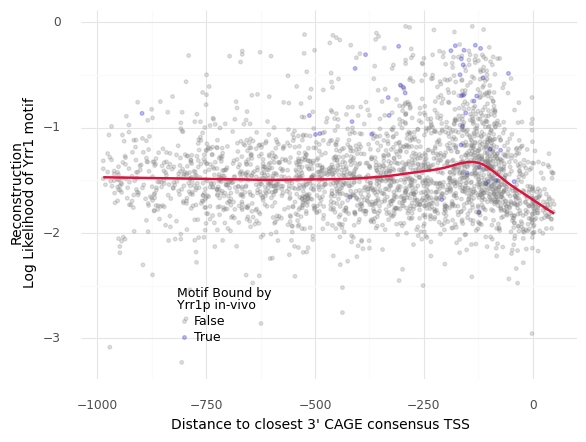

<ggplot: (1432162626398)>

In [224]:
yrr1_pos["distance_to_tss_neg"] = -yrr1_pos["distance_to_tss"]

p = (p9.ggplot(data=yrr1_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.25)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Yrr1 motif",
          color="Motif Bound by\nYrr1p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.35,0.26), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_yrr1_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [225]:
"".join([number_to_nuc[x] for x in yrr1_pos.iloc[0]["targets_area"].numpy()])[4:-2]

'GCGGAAATTT'

In [226]:
pssm_scores = get_pssm_scores(yrr1_pos, high_conf_pssms["YRR1"], offset_left=4, offset_right=-2)
yrr1_pos_pssm = pd.concat([yrr1_pos, pssm_scores])

In [227]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(yrr1_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


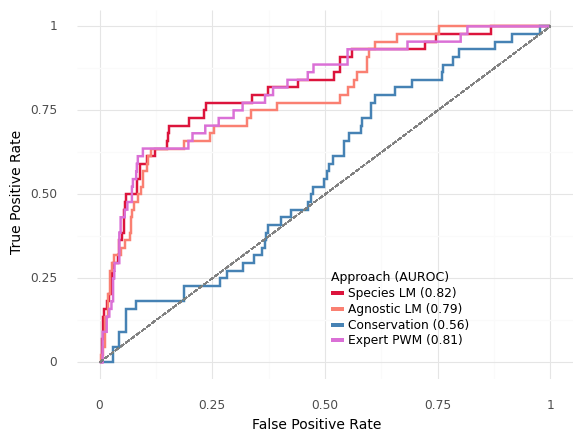

<ggplot: (1432130093303)>

In [228]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_yrr1_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### GCN4

In [229]:
gcn4_pos =  match_motif_site_positional(motif = "TGA[CG]TCA", factor = "Gcn4")

526
8982
457
Sites: 49
526
8982
457
Sites: 49
526
8982
457
Sites: 49


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


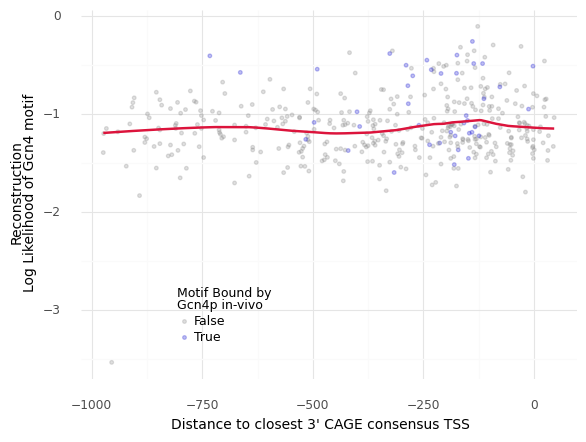

<ggplot: (1432147896640)>

In [230]:
gcn4_pos["distance_to_tss_neg"] = -gcn4_pos["distance_to_tss"]

p = (p9.ggplot(data=gcn4_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.25)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Gcn4 motif",
          color="Motif Bound by\nGcn4p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.35,0.26), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_gcn4_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [231]:
"".join([number_to_nuc[x] for x in gcn4_pos.iloc[0]["targets_area"].numpy()])[4:-4]

'CTGAGTCA'

In [232]:
pssm_scores = get_pssm_scores(gcn4_pos, high_conf_pssms["GCN4"], offset_left=4, offset_right=-4)
gcn4_pos_pssm = pd.concat([gcn4_pos, pssm_scores])

In [233]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(gcn4_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


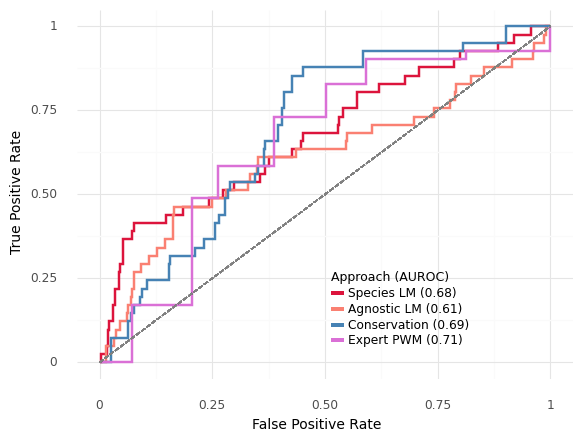

<ggplot: (1432162630208)>

In [234]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_gcn4_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### BAS1

In [235]:
bas1_pos =  match_motif_site_positional(motif = "GAGTCA", factor = "Bas1")

960
8982
814
Sites: 97
960
8982
814
Sites: 97
960
8982
814
Sites: 97


/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


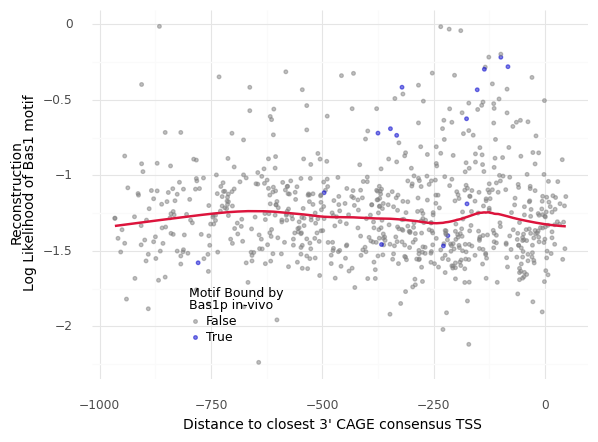

<ggplot: (1432147842446)>

In [236]:
bas1_pos["distance_to_tss_neg"] = -bas1_pos["distance_to_tss"]

p = (p9.ggplot(data=bas1_pos.query('distance_to_tss < 1000 and distance_to_tss > -50 and model == "BERT-ADN-Species-200k"'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="binding"))
 + p9.geom_point(size=1, alpha = 0.5)
 #+ p9.scale_x_reverse()
 + p9.scale_color_manual(values=["grey","mediumblue"])
 #+ p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")
 + p9.labs(x="Distance to closest 3' CAGE consensus TSS",
           y="Reconstruction\nLog Likelihood of Bas1 motif",
          color="Motif Bound by\nBas1p in-vivo\n")
 #+ p9.facet_wrap('~ species_short', nrow=2)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.35,0.26), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)
#p.save("../Graphics/Paper/TF_bas1_distance" + ".svg", width=4, height=3.0, dpi=300)

p

In [237]:
"".join([number_to_nuc[x] for x in bas1_pos.iloc[0]["targets_area"].numpy()])[5:-4]

'GAGTCA'

In [238]:
pssm_scores = get_pssm_scores(bas1_pos, high_conf_pssms["BAS1"], offset_left=5, offset_right=-4)
bas1_pos_pssm = pd.concat([bas1_pos, pssm_scores])

In [239]:
roc_dict = {}
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation","PWM"]:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(bas1_pos_pssm, "ce", model, label_col="binding")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation
PWM


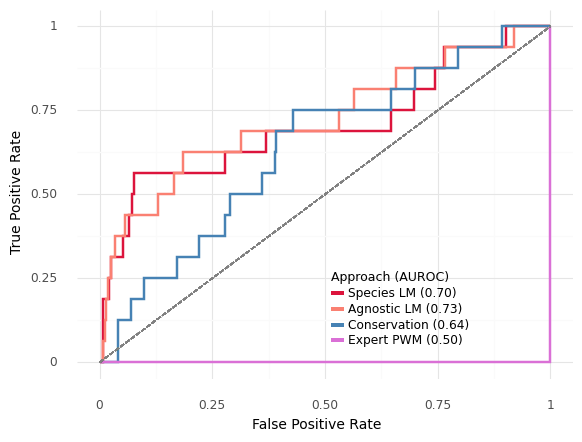

<ggplot: (1432147396816)>

In [240]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    "PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.63,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/TF_bas1_roc" + ".svg", width=3, height=3.0, dpi=300)

p

## Biases vis a vis TSS

In [56]:
def bias_positional(dataset = dataset, model = "BERT-ADN-Species-200k"):
    out_rows = []
    path = paths_dict[model]
    # get prbs
    prbs = torch.load(path + "prbs.pt")[:,:4]
    targets = torch.load(path + "masked_targets.pt")

    # match with tss sites
    yeast_tss = (pd.read_csv(project_path+"data/Sequences/Annotation/Sequences/{}/consensusClusters.txt".format("saccharomyces_cerevisiae"),sep="\t")
       .rename(columns={"chr":"Chromosome"}))
    yeast_tss["Chromosome"] = yeast_tss["Chromosome"].str.replace("chr","")
    tss_merged = dataset.merge(yeast_tss,on="Chromosome").query('dominant_ctss > five_prime_start and dominant_ctss < five_prime_end and strand == Strand')
    tss_merged["tss_relpos"] = tss_merged.apply(lambda x: x["dominant_ctss"]-x["five_prime_start"] if x["Strand"] == "+" else 1002-((x["dominant_ctss"]-1)-x["five_prime_start"]), axis=1)
    tss_merged["implied_utr_len"] = 1003 - tss_merged["tss_relpos"]
    print(len(tss_merged))

    # for each gene, find the most 3' TSS
    tss_merged = tss_merged.query('implied_utr_len > 4').sort_values("implied_utr_len").drop_duplicates(subset=["gene_id"],keep="first") 
    print(len(tss_merged))
    
    out_dfs = []
    for _, data_row in tss_merged.iterrows():
        pos = data_row["concat_start"]
        end_pos = data_row["concat_end"]
        gene = data_row["gene_id"]
        # get distances to the annotated TSS
        dist_to_tss =  np.arange(0,end_pos-pos) - data_row["tss_relpos"]
        # get metrics
        match_position = list(range(pos,end_pos))
        prbs_match = prbs[torch.tensor(match_position),:]
        targets_match = targets[torch.tensor(match_position)]
        target_prbs = (torch.nn.functional.one_hot(targets_match, num_classes=4)*prbs_match).max(axis=1)[0]
        out_dfs.append(pd.DataFrame({
            "model":model,
            "distance_to_start":-np.arange(-3,1000)[::-1],
            "distance_to_tss":dist_to_tss,
            "target_prbs": target_prbs,
            "prbs_AT": prbs_match[:,0] + prbs_match[:,3],
            "acc": prbs_match.argmax(axis=1) == targets_match,
            "targets":targets_match,
            "preds":prbs_match.argmax(axis=1),
            "prbs_A":prbs_match[:,0],
            "prbs_C":prbs_match[:,1],
            "prbs_G":prbs_match[:,2],
            "prbs_T":prbs_match[:,3],
        }))
    return tss_merged, pd.concat(out_dfs)

In [57]:
tss_merged, pos_bias = bias_positional()

UndefinedVariableError: name 'five_prime_start' is not defined

In [243]:
pos_bias

model  distance_to_start  distance_to_tss  target_prbs   
0     BERT-ADN-Species-200k               -999             -998     0.345548  \
1     BERT-ADN-Species-200k               -998             -997     0.341542   
2     BERT-ADN-Species-200k               -997             -996     0.104999   
3     BERT-ADN-Species-200k               -996             -995     0.327323   
4     BERT-ADN-Species-200k               -995             -994     0.400787   
...                     ...                ...              ...          ...   
998   BERT-ADN-Species-200k                 -1              996     0.282438   
999   BERT-ADN-Species-200k                  0              997     0.182334   
1000  BERT-ADN-Species-200k                  1              998     0.998335   
1001  BERT-ADN-Species-200k                  2              999     0.999979   
1002  BERT-ADN-Species-200k                  3             1000     0.999790   

       prbs_AT    acc  targets  preds    prbs_A    prbs_C    prbs_G    prbs_T  
0     0.590339   True        3      3  0.244791  0.245472  0.164189  0.345548  
1     0.659270   True        0      0  0.341542  0.162889  0.177840  0.317728  
2     0.700668  False        1      0  0.361219  0.104999  0.194334  0.339449  
3     0.599647   True        3      3  0.272325  0.227430  0.172923  0.327323  
4     0.692111   True        3      3  0.291323  0.169697  0.138192  0.400787  
...        ...    ...      ...    ...       ...       ...       ...       ...  
998   0.676472  False        3      0  0.394034  0.185281  0.138247  0.282438  
999   0.648434  False        2      0  0.376665  0.169232  0.182334  0.271769  
1000  0.999278   True        0      0  0.998335  0.000488  0.000234  0.000943  
1001  0.999989   True        3      3  0.000010  0.000008  0.000003  0.999979  
1002  0.000160   True        2      2  0.000086  0.000050  0.999790  0.000074  

[5597743 rows x 12 columns]

In [244]:
pos_bias["true_bias"] = (pos_bias["targets"] == 0).astype('int') + (pos_bias["targets"] == 3).astype('int')

pos_bias["true_A"] = (pos_bias["targets"] == 0).astype('int')
pos_bias["true_T"] = (pos_bias["targets"] == 3).astype('int')


In [245]:
tss_merged["tss_relpos"].median()

951.0

In [246]:
cols = ["target_prbs","acc","prbs_AT","true_bias","prbs_A","true_A","prbs_T","true_T"]

tss_biases_grouped = pos_bias.groupby('distance_to_tss')[cols].mean().reset_index()
tss_biases_se = pos_bias.groupby('distance_to_tss')[cols].sem().reset_index().rename(columns={col:col+"_se" for col in cols})
tss_biases_grouped = tss_biases_grouped.merge(tss_biases_se, on="distance_to_tss")
tss_biases_grouped = tss_biases_grouped.dropna()
tss_biases_grouped["target_prbs_high"] = tss_biases_grouped["target_prbs"] + (tss_biases_grouped["target_prbs_se"] * 2)
tss_biases_grouped["target_prbs_low"] = tss_biases_grouped["target_prbs"] - (tss_biases_grouped["target_prbs_se"] * 2)
tss_biases_grouped["acc_high"] = tss_biases_grouped["acc"] + (tss_biases_grouped["acc_se"] * 2)
tss_biases_grouped["acc_low"] = tss_biases_grouped["acc"] - (tss_biases_grouped["acc_se"] * 2)

In [247]:
tss_biases_grouped

distance_to_tss  target_prbs       acc   prbs_AT  true_bias    prbs_A   
0                -998     0.319967  0.500000  0.591819   0.833333  0.310580  \
1                -997     0.278399  0.382979  0.622494   0.659574  0.307626   
2                -996     0.287390  0.369863  0.625263   0.630137  0.301573   
3                -995     0.272366  0.250000  0.618681   0.541667  0.300503   
4                -994     0.288470  0.416058  0.620663   0.656934  0.303626   
...               ...          ...       ...       ...        ...       ...   
1993              995     0.521257  0.400000  0.779294   0.600000  0.210928   
1994              996     0.726627  0.800000  0.459388   0.600000  0.349021   
1995              997     0.727393  0.666667  0.882789   0.666667  0.458856   
1996              998     0.999352  1.000000  0.666484   0.666667  0.332809   
1997              999     0.999907  1.000000  0.500056   0.500000  0.000039   

        true_A    prbs_T    true_T  target_prbs_se  ...  prbs_AT_se   
0     0.416667  0.281239  0.416667        0.035533  ...    0.028133  \
1     0.361702  0.314867  0.297872        0.012787  ...    0.009896   
2     0.328767  0.323690  0.301370        0.012296  ...    0.007861   
3     0.270833  0.318177  0.270833        0.010169  ...    0.007150   
4     0.270073  0.317038  0.386861        0.007327  ...    0.006458   
...        ...       ...       ...             ...  ...         ...   
1993  0.000000  0.568367  0.600000        0.196753  ...    0.090533   
1994  0.400000  0.110367  0.200000        0.166792  ...    0.198186   
1995  0.333333  0.423933  0.333333        0.272530  ...    0.117177   
1996  0.333333  0.333675  0.333333        0.000513  ...    0.333149   
1997  0.000000  0.500017  0.500000        0.000072  ...    0.499933   

      true_bias_se  prbs_A_se  true_A_se  prbs_T_se  true_T_se   
0         0.112367   0.015151   0.148647   0.025442   0.148647  \
1         0.069866   0.010001   0.070845   0.007827   0.067429   
2         0.056895   0.008059   0.055362   0.010184   0.054076   
3         0.051120   0.007005   0.045593   0.008675   0.045593   
4         0.040708   0.005638   0.038072   0.005457   0.041763   
...            ...        ...        ...        ...        ...   
1993      0.244949   0.087367   0.000000   0.176305   0.244949   
1994      0.244949   0.182108   0.244949   0.067085   0.200000   
1995      0.333333   0.291547   0.333333   0.298503   0.333333   
1996      0.333333   0.332763   0.333333   0.333151   0.333333   
1997      0.500000   0.000029   0.000000   0.499962   0.500000   

      target_prbs_high  target_prbs_low  acc_high       acc_low  
0             0.391032         0.248901  0.801511  1.984887e-01  
1             0.303972         0.252825  0.526326  2.396318e-01  
2             0.311982         0.262797  0.483652  2.560736e-01  
3             0.292705         0.252028  0.338852  1.611477e-01  
4             0.303124         0.273815  0.500591  3.315262e-01  
...                ...              ...       ...           ...  
1993          0.914764         0.127750  0.889898 -8.989795e-02  
1994          1.060211         0.393043  1.200000  4.000000e-01  
1995          1.272452         0.182334  1.333333 -1.110223e-16  
1996          1.000378         0.998327  1.000000  1.000000e+00  
1997          1.000051         0.999763  1.000000  1.000000e+00  

[1998 rows x 21 columns]

In [248]:
tss_biases_a = tss_biases_grouped[["distance_to_tss","prbs_A","true_A"]].rename(columns={"prbs_A":"A (Predicted)","true_A":"A (Actual)"}).melt(id_vars="distance_to_tss")
#tss_biases_a["nt"] = "A"
tss_biases_t = tss_biases_grouped[["distance_to_tss","prbs_T","true_T"]].rename(columns={"prbs_T":"T (Predicted)","true_T":"T (Actual)"}).melt(id_vars="distance_to_tss")
#tss_biases_t["nt"] = "T"

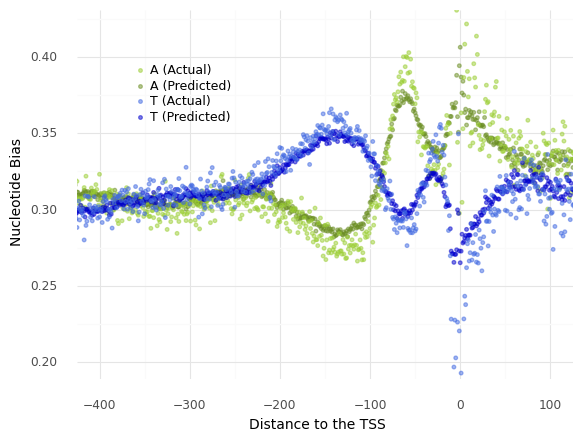

<ggplot: (1432162835255)>

In [249]:
p = (p9.ggplot(data=pd.concat([tss_biases_a,tss_biases_t]), 
           mapping=p9.aes(x="distance_to_tss",y="value",color="variable"))
 + p9.geom_point(size=1, alpha = 0.5, raster = True)
 + p9.coord_cartesian(xlim=(-400,100),ylim=(0.2,0.42))
 #+ p9.geom_smooth(method="lowess", color="blue")
 + p9.scale_color_manual(values=["yellowgreen","olivedrab","royalblue", "mediumblue"])
 + p9.labs(x="Distance to the TSS",y="Nucleotide Bias", color="")
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9),
            legend_position=(0.29,0.725), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)

#p.save("../Graphics/Paper/MotifContext_tss" + ".svg", width=8.5, height=2.0, dpi=300)

p

## Gene Bias

In [58]:
rp_genes = "YGR214w YLR048w YLR441c YML063w YGL123w YNL178w YJR145c YHR203c YJR123w YPL090c YBR181c YOR096w YNL096c YBL072c YER102w YPL081w YBR189w YOR293w YMR230w YDR025w YBR048w  YOR369c  YDR064w  YCR031c  YJL191w  YOL040c  YMR143w YDL083c  YML024w YDR447c YDR450w YML026c YOL121c YNL302c YHL015w YKR057w YJL136c YJL190c YLR367w YGR118w YPR132w YER074w  YIL069c YGR027c YLR333c  YGL189c YER131w YKL156w YHR021c YOR167c  YLR264w YPL220w YGL135w YFR031c-a YIL018w YOR063w YBR031w YDR012w YPL131w YML073c YLR448w YGL076c YPL198w YHL033c YLL045c YGL147c YNL067w YLR075w YPR102c YGR085c YEL054c YDR418w YDL082w YMR142c YKL006w YHL001w YLR029c YMR121c YIL133c YNL069c YKL180w YJL177w YOL120c YNL301c YBR084c-a YBL027w YMR242c YOR312c YBR191w YPL079w YLR061w YFL034c-a YDL081c YDL130w YOL039w YDR382w YLR388w YDL061c YLR287c-a YOR182c YLR167w YLR340w YBL087c YER117w YGL031c YGR148c YOL127w YLR344w YGR034w YHR010w YDR471w YGL103w YFR032c-a YGL030w YDL075w YLR406c YBL092w YPL143w YOR234c YER056c-a YIL052c YDL191w YDL136w YMR194w YPL249c-a YLR185w YDR500c YLR325c YJL189w YIL148w YKR094c YDL184c YDL133c-a YNL162w YHR141c YPR043w YJR094w-a".upper().split(" ")
rp_genes = [x for x in rp_genes if len(x) > 0]


In [59]:
def locate_bind_site_rel_module(model, dataset = dataset, motif = "CA.CC.TACAT", target_genes = rp_genes):
    if model == "Conservation":
        path = project_path+"outputs/scer_conservation_withoutstop_upstream/"
    else:
        path = paths_dict[model]
    # get prbs
    prbs = torch.load(path + "prbs.pt")[:,:4]
    targets = torch.load(path + "masked_targets.pt")
    # get sequences and find matches to consensus motif
    match_data = find_matches_noduplicates_upstream(dataset, motif)
    out_rows = []
    for _,data_row in match_data.iterrows():
        pos = data_row["concat_start"]
        gene = data_row["gene_id"]
        start = data_row["match_start"]
        end = data_row["match_end"]
        dist_to_start = end - 1001
        # get metrics
        match_pos = torch.tensor(list(range(pos+start,pos+end)))
        # comupte metrics of the match
        if model == "Conservation":
            metrics = get_conservation_for_motif_site(prbs, targets, match_pos, motif)
        else:
            metrics = get_metrics_for_motif_site(prbs, targets, match_pos, motif)
        # add metadata
        metrics["model"] = model
        metrics["in_module"] = gene in target_genes
        metrics["ce"] = metrics["cross_entropy_unambig"]
        out_rows.append(metrics)
    return pd.DataFrame(out_rows)

### RAP1 in RP module

In [252]:
tf_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation"]

for model in roc_models:
    tf_dfs.append(locate_bind_site_rel_module(model, motif="CA[TC]CC[GA]TACA[TC]", target_genes=rp_genes)) 

In [253]:
tf_roc = pd.concat(tf_dfs)

In [254]:
tf_roc.query('model == "Conservation"')["in_module"].sum()/len(tf_roc.query('model == "Conservation"'))

0.6363636363636364

In [255]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(tf_roc, "ce", model, label_col="in_module")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation


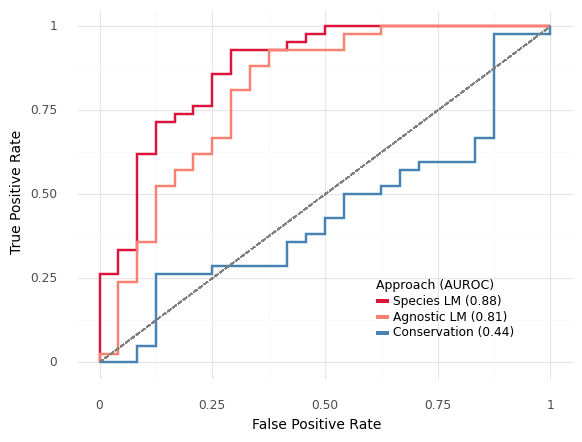

<ggplot: (1432147896790)>

In [256]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    #"PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.7,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/Module_Rap1_roc" + ".svg", width=3, height=3.0, dpi=300)

p

### RRPE in Ribo Biogenesis

In [257]:
ribo_bio_genes = set(pd.concat([pd.read_csv(project_path+"data/Evo/ribosome_biogenesis_annotations_manual.txt",sep="\t"),
                    pd.read_csv(project_path+"data/Evo/ribosome_biogenesis_annotation_computational.txt",sep="\t")])["Systematic Name/Complex Accession"])

In [258]:
len(ribo_bio_genes)

197

In [259]:
tf_dfs = []

roc_models = ["BERT-ADN-200k","BERT-ADN-Species-200k","Conservation"]

for model in roc_models:
    tf_dfs.append(locate_bind_site_rel_module(model, motif="AATTTTTCA", target_genes=ribo_bio_genes)) 

In [260]:
tf_roc = pd.concat(tf_dfs)

In [261]:
tf_roc.query('model == "BERT-ADN-Species-200k"')['accuracy'].mean()

0.8362118657388835

In [262]:
tf_roc.query('model == "Conservation"')["in_module"].sum()/len(tf_roc.query('model == "Conservation"'))

0.11658031088082901

In [263]:
roc_dict = {}
for model in roc_models:
    fpr, tpr, prec, rec, roc_auc, auprc, var = get_roc(tf_roc, "ce", model, label_col="in_module")
    roc_dict[model] = {"fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "roc_auc":roc_auc, "auprc":auprc, "var":var}

BERT-ADN-200k
BERT-ADN-Species-200k
Conservation


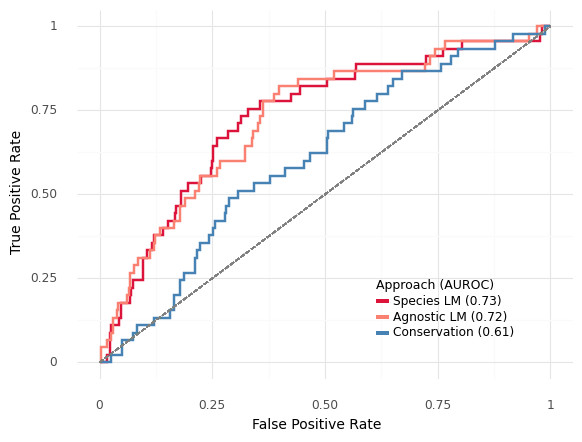

<ggplot: (1432148610383)>

In [264]:
roc_plot_df = pd.DataFrame(roc_dict).T[["fpr","tpr", "roc_auc" ,"auprc" ,"var"]].explode(["fpr","tpr"]).reset_index()
roc_plot_df[["tpr","fpr"]] = roc_plot_df[["tpr","fpr"]].astype('float')

roc_relabeller = {
    "BERT-ADN-Species-200k":"Species LM ({:2.2f})".format(roc_dict["BERT-ADN-Species-200k"]["roc_auc"]),
    "BERT-ADN-200k":"Agnostic LM ({:2.2f})".format(roc_dict["BERT-ADN-200k"]["roc_auc"]),
    "Conservation":"Conservation ({:2.2f})".format(roc_dict["Conservation"]["roc_auc"]),
    #"PWM":"Expert PWM ({:2.2f})".format(roc_dict["PWM"]["roc_auc"]),
}

roc_plot_df["index"] = roc_plot_df["index"].apply(lambda x: roc_relabeller[x])
roc_plot_df["index"] = pd.Categorical(roc_plot_df["index"], categories = roc_relabeller.values())

#df_abline = pd.DataFrame({"tpr":np.arange(0,1,1000),"fpr":np.arange(0,1,1000)})

p = (p9.ggplot(data=roc_plot_df, 
           mapping=p9.aes(x="fpr",y="tpr", color="index"))
 + p9.geom_step(size=1)
 + p9.labs(x="False Positive Rate",y="True Positive Rate", 
           #title="Classifying if a TGTAAATA instance is within the 3'UTR",
          color="Approach (AUROC)")
 #+ p9.scale_color_manual(values=["salmon","steelblue","black"])
 + p9.scale_color_manual(values=["crimson","salmon","steelblue", "orchid"])
 + p9.geom_segment(linetype="dashed", mapping=p9.aes(x=0,xend=1,y=0,yend=1), color="grey",size=0.5)
 + p9.coord_cartesian(xlim=(0,1),ylim=(0,1))
 + p9.theme_minimal()
 + p9.theme(#legend_background=p9.element_blank(), 
            legend_key_size=9,
            legend_title=p9.element_text(size=9),
            axis_title=p9.element_text(size=10),
            legend_position=(0.7,0.26), 
            legend_direction='vertical')
)
#p.save("../Graphics/Paper/Module_Rrpe_roc" + ".svg", width=3, height=3.0, dpi=300)

p

## Evo

In [265]:
def load_species_upstream_dataset(species):
    dataset = pd.read_parquet(project_path+"data/Sequences/Annotation/Sequences/{}/{}_five_prime.parquet".format(species,species))
    dataset = dataset.loc[~dataset['five_prime_seq'].str.contains("N")]
    # determine positions in concatenated data
    start = 0
    starts = []
    stops = []
    for _,row in dataset.iterrows():
        starts.append(start)
        stops.append(start + len(row["five_prime_seq"]))
        start = start + len(row["five_prime_seq"]) 
    dataset["concat_start"] = starts
    dataset["concat_end"] = stops
    # throw out short sequences
    dataset = dataset.loc[dataset["five_prime_seq"].str.len() == 1003]
    return dataset


species_to_path_dict = {
    "agaricus_bisporus_var_burnettii_jb137_s8_gca_000300555":project_path+"outputs/bertadn_origtest_convolved_prb_agaricus_bisporus_var_burnettii_jb137_s8_gca_000300555_agaricus_upstream_1024_withoutstop/",
    
    "schizosaccharomyces_pombe":project_path+'outputs/bertadn_origtest_convolved_prb_schizosaccharomyces_pombe_pombe_upstream_1024_withoutstop/',
    "schizosaccharomyces_japonicus":project_path+"outputs/bertadn_origtest_convolved_prb_schizosaccharomyces_japonicus_japonicus_upstream_1024_withoutstop/",
    "schizosaccharomyces_cryophilus":project_path+"outputs/bertadn_origtest_convolved_prb_schizosaccharomyces_cryophilus_cryophilus_upstream_1024_withoutstop/",
    "schizosaccharomyces_octosporus":project_path+"outputs/bertadn_origtest_convolved_prb_schizosaccharomyces_octosporus_octosporus_upstream_1024_withoutstop/",
    
    "saitoella_complicata_nrrl_y_17804_gca_000227095":project_path+"outputs/bertadn_origtest_convolved_prb_saitoella_complicata_nrrl_y_17804_gca_000227095_saitoella_complicata_upstream_1024_withoutstop/",
    "pneumocystis_jirovecii_ru7_gca_001477535":project_path+"outputs/bertadn_origtest_convolved_prb_pneumocystis_jirovecii_ru7_gca_001477535_pneumocystis_jirovecii_upstream_1024_withoutstop/",
    "terfezia_boudieri_atcc_mya_4762_gca_003788615":project_path+"outputs/bertadn_origtest_convolved_prb_terfezia_boudieri_atcc_mya_4762_gca_003788615_terfezia_boudieri_upstream_1024_withoutstop/",
    "magnaporthe_poae":project_path+"outputs/bertadn_origtest_convolved_prb_magnaporthe_poae_magnaporthe_poae_upstream_1024_withoutstop/",
    "ascodesmis_nigricans_gca_004786065":project_path+"outputs/bertadn_origtest_convolved_prb_ascodesmis_nigricans_gca_004786065_ascodesmis_nigricans_upstream_1024_withoutstop/",
    
    "aspergillus_fumigatus":project_path+"outputs/bertadn_origtest_convolved_prb_aspergillus_fumigatus_fumigatus_upstream_1024_withoutstop/",
    "aspergillus_clavatus":project_path+"outputs/bertadn_origtest_convolved_prb_aspergillus_clavatus_clavatus_upstream_1024_withoutstop/",
    "aspergillus_nidulans":project_path+'outputs/bertadn_origtest_convolved_prb_aspergillus_nidulans_nidulans_upstream_1024_withoutstop/',
    "aspergillus_oryzae":project_path+"outputs/bertadn_origtest_convolved_prb_aspergillus_oryzae_oryzae_upstream_1024_withoutstop/",
    
    "cordyceps_militaris_cm01_gca_000225605":project_path+"outputs/bertadn_origtest_convolved_prb_cordyceps_militaris_cm01_gca_000225605_cordyceps_upstream_1024_withoutstop/",
    "neurospora_crassa":project_path+'outputs/bertadn_origtest_convolved_prb_neurospora_crassa_crassa_upstream_1024_withoutstop/',
    "neurospora_tetrasperma_fgsc_2509_gca_000213195":project_path+"outputs/bertadn_origtest_convolved_prb_neurospora_tetrasperma_fgsc_2509_gca_000213195_neurospora_tetrasperma_upstream_1024_withoutstop/",
    
    "lipomyces_starkeyi_nrrl_y_11557_gca_001661325":project_path+"outputs/bertadn_origtest_convolved_prb_lipomyces_starkeyi_nrrl_y_11557_gca_001661325_lipomyces_upstream_1024_withoutstop/",
    "sugiyamaella_lignohabitans_gca_001640025":project_path+"outputs/bertadn_origtest_convolved_prb_sugiyamaella_lignohabitans_gca_001640025_sugiyamaella_upstream_1024_withoutstop/",
    "nadsonia_fulvescens_var_elongata_dsm_6958_gca_001661315":project_path+'outputs/bertadn_origtest_convolved_prb_nadsonia_fulvescens_var_elongata_dsm_6958_gca_001661315_nadsonia_upstream_1024_withoutstop/',
    "tortispora_caseinolytica_nrrl_y_17796_gca_001661475":project_path+'outputs/bertadn_origtest_convolved_prb_tortispora_caseinolytica_nrrl_y_17796_gca_001661475_tortispora_upstream_1024_withoutstop/',
    "yarrowia_lipolytica":project_path+"outputs/bertadn_origtest_convolved_prb_yarrowia_lipolytica_yarrowia_upstream_1024_withoutstop/",
    "wickerhamiella_sorbophila_gca_002251995":project_path+"outputs/bertadn_origtest_convolved_prb_wickerhamiella_sorbophila_gca_002251995_wickerhamiella_upstream_1024_withoutstop/",
    
    
    "kuraishia_capsulata_cbs_1993_gca_000576695":project_path+"outputs/bertadn_origtest_convolved_prb_kuraishia_capsulata_cbs_1993_gca_000576695_kuraishia_upstream_1024_withoutstop/",
    "pichia_membranifaciens_nrrl_y_2026_gca_001661235":project_path+"outputs/bertadn_origtest_convolved_prb_pichia_membranifaciens_nrrl_y_2026_gca_001661235_pichia_membranifaciens_upstream_1024_withoutstop/",
    "pichia_kudriavzevii_gca_001983325":project_path+"outputs/bertadn_origtest_convolved_prb_pichia_kudriavzevii_gca_001983325_pichia_upstream_1024_withoutstop/",
    "komagataella_pastoris":project_path+"outputs/bertadn_origtest_convolved_prb_komagataella_pastoris_komagataella_upstream_1024_withoutstop/",
    "ogataea_parapolymorpha_dl_1_gca_000187245":project_path+"outputs/bertadn_origtest_convolved_prb_ogataea_parapolymorpha_dl_1_gca_000187245_ogataea_upstream_1024_withoutstop/",
    
    "candida_tropicalis":project_path+"outputs/bertadn_origtest_convolved_prb_candida_tropicalis_candida_tropicalis_upstream_1024_withoutstop/",
    "clavispora_lusitaniae_atcc_42720_gca_000003835":project_path+"outputs/bertadn_origtest_convolved_prb_clavispora_lusitaniae_atcc_42720_gca_000003835_clavispora_lusitaniae_upstream_1024_withoutstop/",
    "candida_tropicalis":project_path+"outputs/bertadn_origtest_convolved_prb_candida_tropicalis_candida_tropicalis_upstream_1024_withoutstop/",
    "candida_haemuloni":project_path+"outputs/bertadn_origtest_convolved_prb_candida_haemuloni_candida_haemuloni_upstream_1024_withoutstop/",
    "_candida_inconspicua_gca_004931855":project_path+"outputs/bertadn_origtest_convolved_prb__candida_inconspicua_gca_004931855_candida_inconspicua_upstream_1024_withoutstop/",
    "candida_parapsilosis":project_path+"outputs/bertadn_origtest_convolved_prb_candida_parapsilosis_candida_parapsilosis_upstream_1024_withoutstop/",
    "_candida_arabinofermentans_nrrl_yb_2248_gca_001661425":project_path+"outputs/bertadn_origtest_convolved_prb__candida_arabinofermentans_nrrl_yb_2248_gca_001661425_candida_arabinofermentans_upstream_1024_withoutstop/",
    "lodderomyces_elongisporus_nrrl_yb_4239_gca_000149685":project_path+"outputs/bertadn_origtest_convolved_prb_lodderomyces_elongisporus_nrrl_yb_4239_gca_000149685_lodderomyces_upstream_1024_withoutstop/",
    "pachysolen_tannophilus_nrrl_y_2460_gca_001661245":project_path+"outputs/bertadn_origtest_convolved_prb_pachysolen_tannophilus_nrrl_y_2460_gca_001661245_pachysolen_upstream_1024_withoutstop/",
    "hyphopichia_burtonii_nrrl_y_1933_gca_001661395":project_path+"outputs/bertadn_origtest_convolved_prb_hyphopichia_burtonii_nrrl_y_1933_gca_001661395_hyphopichia_upstream_1024_withoutstop/",
    "scheffersomyces_stipitis_cbs_6054_gca_000209165":project_path+"outputs/bertadn_origtest_convolved_prb_scheffersomyces_stipitis_cbs_6054_gca_000209165_scheffersomyces_upstream_1024_withoutstop/",
    "metschnikowia_bicuspidata_gca_003614695":project_path+"outputs/bertadn_origtest_convolved_prb_metschnikowia_bicuspidata_gca_003614695_metschnikowia_upstream_1024_withoutstop/",
    "candida_auris":project_path+"outputs/bertadn_origtest_convolved_prb_candida_auris_auris_upstream_1024_withoutstop/",
    "candida_albicans":project_path+"outputs/bertadn_origtest_convolved_prb_candida_albicans_albicans_upstream_1024_withoutstop/",
    "debaryomyces_hansenii_cbs767_gca_000006445":project_path+"outputs/bertadn_origtest_convolved_prb_debaryomyces_hansenii_cbs767_gca_000006445_hansenii_upstream_1024_withoutstop/",
    "brettanomyces_bruxellensis_gca_902155815":project_path+"outputs/bertadn_origtest_convolved_prb_brettanomyces_bruxellensis_gca_902155815_brettanomyces_bruxellensis_upstream_1024_withoutstop/",
    
    "cyberlindnera_fabianii_gca_001983305":project_path+"outputs/bertadn_origtest_convolved_prb_cyberlindnera_fabianii_gca_001983305_cyberlindnera_fabianii_upstream_1024_withoutstop/",
    "cyberlindnera_jadinii_nrrl_y_1542_gca_001661405":project_path+"outputs/bertadn_origtest_convolved_prb_cyberlindnera_jadinii_nrrl_y_1542_gca_001661405_cyberlindnera_jadinii_upstream_1024_withoutstop/",
    "hanseniaspora_valbyensis_nrrl_y_1626_gca_001664025":project_path+"outputs/bertadn_origtest_convolved_prb_hanseniaspora_valbyensis_nrrl_y_1626_gca_001664025_hanseniaspora_valbyensis_upstream_1024_withoutstop/",
    "hanseniaspora_uvarum_gca_009805765":project_path+"outputs/bertadn_origtest_convolved_prb_hanseniaspora_uvarum_gca_009805765_hanseniaspora_uvarum_upstream_1024_withoutstop/",
    "wickerhamomyces_anomalus_nrrl_y_366_8_gca_001661255":project_path+"outputs/bertadn_origtest_convolved_prb_wickerhamomyces_anomalus_nrrl_y_366_8_gca_001661255_wickerhamomyces_upstream_1024_withoutstop/",
    
    "torulaspora_delbrueckii_gca_000243375":project_path+"outputs/bertadn_origtest_convolved_prb_torulaspora_delbrueckii_gca_000243375_torulaspora_delbrueckii_upstream_1024_withoutstop/",
    "eremothecium_cymbalariae_dbvpg_7215_gca_000235365":project_path+"outputs/bertadn_origtest_convolved_prb_eremothecium_cymbalariae_dbvpg_7215_gca_000235365_eremothecium_cymbalariae_upstream_1024_withoutstop/",
    "ashbya_gossypii":project_path+"outputs/bertadn_origtest_convolved_prb_ashbya_gossypii_gossypii_upstream_1024_withoutstop/",
    "lachancea_thermotolerans_cbs_6340_gca_000142805":project_path+"outputs/bertadn_origtest_convolved_prb_lachancea_thermotolerans_cbs_6340_gca_000142805_lachanceathermo_upstream_1024_withoutstop/",
    "kluyveromyces_marxianus_gca_001854445":project_path+"outputs/bertadn_origtest_convolved_prb_kluyveromyces_marxianus_gca_001854445_kluyveromyces_marxianus_upstream_1024_withoutstop/",
    "kluyveromyces_lactis_gca_000002515":project_path+"outputs/bertadn_origtest_convolved_prb_kluyveromyces_lactis_gca_000002515_klactis_upstream_1024_withoutstop/",
    "vanderwaltozyma_polyspora_dsm_70294_gca_000150035":project_path+"outputs/bertadn_origtest_convolved_prb_vanderwaltozyma_polyspora_dsm_70294_gca_000150035_polyspora_upstream_1024_withoutstop/",
    "naumovozyma_castellii_cbs_4309_gca_000237345":project_path+"outputs/bertadn_origtest_convolved_prb_naumovozyma_castellii_cbs_4309_gca_000237345_castelii_upstream_1024_withoutstop/",
    "candida_glabrata":project_path+"outputs/bertadn_origtest_convolved_prb_candida_glabrata_glabrata_upstream_1024_withoutstop/",
    "kazachstania_africana_cbs_2517_gca_000304475":project_path+"outputs/bertadn_origtest_convolved_prb_kazachstania_africana_cbs_2517_gca_000304475_kazachstania_africana_upstream_1024_withoutstop/",
    "kazachstania_naganishii_cbs_8797_gca_000348985":project_path+"outputs/bertadn_origtest_convolved_prb_kazachstania_naganishii_cbs_8797_gca_000348985_kazachstania_naganishii_upstream_1024_withoutstop/",
    
}

species_to_data_dict = {
    k:load_species_upstream_dataset(k) for k in species_to_path_dict.keys()
}

species_to_path_dict["saccharomyces_cerevisiae"] = paths_dict['BERT-ADN-Species-200k']
species_to_data_dict["saccharomyces_cerevisiae"] = dataset

In [266]:
len(species_to_data_dict)

60

In [267]:
def compute_overall_reconstruction(species_to_path_dict = species_to_path_dict, 
                                    species_to_data_dict = species_to_data_dict):
    out_rows = []
    for species in species_to_path_dict.keys():
        if "pichia" not in species:
            continue
        path = species_to_path_dict[species]
        dataset = species_to_data_dict[species]
        # get prbs
        prbs = torch.load(path + "prbs.pt")[:,:4]
        targets = torch.load(path + "masked_targets.pt")
        # compute metrics
        target_prbs = (torch.nn.functional.one_hot(targets,num_classes=4)*prbs).max(axis=1)[0]
        acc = torch.sum(prbs.argmax(axis=1) == targets)/targets.shape[0]
        avg_target_prbs = torch.mean(target_prbs)
        target_prb_sd = torch.std_mean(target_prbs)[0]
        ce = torch.nn.functional.nll_loss(torch.log(prbs), targets)
        out_rows.append({
                "species":species,
                "mean_target_prb":avg_target_prbs.item(),
                "cross_entropy":ce.item(),
                "accuracy":acc.item(),
            })
    return pd.DataFrame(out_rows)

In [268]:
all_reconstruct = compute_overall_reconstruction(species_to_path_dict = species_to_path_dict, 
                                                 species_to_data_dict = species_to_data_dict)

In [269]:
all_reconstruct

species  mean_target_prb   
0  pichia_membranifaciens_nrrl_y_2026_gca_001661235         0.369864  \
1                 pichia_kudriavzevii_gca_001983325         0.364780   
2    hyphopichia_burtonii_nrrl_y_1933_gca_001661395         0.400364   

   cross_entropy  accuracy  
0       1.155828  0.473195  
1       1.167136  0.468220  
2       1.101830  0.508922

In [270]:
def match_bind_site_evo(motif = "TATA[AT]A[AT][AG]", 
                        species_to_path_dict = species_to_path_dict, 
                        species_to_data_dict = species_to_data_dict,
                        metadata_fns=[]):
    out_rows = []
    for species in species_to_path_dict.keys():
        path = species_to_path_dict[species]
        dataset = species_to_data_dict[species]
        # get prbs
        prbs = torch.load(path + "prbs.pt")[:,:4]
        targets = torch.load(path + "masked_targets.pt")
        # get sequences and find matches to consensus motif
        match_data = find_matches_noduplicates_upstream(dataset, motif)
        
        for _,data_row in match_data.iterrows():
            pos = data_row["concat_start"]
            gene = data_row["gene_id"]
            start = data_row["match_start"]
            end = data_row["match_end"]
            dist_to_start = end - 1001
            # get metrics
            match_pos = torch.tensor(list(range(pos+start,pos+end)))
            # comupte metrics of the match
            metrics = get_metrics_for_motif_site(prbs, targets, match_pos, motif)
            # add metadata
            metrics["motif"] = motif
            metrics["species"] = species
            metrics["dist_to_start"] = dist_to_start
            metrics["gene_id"] = data_row["gene_id"]
            metrics["ce"] = metrics["cross_entropy_unambig"]
            for fn in metadata_fns:
                fn(metrics, data_row)
            out_rows.append(metrics)
    return pd.DataFrame(out_rows)

In [273]:
def match_motif_site_evo_positional(motif = "TATA[AT]A[AT][AG]", 
                                   species_list = ["saccharomyces_cerevisiae","schizosaccharomyces_pombe"],
                                   species_to_path_dict = species_to_path_dict, 
                                   species_to_data_dict = species_to_data_dict,
                                   metadata_fns=[]):
    out_rows = []
    for species in species_list:
        path = species_to_path_dict[species]
        dataset = species_to_data_dict[species]
        # get prbs
        prbs = torch.load(path + "prbs.pt")[:,:4]
        targets = torch.load(path + "masked_targets.pt")
        
        match_data = find_matches_noduplicates_upstream(dataset, motif)
        print(len(match_data))
        
        # match with tss sites
        yeast_tss = (pd.read_csv(project_path+"data/Sequences/Annotation/Sequences/{}/consensusClusters.txt".format(species),sep="\t")
           .rename(columns={"chr":"Chromosome"}))
        yeast_tss["Chromosome"] = yeast_tss["Chromosome"].str.replace("chr","")
        tss_merged = dataset.merge(yeast_tss,on="Chromosome").query('dominant_ctss > five_prime_start and dominant_ctss < five_prime_end and strand == Strand')
        tss_merged["tss_relpos"] = tss_merged.apply(lambda x: x["dominant_ctss"]-x["five_prime_start"] if x["Strand"] == "+" else 1002-((x["dominant_ctss"]-1)-x["five_prime_start"]), axis=1)
        tss_merged["implied_utr_len"] = 1003 - tss_merged["tss_relpos"]
        print(len(tss_merged))
        
        # find distance to tss sites on the same sequence
        tss_merged = tss_merged.merge(match_data, on=["Chromosome", "gene_id", "Strand", "concat_start","concat_end"])
        tss_merged["distance_to_tss"] = tss_merged["tss_relpos"] - tss_merged["match_start"]
        # replace negative values with a big positive number (so these are only kept if there is no upstream tss)
        tss_merged["distance_to_tss_noneg"] = tss_merged["distance_to_tss"].apply(lambda x: x if x > 0 else 9999+np.abs(x))
        # select the closest tss upstream
        #tss_merged = tss_merged.query('distance_to_tss > 0')
        tss_merged = tss_merged.sort_values("distance_to_tss_noneg").drop_duplicates(subset=["match_key"],keep="first") 
        print(len(tss_merged))

        # extract info
        for _,data_row in tss_merged.iterrows():
            pos = data_row["concat_start"]
            gene = data_row["gene_id"]
            start = data_row["match_start"]
            end = data_row["match_end"]
            dist_to_start = end - 1001
            # get metrics
            match_pos = torch.tensor(list(range(pos+start,pos+end)))
            # comupte metrics of the match
            metrics = get_metrics_for_motif_site(prbs, targets, match_pos, motif)
            # add metadata
            metrics["motif"] = motif
            metrics["species"] = species
            metrics["match_key"] = data_row["match_key"]
            metrics["distance_to_tss"] = data_row["distance_to_tss"]
            metrics["tss_pos"] = data_row["dominant_ctss"]
            metrics["implied_utr_len"] = data_row["implied_utr_len"]
            metrics["dist_to_start"] = dist_to_start
            metrics["gene_id"] = data_row["gene_id"]
            metrics["ce"] = metrics["cross_entropy_unambig"]
            for fn in metadata_fns:
                fn(metrics, data_row)
            out_rows.append(metrics)
    return pd.DataFrame(out_rows)

### TATA evo

In [274]:
tata_evo =  match_motif_site_evo_positional(motif = "TATA[AT]A[AT][AG]", 
                                           species_to_path_dict = species_to_path_dict, 
                                           species_to_data_dict = species_to_data_dict)

6946
8982
5720
4592
9068
4255


In [275]:
def bin_tata_by_distance(dist):
    if dist < 20:
        return "too_close"
    if dist < 50:
        return "close"
    if dist < 120:
        return "far"
    else:
        return "too far"

tata_evo["distance_bin"] = tata_evo["distance_to_tss"].apply(bin_tata_by_distance)

In [276]:
tata_evo_means = tata_evo.groupby(['species'])[["ce"]].mean().reset_index().rename(columns = {"ce":"avg_ce"})
tata_evo_sd = tata_evo.groupby(['species'])[["ce"]].std().reset_index().rename(columns = {"ce":"stdev_ce"})
tata_evo = tata_evo.merge(tata_evo_means,on="species").merge(tata_evo_sd,on="species")

In [277]:
tata_evo["reconstruction_zscore"] = (tata_evo["ce"] - tata_evo["avg_ce"])/tata_evo["stdev_ce"]
tata_evo["reconstruction_enrich"] = np.log2(tata_evo["avg_ce"]/tata_evo["ce"])

In [278]:
tata_evo["species_short"] = tata_evo["species"].apply(lambda x: re.sub("^_","",x).split("_")[0][0].capitalize() + ". " + re.sub("^_","",x).split("_")[1])

/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/opt/modules/i12g/anaconda/envs/motifnew/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


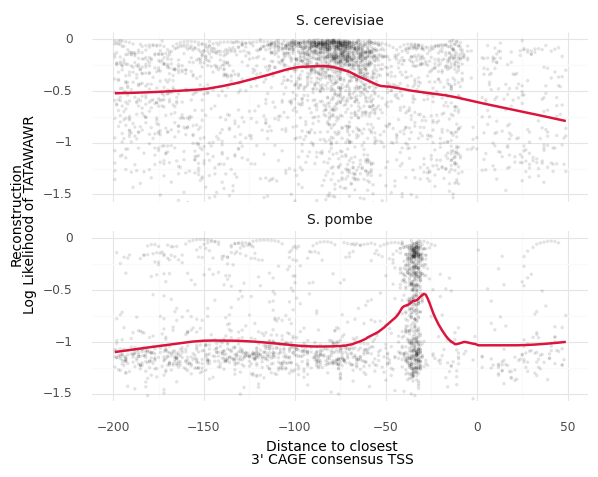

<ggplot: (1432163389462)>

In [279]:
tata_evo["distance_to_tss_neg"] = -tata_evo["distance_to_tss"]

p = (p9.ggplot(data=tata_evo.query('distance_to_tss < 200 and distance_to_tss > -50'), 
           mapping=p9.aes(x="distance_to_tss_neg",y="ce", color="species_short"))
 + p9.geom_point(size=0.5, alpha = 0.075, color="black")
 #+ p9.scale_x_reverse()
 #+ p9.scale_color_manual(values=["mediumblue","crimson"])
 + p9.coord_cartesian(ylim=(-1.5,0))
 + p9.geom_smooth(method="lowess",span=0.3, size=1, color="crimson")#, color="black")
 + p9.labs(x="Distance to closest\n3' CAGE consensus TSS",y="Reconstruction\nLog Likelihood of TATAWAWR")
 + p9.facet_wrap('~ species_short', nrow=2)
 #+ p9.theme_light()
 + p9.theme_minimal()
 + p9.theme(legend_position="none",
            strip_text=p9.element_text(size=10),
            axis_title=p9.element_text(size=10),
           )
 #+ p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1))
)

#p.save("../Graphics/Paper/evo_tata" + ".svg", width=3.5, height=3.0, dpi=300)

p

### Motif disappearance

In [280]:
def motif_enrichment_vs_shuffled(motif, metric = "ce", n_shuffles = 5):
    np.random.seed(42)
    # get reconstruction fidelity for motif
    df_motif = match_bind_site_evo(motif = motif)
    df_motif["shuffled"] = False
    # get reconstruction fidelity for shuffled motifs
    print("shuffling")
    shuffled_motif = shuffle_regex(motif, n_shuffles = n_shuffles)
    print("done shuffling")
    df_bg = []
    for shuffled in shuffled_motif:
        df_bg.append(match_bind_site_evo(motif = shuffled))
    df_bg = pd.concat(df_bg)
    df_bg["shuffled"] = True
    df_motif = pd.concat([df_motif,df_bg]).reset_index(drop=True)
    # compute enrichment
    enrich_rows = []
    for species in set(df_motif["species"]):
        pval = scipy.stats.mannwhitneyu(df_motif.query('shuffled and species == @species')[metric],
                                         df_motif.query('not shuffled and species == @species')[metric]).pvalue
        log_fc = np.log2(df_motif.query('not shuffled and species == @species')[metric].mean()/df_motif.query('shuffled and species == @species')[metric].mean())
        if metric == "ce":
            log_fc = -log_fc
        enrich_rows.append({
            "species":species,
            "motif":motif,
            "n":len(df_motif.query('not shuffled and species == @species')),
            "pval":pval,
            "log_p":-np.log10(pval),
            "log_fc":log_fc,
        })
    return df_motif, pd.DataFrame(enrich_rows)

def check_homology(species, homologue_df_high, homologue_df_low):
    if species in set(homologue_df_high["species"]):
        return "significant (E $< 10^{-12}$)"
    if species in set(homologue_df_low["species"]):
        return "uncertain (E $< 0.05$)"
    print("no match: {}".format(species))
    return "none"

#### RAP1


No RAP1 in yarrowia - here alternative is reconstructed better!

There are species, e.g. C. albicans, which have the protein but the model implies that they do not exhibit the canonical Rap1 motif. This is consistent with previous observations in the literature.

In [281]:
rap1_evo, rap1_enrich = motif_enrichment_vs_shuffled("CA[TC]CC[GA]TACA[TC]", metric = "ce", n_shuffles=10)

shuffling
done shuffling


In [282]:
rap1_enrich.sort_values("log_fc")

species                 motif   
9   nadsonia_fulvescens_var_elongata_dsm_6958_gca_...  CA[TC]CC[GA]TACA[TC]  \
34                                yarrowia_lipolytica  CA[TC]CC[GA]TACA[TC]   
3                  ascodesmis_nigricans_gca_004786065  CA[TC]CC[GA]TACA[TC]   
36                               aspergillus_nidulans  CA[TC]CC[GA]TACA[TC]   
6                                   neurospora_crassa  CA[TC]CC[GA]TACA[TC]   
47            wickerhamiella_sorbophila_gca_002251995  CA[TC]CC[GA]TACA[TC]   
56  hanseniaspora_valbyensis_nrrl_y_1626_gca_00166...  CA[TC]CC[GA]TACA[TC]   
43         kuraishia_capsulata_cbs_1993_gca_000576695  CA[TC]CC[GA]TACA[TC]   
20     neurospora_tetrasperma_fgsc_2509_gca_000213195  CA[TC]CC[GA]TACA[TC]   
55                      schizosaccharomyces_japonicus  CA[TC]CC[GA]TACA[TC]   
15    saitoella_complicata_nrrl_y_17804_gca_000227095  CA[TC]CC[GA]TACA[TC]   
28                     schizosaccharomyces_octosporus  CA[TC]CC[GA]TACA[TC]   
30                                   magnaporthe_poae  CA[TC]CC[GA]TACA[TC]   
45  tortispora_caseinolytica_nrrl_y_17796_gca_0016...  CA[TC]CC[GA]TACA[TC]   
7                               aspergillus_fumigatus  CA[TC]CC[GA]TACA[TC]   
27  agaricus_bisporus_var_burnettii_jb137_s8_gca_0...  CA[TC]CC[GA]TACA[TC]   
42                          schizosaccharomyces_pombe  CA[TC]CC[GA]TACA[TC]   
2                      schizosaccharomyces_cryophilus  CA[TC]CC[GA]TACA[TC]   
17                 hanseniaspora_uvarum_gca_009805765  CA[TC]CC[GA]TACA[TC]   
5            sugiyamaella_lignohabitans_gca_001640025  CA[TC]CC[GA]TACA[TC]   
26      lipomyces_starkeyi_nrrl_y_11557_gca_001661325  CA[TC]CC[GA]TACA[TC]   
44    scheffersomyces_stipitis_cbs_6054_gca_000209165  CA[TC]CC[GA]TACA[TC]   
49                                 aspergillus_oryzae  CA[TC]CC[GA]TACA[TC]   
41                                   candida_albicans  CA[TC]CC[GA]TACA[TC]   
23           pneumocystis_jirovecii_ru7_gca_001477535  CA[TC]CC[GA]TACA[TC]   
8              cordyceps_militaris_cm01_gca_000225605  CA[TC]CC[GA]TACA[TC]   
51  lodderomyces_elongisporus_nrrl_yb_4239_gca_000...  CA[TC]CC[GA]TACA[TC]   
21                               aspergillus_clavatus  CA[TC]CC[GA]TACA[TC]   
46                                 candida_tropicalis  CA[TC]CC[GA]TACA[TC]   
31      terfezia_boudieri_atcc_mya_4762_gca_003788615  CA[TC]CC[GA]TACA[TC]   
53  wickerhamomyces_anomalus_nrrl_y_366_8_gca_0016...  CA[TC]CC[GA]TACA[TC]   
50                 _candida_inconspicua_gca_004931855  CA[TC]CC[GA]TACA[TC]   
29                               candida_parapsilosis  CA[TC]CC[GA]TACA[TC]   
48   pachysolen_tannophilus_nrrl_y_2460_gca_001661245  CA[TC]CC[GA]TACA[TC]   
37   pichia_membranifaciens_nrrl_y_2026_gca_001661235  CA[TC]CC[GA]TACA[TC]   
19                  pichia_kudriavzevii_gca_001983325  CA[TC]CC[GA]TACA[TC]   
4           ogataea_parapolymorpha_dl_1_gca_000187245  CA[TC]CC[GA]TACA[TC]   
12         debaryomyces_hansenii_cbs767_gca_000006445  CA[TC]CC[GA]TACA[TC]   
16               cyberlindnera_fabianii_gca_001983305  CA[TC]CC[GA]TACA[TC]   
33       naumovozyma_castellii_cbs_4309_gca_000237345  CA[TC]CC[GA]TACA[TC]   
52                                      candida_auris  CA[TC]CC[GA]TACA[TC]   
38  vanderwaltozyma_polyspora_dsm_70294_gca_000150035  CA[TC]CC[GA]TACA[TC]   
39     kazachstania_naganishii_cbs_8797_gca_000348985  CA[TC]CC[GA]TACA[TC]   
58       kazachstania_africana_cbs_2517_gca_000304475  CA[TC]CC[GA]TACA[TC]   
40              kluyveromyces_marxianus_gca_001854445  CA[TC]CC[GA]TACA[TC]   
59                              komagataella_pastoris  CA[TC]CC[GA]TACA[TC]   
22  eremothecium_cymbalariae_dbvpg_7215_gca_000235365  CA[TC]CC[GA]TACA[TC]   
35  _candida_arabinofermentans_nrrl_yb_2248_gca_00...  CA[TC]CC[GA]TACA[TC]   
54                           saccharomyces_cerevisiae  CA[TC]CC[GA]TACA[TC]   
1                  kluyveromyces_lactis_gca_000002515  CA[TC]CC[GA]TACA[TC]   
57               

In [283]:
rap1_enrich["species_short"] = rap1_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0][0].capitalize() + ". " + re.sub("^_","",x).split("_")[1])
rap1_enrich["genus"] = rap1_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0].lower())

In [285]:
# blast: find scer rap1 homologues
cutoff_high = 10**(-12)
cutoff_low = 0.05

blast_rap1 = pd.read_table(project_path+"data/Evo/rap1_tblastn.tsv", names=["query_id", "hit_id", "identity", "alignment_length", 
                                                        "mismatches", "gap_opens", "q_start", "q_end", "h_start", 
                                                        "h_end", "evalue", "bit_score"])
blast_rap1["species"] = blast_rap1["hit_id"].apply(lambda x: x.split(";")[1])
blast_rap1_high = blast_rap1.loc[blast_rap1["evalue"] < cutoff_high]
blast_rap1_low = blast_rap1.loc[blast_rap1["evalue"] < cutoff_low]

In [286]:
rap1_enrich["rap1_present"] = rap1_enrich.apply(lambda x: check_homology(x["species"], blast_rap1_high, blast_rap1_low),axis=1)

no match: schizosaccharomyces_cryophilus
no match: ascodesmis_nigricans_gca_004786065
no match: sugiyamaella_lignohabitans_gca_001640025
no match: neurospora_crassa
no match: aspergillus_fumigatus
no match: cordyceps_militaris_cm01_gca_000225605
no match: nadsonia_fulvescens_var_elongata_dsm_6958_gca_001661315
no match: saitoella_complicata_nrrl_y_17804_gca_000227095
no match: neurospora_tetrasperma_fgsc_2509_gca_000213195
no match: pneumocystis_jirovecii_ru7_gca_001477535
no match: lipomyces_starkeyi_nrrl_y_11557_gca_001661325
no match: agaricus_bisporus_var_burnettii_jb137_s8_gca_000300555
no match: schizosaccharomyces_octosporus
no match: magnaporthe_poae
no match: terfezia_boudieri_atcc_mya_4762_gca_003788615
no match: yarrowia_lipolytica
no match: aspergillus_nidulans
no match: schizosaccharomyces_pombe
no match: tortispora_caseinolytica_nrrl_y_17796_gca_001661475
no match: wickerhamiella_sorbophila_gca_002251995
no match: aspergillus_oryzae
no match: schizosaccharomyces_japonicus

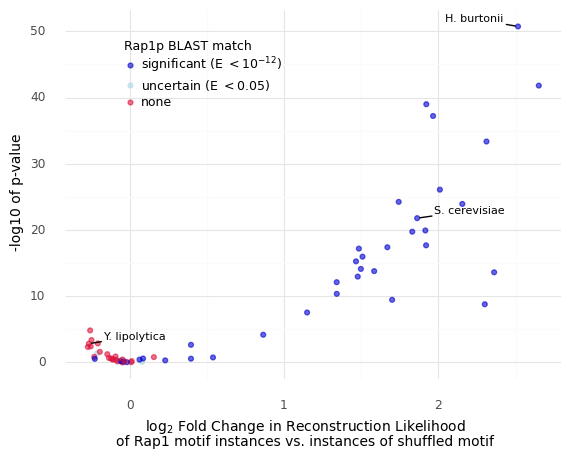

<ggplot: (1432163381610)>

In [287]:

rap1_enrich["rap1_present_cat"] = pd.Categorical(rap1_enrich["rap1_present"], categories=["significant (E $< 10^{-12}$)","uncertain (E $< 0.05$)","none"])


p = (p9.ggplot(data=rap1_enrich, mapping=p9.aes(x="log_fc",y="log_p", color="rap1_present_cat")) 
 + p9.geom_point(size=1.5,raster=True,alpha=0.6)
 + p9.geom_text(data=rap1_enrich.query('species_short in ["S. cerevisiae", "H. burtonii", "Y. lipolytica"]'),mapping=p9.aes(label="species_short"), 
                alpha=1, color="black",
               adjust_text={'expand_points': (1.5, 1.5), 'arrowprops': {'arrowstyle': '-',"color":"black"}}, size=8)
 + p9.scale_color_manual(values=["mediumblue","lightblue","crimson"])
 + p9.labs(y="-log10 of p-value", x="log$_2$ Fold Change in Reconstruction Likelihood\nof Rap1 motif instances vs. instances of shuffled motif")
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9,text="Rap1p BLAST match"),
            legend_position=(0.34,0.75), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )

)

#p.save("../Graphics/Paper/evo_rap1" + ".svg", width=3.5, height=3.0, dpi=300)

p

In [288]:
rap1_enrich_matched = blast_rap1.sort_values('evalue').drop_duplicates(subset="species",keep="first")[["species","evalue", "identity", "bit_score"]].merge(rap1_enrich,on="species")

#### PAC

In [291]:
pac_evo, pac_enrich = motif_enrichment_vs_shuffled("G[CA]GATGAG.T", metric = "ce")

shuffling
done shuffling


In [293]:
pac_enrich.sort_values("log_fc")

species          motif    n   
28                     schizosaccharomyces_octosporus  G[CA]GATGAG.T   21  \
2                      schizosaccharomyces_cryophilus  G[CA]GATGAG.T   19   
37   pichia_membranifaciens_nrrl_y_2026_gca_001661235  G[CA]GATGAG.T   39   
55                      schizosaccharomyces_japonicus  G[CA]GATGAG.T   37   
4           ogataea_parapolymorpha_dl_1_gca_000187245  G[CA]GATGAG.T   44   
31      terfezia_boudieri_atcc_mya_4762_gca_003788615  G[CA]GATGAG.T  123   
15    saitoella_complicata_nrrl_y_17804_gca_000227095  G[CA]GATGAG.T  150   
23           pneumocystis_jirovecii_ru7_gca_001477535  G[CA]GATGAG.T    9   
9   nadsonia_fulvescens_var_elongata_dsm_6958_gca_...  G[CA]GATGAG.T   31   
47            wickerhamiella_sorbophila_gca_002251995  G[CA]GATGAG.T   27   
19                  pichia_kudriavzevii_gca_001983325  G[CA]GATGAG.T   30   
45  tortispora_caseinolytica_nrrl_y_17796_gca_0016...  G[CA]GATGAG.T   30   
50                 _candida_inconspicua_gca_004931855  G[CA]GATGAG.T   28   
42                          schizosaccharomyces_pombe  G[CA]GATGAG.T   15   
26      lipomyces_starkeyi_nrrl_y_11557_gca_001661325  G[CA]GATGAG.T   95   
36                               aspergillus_nidulans  G[CA]GATGAG.T  112   
27  agaricus_bisporus_var_burnettii_jb137_s8_gca_0...  G[CA]GATGAG.T  145   
20     neurospora_tetrasperma_fgsc_2509_gca_000213195  G[CA]GATGAG.T  104   
30                                   magnaporthe_poae  G[CA]GATGAG.T   87   
17                 hanseniaspora_uvarum_gca_009805765  G[CA]GATGAG.T   16   
8              cordyceps_militaris_cm01_gca_000225605  G[CA]GATGAG.T  111   
5            sugiyamaella_lignohabitans_gca_001640025  G[CA]GATGAG.T   77   
6                                   neurospora_crassa  G[CA]GATGAG.T   89   
49                                 aspergillus_oryzae  G[CA]GATGAG.T  132   
7                               aspergillus_fumigatus  G[CA]GATGAG.T  100   
18           brettanomyces_bruxellensis_gca_902155815  G[CA]GATGAG.T   33   
34                                yarrowia_lipolytica  G[CA]GATGAG.T   98   
21                               aspergillus_clavatus  G[CA]GATGAG.T  111   
56  hanseniaspora_valbyensis_nrrl_y_1626_gca_00166...  G[CA]GATGAG.T   17   
3                  ascodesmis_nigricans_gca_004786065  G[CA]GATGAG.T  259   
52                                      candida_auris  G[CA]GATGAG.T   92   
51  lodderomyces_elongisporus_nrrl_yb_4239_gca_000...  G[CA]GATGAG.T   68   
32     clavispora_lusitaniae_atcc_42720_gca_000003835  G[CA]GATGAG.T   69   
44    scheffersomyces_stipitis_cbs_6054_gca_000209165  G[CA]GATGAG.T  115   
12         debaryomyces_hansenii_cbs767_gca_000006445  G[CA]GATGAG.T   61   
29                               candida_parapsilosis  G[CA]GATGAG.T   96   
59                              komagataella_pastoris  G[CA]GATGAG.T   92   
25                                  candida_haemuloni  G[CA]GATGAG.T   84   
48   pachysolen_tannophilus_nrrl_y_2460_gca_001661245  G[CA]GATGAG.T   69   
35  _candida_arabinofermentans_nrrl_yb_2248_gca_00...  G[CA]GATGAG.T   55   
13     hyphopichia_burtonii_nrrl_y_1933_gca_001661395  G[CA]GATGAG.T   87   
43         kuraishia_capsulata_cbs_1993_gca_000576695  G[CA]GATGAG.T  139   
11            metschnikowia_bicuspidata_gca_003614695  G[CA]GATGAG.T  136   
46                                 candida_tropicalis  G[CA]GATGAG.T   75   
16               cyberlindnera_fabianii_gca_001983305  G[CA]GATGAG.T  223   
41                                   candida_albicans  G[CA]GATGAG.T   88   
10    cyberlindnera_jadinii_nrrl_y_1542_gca_001661405  G[CA]GATGAG.T  308   
53  wickerhamomyces_anomalus_nrrl_y_366_8_gca_0016...  G[CA]GATGAG.T  179   
24                                    ashbya_gossypii  G[CA]GATGAG.T  223   
33       naumovozyma_castellii_cbs_4309_gca_000237345  G[CA]GATGAG.T  240   
39     kazachstania_naganishii_cbs_8797_gca_000348985  G[CA]GATGAG.T  294   
58       kazachstania_africana_cbs_2517_gc

In [294]:
pac_enrich["species_short"] = pac_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0][0].capitalize() + ". " + re.sub("^_","",x).split("_")[1])
pac_enrich["genus"] = pac_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0].lower())

In [295]:
# blast: find scer rap1 homologues
cutoff_high = 10**(-12)
cutoff_low = 0.05

blast_pac = pd.read_table(project_path+"data/Evo/tod6_tblastn.tsv", names=["query_id", "hit_id", "identity", "alignment_length", 
                                                        "mismatches", "gap_opens", "q_start", "q_end", "h_start", 
                                                        "h_end", "evalue", "bit_score"])
blast_pac["species"] = blast_pac["hit_id"].apply(lambda x: x.split(";")[1])
blast_pac_high = blast_pac.loc[blast_pac["evalue"] < cutoff_high]
blast_pac_low = blast_pac.loc[blast_pac["evalue"] < cutoff_low]

In [296]:
pac_enrich["pac_present"] = pac_enrich.apply(lambda x: check_homology(x["species"], blast_pac_high, blast_pac_low),axis=1)

no match: schizosaccharomyces_cryophilus
no match: neurospora_crassa
no match: aspergillus_fumigatus
no match: cordyceps_militaris_cm01_gca_000225605
no match: neurospora_tetrasperma_fgsc_2509_gca_000213195
no match: aspergillus_clavatus
no match: pneumocystis_jirovecii_ru7_gca_001477535
no match: agaricus_bisporus_var_burnettii_jb137_s8_gca_000300555
no match: schizosaccharomyces_octosporus
no match: magnaporthe_poae
no match: aspergillus_nidulans
no match: schizosaccharomyces_pombe
no match: wickerhamiella_sorbophila_gca_002251995
no match: aspergillus_oryzae
no match: schizosaccharomyces_japonicus


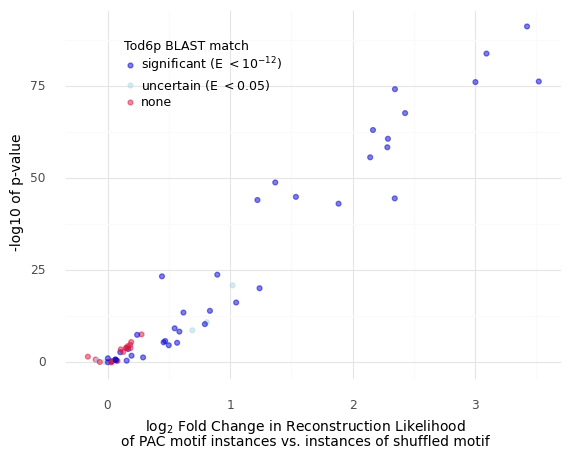

<ggplot: (1432130689961)>

In [297]:
pac_enrich["pac_present_cat"] = pd.Categorical(pac_enrich["pac_present"], categories=["significant (E $< 10^{-12}$)","uncertain (E $< 0.05$)","none"])


p = (p9.ggplot(data=pac_enrich, mapping=p9.aes(x="log_fc",y="log_p", color="pac_present_cat")) 
 + p9.geom_point(size=1.5,raster=True,alpha=0.5)
 #+ p9.geom_text(data=pac_enrich.query('species_short in ["S. cerevisiae", "H. burtonii", "Y. lipolytica"]'),mapping=p9.aes(label="species_short"), 
 #               alpha=1, color="black",
 #              adjust_text={'expand_points': (1.5, 1.5), 'arrowprops': {'arrowstyle': '-',"color":"black"}}, size=8)
 + p9.scale_color_manual(values=["mediumblue","lightblue","crimson"])
 + p9.labs(y="-log10 of p-value", x="log$_2$ Fold Change in Reconstruction Likelihood\nof PAC motif instances vs. instances of shuffled motif")
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9,text="Tod6p BLAST match"),
            legend_position=(0.34,0.75), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )

)

#p.save("../Graphics/Paper/evo_pac" + ".svg", width=3.5, height=3.0, dpi=300)

p

#### REB1

In [298]:
reb1_evo, reb1_enrich = motif_enrichment_vs_shuffled("CGGGTAA", metric = "ce")

shuffling
done shuffling


In [299]:
reb1_enrich.sort_values("log_fc")

species    motif    n   
21                               aspergillus_clavatus  CGGGTAA  193  \
7                               aspergillus_fumigatus  CGGGTAA  258   
6                                   neurospora_crassa  CGGGTAA  259   
20     neurospora_tetrasperma_fgsc_2509_gca_000213195  CGGGTAA  280   
8              cordyceps_militaris_cm01_gca_000225605  CGGGTAA  264   
36                               aspergillus_nidulans  CGGGTAA  283   
15    saitoella_complicata_nrrl_y_17804_gca_000227095  CGGGTAA  266   
55                      schizosaccharomyces_japonicus  CGGGTAA  106   
30                                   magnaporthe_poae  CGGGTAA  277   
27  agaricus_bisporus_var_burnettii_jb137_s8_gca_0...  CGGGTAA  327   
28                     schizosaccharomyces_octosporus  CGGGTAA   77   
31      terfezia_boudieri_atcc_mya_4762_gca_003788615  CGGGTAA  272   
2                      schizosaccharomyces_cryophilus  CGGGTAA   66   
23           pneumocystis_jirovecii_ru7_gca_001477535  CGGGTAA   39   
42                          schizosaccharomyces_pombe  CGGGTAA   76   
49                                 aspergillus_oryzae  CGGGTAA  367   
51  lodderomyces_elongisporus_nrrl_yb_4239_gca_000...  CGGGTAA   92   
3                  ascodesmis_nigricans_gca_004786065  CGGGTAA  273   
11            metschnikowia_bicuspidata_gca_003614695  CGGGTAA  124   
18           brettanomyces_bruxellensis_gca_902155815  CGGGTAA  118   
29                               candida_parapsilosis  CGGGTAA  113   
52                                      candida_auris  CGGGTAA  115   
32     clavispora_lusitaniae_atcc_42720_gca_000003835  CGGGTAA  140   
25                                  candida_haemuloni  CGGGTAA  118   
47            wickerhamiella_sorbophila_gca_002251995  CGGGTAA  192   
46                                 candida_tropicalis  CGGGTAA   74   
37   pichia_membranifaciens_nrrl_y_2026_gca_001661235  CGGGTAA  119   
50                 _candida_inconspicua_gca_004931855  CGGGTAA  128   
19                  pichia_kudriavzevii_gca_001983325  CGGGTAA  163   
41                                   candida_albicans  CGGGTAA   89   
10    cyberlindnera_jadinii_nrrl_y_1542_gca_001661405  CGGGTAA  209   
5            sugiyamaella_lignohabitans_gca_001640025  CGGGTAA  152   
16               cyberlindnera_fabianii_gca_001983305  CGGGTAA  230   
44    scheffersomyces_stipitis_cbs_6054_gca_000209165  CGGGTAA  131   
59                              komagataella_pastoris  CGGGTAA  154   
34                                yarrowia_lipolytica  CGGGTAA  240   
43         kuraishia_capsulata_cbs_1993_gca_000576695  CGGGTAA  274   
13     hyphopichia_burtonii_nrrl_y_1933_gca_001661395  CGGGTAA  167   
0     lachancea_thermotolerans_cbs_6340_gca_000142805  CGGGTAA  196   
26      lipomyces_starkeyi_nrrl_y_11557_gca_001661325  CGGGTAA  492   
4           ogataea_parapolymorpha_dl_1_gca_000187245  CGGGTAA  202   
45  tortispora_caseinolytica_nrrl_y_17796_gca_0016...  CGGGTAA  226   
12         debaryomyces_hansenii_cbs767_gca_000006445  CGGGTAA  232   
35  _candida_arabinofermentans_nrrl_yb_2248_gca_00...  CGGGTAA  136   
48   pachysolen_tannophilus_nrrl_y_2460_gca_001661245  CGGGTAA   88   
53  wickerhamomyces_anomalus_nrrl_y_366_8_gca_0016...  CGGGTAA  161   
17                 hanseniaspora_uvarum_gca_009805765  CGGGTAA  164   
9   nadsonia_fulvescens_var_elongata_dsm_6958_gca_...  CGGGTAA  424   
57                                   candida_glabrata  CGGGTAA  279   
39     kazachstania_naganishii_cbs_8797_gca_000348985  CGGGTAA  295   
33       naumovozyma_castellii_cbs_4309_gca_000237345  CGGGTAA  399   
14              torulaspora_delbrueckii_gca_000243375  CGGGTAA  209   
54                           saccharomyces_cerevisiae  CGGGTAA  417   
24                                    ashbya_gossypii  CGGGTAA  387   
58       kazachstania_africana_cbs_2517_gca_000304475  CGGGTAA  394   
22  eremothecium_cymbalariae_dbvpg_7215_gca_000235365  CGGGTAA  318   

In [300]:
reb1_enrich["species_short"] = reb1_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0][0].capitalize() + ". " + re.sub("^_","",x).split("_")[1])
reb1_enrich["genus"] = reb1_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0].lower())

In [301]:
# blast: find scer reb1 homologues
cutoff_high = 10**(-12)
cutoff_low = 0.05

blast_reb1 = pd.read_table(project_path+"data/Evo/reb1_tblastn.tsv", names=["query_id", "hit_id", "identity", "alignment_length", 
                                                        "mismatches", "gap_opens", "q_start", "q_end", "h_start", 
                                                        "h_end", "evalue", "bit_score"])
blast_reb1["species"] = blast_reb1["hit_id"].apply(lambda x: x.split(";")[1])
blast_reb1_high = blast_reb1.loc[blast_reb1["evalue"] < cutoff_high]
blast_reb1_low = blast_reb1.loc[blast_reb1["evalue"] < cutoff_low]

In [302]:
reb1_enrich["reb1_present"] = reb1_enrich.apply(lambda x: check_homology(x["species"], blast_reb1_high, blast_reb1_low),axis=1)

no match: neurospora_crassa
no match: aspergillus_fumigatus
no match: cordyceps_militaris_cm01_gca_000225605
no match: neurospora_tetrasperma_fgsc_2509_gca_000213195
no match: aspergillus_clavatus
no match: pneumocystis_jirovecii_ru7_gca_001477535
no match: agaricus_bisporus_var_burnettii_jb137_s8_gca_000300555
no match: magnaporthe_poae
no match: aspergillus_nidulans
no match: aspergillus_oryzae


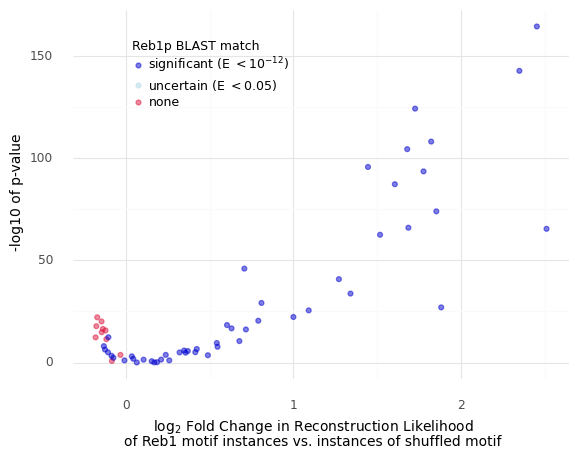

<ggplot: (1432148591827)>

In [303]:
reb1_enrich["reb1_present_cat"] = pd.Categorical(reb1_enrich["reb1_present"], categories=["significant (E $< 10^{-12}$)","uncertain (E $< 0.05$)","none"])


p = (p9.ggplot(data=reb1_enrich, mapping=p9.aes(x="log_fc",y="log_p", color="reb1_present_cat")) 
 + p9.geom_point(size=1.5,raster=True,alpha=0.5)
 #+ p9.geom_text(data=pac_enrich.query('species_short in ["S. cerevisiae", "H. burtonii", "Y. lipolytica"]'),mapping=p9.aes(label="species_short"), 
 #               alpha=1, color="black",
 #              adjust_text={'expand_points': (1.5, 1.5), 'arrowprops': {'arrowstyle': '-',"color":"black"}}, size=8)
 + p9.scale_color_manual(values=["mediumblue","lightblue","crimson"])
 + p9.labs(y="-log10 of p-value", x="log$_2$ Fold Change in Reconstruction Likelihood\nof Reb1 motif instances vs. instances of shuffled motif")
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=9),
            legend_key_size=9,
            legend_background=p9.element_blank(),
            legend_title=p9.element_text(size=9,text="Reb1p BLAST match"),
            legend_position=(0.34,0.75), 
            legend_direction='vertical',
            axis_title=p9.element_text(size=10),
           )

)

#p.save("../Graphics/Paper/evo_reb1" + ".svg", width=3.5, height=3.0, dpi=300)

p

### Motif change

In [304]:
def enrich_comparison(df_motif, compare_var, metric="ce"):
    enrich_rows = []
    for species in set(df_motif["species"]):
        #print(species)
        #print(len(df_motif.query('species == @species')))
        if len(df_motif.query('{} and species == @species'.format(compare_var))) < 2:
            continue
        pval = scipy.stats.mannwhitneyu(df_motif.query('{} and species == @species'.format(compare_var))[metric],
                                         df_motif.query('not {} and species == @species'.format(compare_var))[metric], method="asymptotic").pvalue
        log_fc = np.log2(df_motif.query('{} and species == @species'.format(compare_var))[metric].mean()/df_motif.query('not {} and species == @species'.format(compare_var))[metric].mean())
        if metric == "ce":
            log_fc = -log_fc
        enrich_rows.append({
            "species":species,
            "comparison":compare_var,
            "n":len(df_motif.query('{} and species == @species'.format(compare_var))),
            "pval":pval,
            "log_p":-np.log10(pval),
            "log_fc":log_fc,
        })
    return pd.DataFrame(enrich_rows)

#### Evolution of Homol-E

In [305]:
def homole_annot(metrics, data_row):
    match_seq = data_row["match_seq"]
    # c.albicans/d.hansenii: G preference
    g_present = match_seq.startswith("GGG")
    # s.pombe: double motif
    double_motif = "CCCTACCCTA" in match_seq
    # ship it
    metrics["match_seq"] = match_seq
    metrics["g_present"] = g_present
    metrics["double_motif"] = double_motif

In [306]:
homole_evo = match_bind_site_evo(motif = ".........CCCTA", metadata_fns = [homole_annot])

##### G preference

In [307]:
homole_g_enrich = enrich_comparison(homole_evo, compare_var="g_present").sort_values('log_fc')

In [308]:
homole_g_enrich

species comparison    n   
27                     schizosaccharomyces_octosporus  g_present    9  \
46            wickerhamiella_sorbophila_gca_002251995  g_present   23   
39              kluyveromyces_marxianus_gca_001854445  g_present   17   
42         kuraishia_capsulata_cbs_1993_gca_000576695  g_present   19   
36   pichia_membranifaciens_nrrl_y_2026_gca_001661235  g_present   21   
5            sugiyamaella_lignohabitans_gca_001640025  g_present   40   
15    saitoella_complicata_nrrl_y_17804_gca_000227095  g_present   26   
29                                   magnaporthe_poae  g_present   73   
0     lachancea_thermotolerans_cbs_6340_gca_000142805  g_present   21   
17                 hanseniaspora_uvarum_gca_009805765  g_present    4   
55                                   candida_glabrata  g_present   26   
4           ogataea_parapolymorpha_dl_1_gca_000187245  g_present   13   
22  eremothecium_cymbalariae_dbvpg_7215_gca_000235365  g_present   11   
23                                    ashbya_gossypii  g_present   27   
49                 _candida_inconspicua_gca_004931855  g_present    8   
19                  pichia_kudriavzevii_gca_001983325  g_present   14   
10    cyberlindnera_jadinii_nrrl_y_1542_gca_001661405  g_present   31   
14              torulaspora_delbrueckii_gca_000243375  g_present   15   
26  agaricus_bisporus_var_burnettii_jb137_s8_gca_0...  g_present   34   
38     kazachstania_naganishii_cbs_8797_gca_000348985  g_present   32   
6                                   neurospora_crassa  g_present   50   
7                               aspergillus_fumigatus  g_present   40   
35                               aspergillus_nidulans  g_present   63   
52  wickerhamomyces_anomalus_nrrl_y_366_8_gca_0016...  g_present    8   
41                          schizosaccharomyces_pombe  g_present   15   
8              cordyceps_militaris_cm01_gca_000225605  g_present   33   
16               cyberlindnera_fabianii_gca_001983305  g_present   23   
21                               aspergillus_clavatus  g_present   47   
1                  kluyveromyces_lactis_gca_000002515  g_present    7   
56       kazachstania_africana_cbs_2517_gca_000304475  g_present    5   
30      terfezia_boudieri_atcc_mya_4762_gca_003788615  g_present   78   
34  _candida_arabinofermentans_nrrl_yb_2248_gca_00...  g_present    5   
54                      schizosaccharomyces_japonicus  g_present   14   
9   nadsonia_fulvescens_var_elongata_dsm_6958_gca_...  g_present   24   
20     neurospora_tetrasperma_fgsc_2509_gca_000213195  g_present   61   
48                                 aspergillus_oryzae  g_present  106   
2                      schizosaccharomyces_cryophilus  g_present   11   
18           brettanomyces_bruxellensis_gca_902155815  g_present    6   
25      lipomyces_starkeyi_nrrl_y_11557_gca_001661325  g_present   49   
53                           saccharomyces_cerevisiae  g_present   12   
32       naumovozyma_castellii_cbs_4309_gca_000237345  g_present   31   
3                  ascodesmis_nigricans_gca_004786065  g_present   20   
57                              komagataella_pastoris  g_present   20   
33                                yarrowia_lipolytica  g_present   37   
37  vanderwaltozyma_polyspora_dsm_70294_gca_000150035  g_present    8   
44  tortispora_caseinolytica_nrrl_y_17796_gca_0016...  g_present   11   
28                               candida_parapsilosis  g_present   27   
11            metschnikowia_bicuspidata_gca_003614695  g_present   36   
47   pachysolen_tannophilus_nrrl_y_2460_gca_001661245  g_present    8   
51                                      candida_auris  g_present   50   
12         debaryomyces_hansenii_cbs767_gca_000006445  g_present   18   
13     hyphopichia_burtonii_nrrl_y_1933_gca_001661395  g_present   31   
31     clavispora_lusitaniae_atcc_42720_gca_000003835  g_present   47   
24                                  candida_haemuloni  g_present   57   
43    scheffersomyces_stipitis_

In [309]:
homole_g_enrich["species_short"] = homole_g_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0][0].capitalize() + ". " + re.sub("^_","",x).split("_")[1])
homole_g_enrich["genus"] = homole_g_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0].lower())

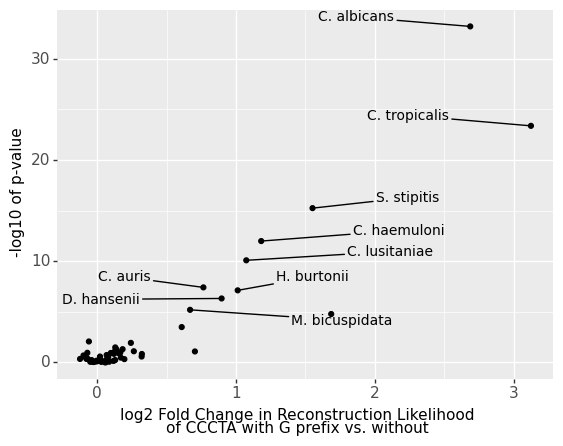

<ggplot: (1432136809283)>

In [310]:

p = (p9.ggplot(data=homole_g_enrich, mapping=p9.aes(x="log_fc",y="log_p")) 
 + p9.geom_point(size=1.5,raster=True)
 + p9.geom_text(data=homole_g_enrich.query('log_p > 5'),mapping=p9.aes(label="species_short"), 
                alpha=1, color="black",
               adjust_text={'expand_points': (3, 1.5), 'arrowprops': {'arrowstyle': '-',"color":"black"}}, size=10)
 + p9.labs(y="-log10 of p-value", x="log2 Fold Change in Reconstruction Likelihood\nof CCCTA with G prefix vs. without")
 + p9.theme(text=p9.element_text(size=11),legend_title=p9.element_text(text="Tod6p Blast match"))
)
p

##### Double motif

In [311]:
double_homole_enrich = enrich_comparison(homole_evo, compare_var="double_motif").sort_values('log_fc')

In [312]:
double_homole_enrich 

species    comparison   n   
40                                   candida_glabrata  double_motif   4  \
6                               aspergillus_fumigatus  double_motif   4   
8   nadsonia_fulvescens_var_elongata_dsm_6958_gca_...  double_motif   4   
36  lodderomyces_elongisporus_nrrl_yb_4239_gca_000...  double_motif   2   
1                  kluyveromyces_lactis_gca_000002515  double_motif   2   
0     lachancea_thermotolerans_cbs_6340_gca_000142805  double_motif   3   
11    saitoella_complicata_nrrl_y_17804_gca_000227095  double_motif   6   
9     cyberlindnera_jadinii_nrrl_y_1542_gca_001661405  double_motif   2   
24       naumovozyma_castellii_cbs_4309_gca_000237345  double_motif   2   
13           brettanomyces_bruxellensis_gca_902155815  double_motif   3   
41                              komagataella_pastoris  double_motif   4   
38                           saccharomyces_cerevisiae  double_motif   9   
33                                 candida_tropicalis  double_motif   3   
21                               candida_parapsilosis  double_motif   2   
18                                  candida_haemuloni  double_motif   4   
35                                 aspergillus_oryzae  double_motif  10   
37                                      candida_auris  double_motif   3   
17                                    ashbya_gossypii  double_motif   2   
19      lipomyces_starkeyi_nrrl_y_11557_gca_001661325  double_motif   8   
23      terfezia_boudieri_atcc_mya_4762_gca_003788615  double_motif  12   
12               cyberlindnera_fabianii_gca_001983305  double_motif   3   
5                                   neurospora_crassa  double_motif   6   
22                                   magnaporthe_poae  double_motif  13   
32  tortispora_caseinolytica_nrrl_y_17796_gca_0016...  double_motif   2   
3                  ascodesmis_nigricans_gca_004786065  double_motif   4   
7              cordyceps_militaris_cm01_gca_000225605  double_motif   9   
4            sugiyamaella_lignohabitans_gca_001640025  double_motif   4   
27                               aspergillus_nidulans  double_motif   7   
25                                yarrowia_lipolytica  double_motif  14   
29  vanderwaltozyma_polyspora_dsm_70294_gca_000150035  double_motif   4   
16           pneumocystis_jirovecii_ru7_gca_001477535  double_motif   3   
14     neurospora_tetrasperma_fgsc_2509_gca_000213195  double_motif  12   
30              kluyveromyces_marxianus_gca_001854445  double_motif   6   
15                               aspergillus_clavatus  double_motif   9   
34            wickerhamiella_sorbophila_gca_002251995  double_motif   9   
28   pichia_membranifaciens_nrrl_y_2026_gca_001661235  double_motif   5   
2                      schizosaccharomyces_cryophilus  double_motif  51   
20                     schizosaccharomyces_octosporus  double_motif  45   
31                          schizosaccharomyces_pombe  double_motif  36   
39                      schizosaccharomyces_japonicus  double_motif  45   
26  _candida_arabinofermentans_nrrl_yb_2248_gca_00...  double_motif   4   
10         debaryomyces_hansenii_cbs767_gca_000006445  double_motif   4   

            pval      log_p    log_fc  
40  1.515060e-02   1.819570 -0.326943  
6   6.020749e-02   1.220350 -0.245798  
8   6.500619e-01   0.187045 -0.228283  
36  8.596093e-01   0.065699 -0.044409  
1   6.497457e-01   0.187257 -0.002075  
0   3.528907e-01   0.452360  0.044727  
11  7.950069e-01   0.099629  0.053141  
9   7.028656e-01   0.153128  0.087989  
24  3.427662e-01   0.465002  0.113813  
13  1.174438e-01   0.930170  0.134531  
41  6.526928e-01   0.185291  0.137543  
38  4.921360e-01   0.307915  0.154677  
33  1.420015e-01   0.847707  0.237841  
21  5.893497e-01   0.229627  0.270698  
18  8.020274e-02   1.095811  0.313270  
35  4.043625e-02   1.393229  0.330366  
37  5.398655e-02   1.267714  0.367273  
17  1.618300e-01   0.790941  0.377359  
19  1.150263e-01   0.939203  0.465025  
23  2.031311e-04   3

In [313]:
double_homole_enrich["species_short"] = double_homole_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0][0].capitalize() + ". " + re.sub("^_","",x).split("_")[1])
double_homole_enrich["genus"] = double_homole_enrich["species"].apply(lambda x: re.sub("^_","",x).split("_")[0].lower())

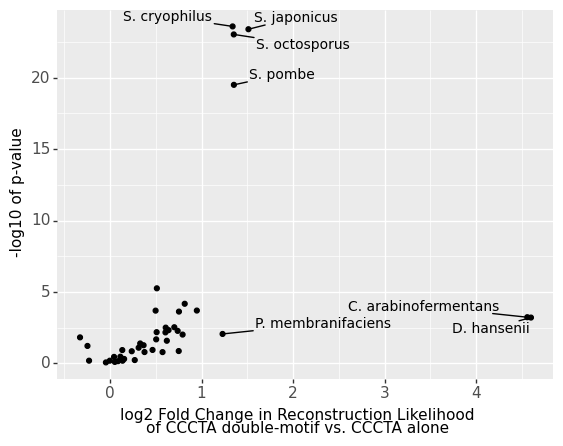

<ggplot: (1432162351318)>

In [314]:

p = (p9.ggplot(data=double_homole_enrich, mapping=p9.aes(x="log_fc",y="log_p")) 
 + p9.geom_point(size=1.5,raster=True)
 + p9.geom_text(data=double_homole_enrich.query('log_fc > 1'),mapping=p9.aes(label="species_short"), 
                alpha=1, color="black",
               adjust_text={'expand_points': (1.5, 1.5), 'arrowprops': {'arrowstyle': '-',"color":"black"}}, size=10)
 + p9.labs(y="-log10 of p-value", x="log2 Fold Change in Reconstruction Likelihood\nof CCCTA double-motif vs. CCCTA alone")
 + p9.theme(text=p9.element_text(size=11),legend_title=p9.element_text(text="Tod6p Blast match"))
)
p

## Variants

In [318]:
def compute_variant_effect(model,ref_nucs,alt_nucs,positions):
    path = paths_dict[model]
    targets = torch.load(path + "masked_targets.pt")
    prbs = torch.load(path + "prbs.pt")[:,:4]
    # select matching positions
    prbs_match = prbs[torch.tensor(positions),:]
    targets_match = targets[torch.tensor(positions)]
    # background
    bg_prbs = prbs.mean(axis=0)#[0]
    # compute metrics
    ref_prbs = (torch.nn.functional.one_hot(targets_match,num_classes=4)*prbs_match).max(axis=1)[0]
    ref_bgs = bg_prbs[targets_match]
    alt_prbs = (torch.nn.functional.one_hot(torch.tensor(alt_nucs),num_classes=4)*prbs_match).max(axis=1)[0]
    alt_bgs = bg_prbs[alt_nucs]
    var_eff = np.log2(alt_prbs/ref_prbs)
    var_eff_bg = np.log2((alt_prbs/alt_bgs)/(ref_prbs/ref_bgs))
    return ref_prbs, var_eff, var_eff_bg

In [319]:
import pyranges as pr

In [320]:
arabic_to_roman = {"1":"I","2":"II","3":"III","4":"IV","5":"V","6":"VI","7":"VII","8":"VIII",
                  "9":"IX","10":"X","11":"XI","12":"XII","13":"XIII","14":"XIV","15":"XV","16":"XVI"}

In [322]:
cds_locations = pd.read_parquet(project_path+"data/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/saccharomyces_cerevisiae_cds.parquet")
cds_locations = pr.PyRanges(cds_locations[["Chromosome","Start","End"]])

### Get 1011 yeast variants

In [323]:
all_yeasts = pd.read_csv(project_path+"data/1011_yeasts/1011Matrix_parsed.vcf",sep="\t",skiprows=58)#, use_cols = keys)

In [324]:
assert np.sum(all_yeasts["INFO"].apply(lambda x: x.split(";")[1].split("=")[0] == "AF")) == len(all_yeasts)
all_yeasts["AF"] = all_yeasts["INFO"].apply(lambda x: [float(x) for x in x.split(";")[1].split("=")[1].split(',')])
all_yeasts["AC"] = all_yeasts["INFO"].apply(lambda x: [float(x) for x in x.split(";")[0].split("=")[1].split(',')])

In [325]:
all_yeasts["Chromosome"] = all_yeasts["#CHROM"].str.replace("chromosome","").apply(lambda x: arabic_to_roman[x if x[0] != "0" else x[1]])
all_yeasts["pos"] = all_yeasts["POS"] - 1

In [326]:
all_yeasts["ALT"] = all_yeasts["ALT"].apply(lambda x: x.split(','))

In [327]:
all_yeasts_exploded = all_yeasts[["Chromosome","pos","REF","ALT","AF","AC"]].explode(["ALT","AF","AC"]).reset_index(drop=True)

In [328]:
all_yeasts_snp = all_yeasts_exploded.loc[(all_yeasts_exploded["REF"].str.len() == 1) & (all_yeasts_exploded["ALT"].str.len() == 1)]

In [329]:
all_yeasts_snp["Start"] = all_yeasts_snp["pos"]
all_yeasts_snp["End"] = all_yeasts_snp["pos"] + 1

In [330]:
all_yeasts_snp["Key"] = all_yeasts_snp.apply(lambda x: "_".join([x["Chromosome"],str(x["pos"]),x["REF"],x["ALT"]]),axis=1)

### Restrict to noncoding regions

In [331]:
allyeast_pr = pr.PyRanges(all_yeasts_snp)

In [332]:
all_yeasts_coding = set(allyeast_pr.join(cds_locations).df["Key"])
all_yeasts_snp = all_yeasts_snp.query('Key not in @all_yeasts_coding')

### Merge with five prime regions and remove duplicates

In [333]:
allyeast_pr = pr.PyRanges(all_yeasts_snp)

In [334]:
dataset_pr = pr.PyRanges(dataset[["Chromosome", "five_prime_start", "five_prime_end", "gene_id", "Strand","concat_start","concat_end", "five_prime_seq"]].rename(columns={"five_prime_start":"Start","five_prime_end":"End"}))

In [335]:
all_yeasts_merged = allyeast_pr.join(dataset_pr).df.rename(columns={"Start_b":"five_prime_start","End_b":"five_prime_end"})

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


In [336]:
all_yeasts_merged["rel_pos"] = all_yeasts_merged.apply(lambda x: x["pos"]-x["five_prime_start"] if x["Strand"] == "+" else 1002-(x["pos"]-x["five_prime_start"]), axis=1)

In [337]:
all_yeasts_merged = all_yeasts_merged.sort_values('rel_pos').drop_duplicates(subset="Key",keep="last")

### Compute variant effect distribution

In [338]:
# create all variants in five prime regions
var_rows = []
for _,row in dataset.iterrows():
    chrom = row["Chromosome"]
    seq = row["five_prime_seq"]
    strand = row["Strand"]
    init_pos = row["five_prime_start"]
    for rel_pos in range(len(seq)):
        ref = seq[rel_pos]
        actual_ref = ref if strand == "+" else nuc_to_revcomp[ref]
        actual_pos = rel_pos + init_pos if strand == "+" else (1002 - rel_pos) + init_pos
        for alt in set(["A","C","G","T"]) - set(ref):
            actual_alt = alt if strand == "+" else nuc_to_revcomp[alt]
            var_rows.append({
                "Key":"_".join([chrom, str(actual_pos),actual_ref,actual_alt]),
                "Chromosome":chrom,
                "REF":actual_ref,
                "ALT":actual_alt,
                "Start":actual_pos,
                "End":actual_pos+1,
                "seen_ref":ref,
                "seen_alt":alt,
                "rel_pos":rel_pos,
                "concat_pos":row["concat_start"]+rel_pos,
            })
all_possible_vars = pd.DataFrame(var_rows)

In [339]:
# reduce to those which do not intersect CDS regions
all_possible_vars_coding = set(pr.PyRanges(all_possible_vars).join(cds_locations).df["Key"])
all_possible_vars_noncoding = all_possible_vars.query('Key not in @all_possible_vars_coding')

In [340]:
all_possible_vars_noncoding = all_possible_vars_noncoding.sort_values('rel_pos').drop_duplicates(subset="Key",keep="last")

In [341]:
ref_nucs_all = [nuc_to_number[x] for x in all_possible_vars_noncoding["seen_ref"]]
alt_nucs_all = [nuc_to_number[x] for x in all_possible_vars_noncoding["seen_alt"]]
positions_all = [x for x in all_possible_vars_noncoding["concat_pos"]]

In [342]:
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k"]:
    ref_prbs, var_eff, var_eff_bg = compute_variant_effect(model,ref_nucs_all,alt_nucs_all,positions_all)
    all_possible_vars_noncoding["target_prb_" + model] = ref_prbs
    all_possible_vars_noncoding["var_eff_" + model] = var_eff
    all_possible_vars_noncoding["var_eff_bg_" + model] = var_eff_bg

In [343]:
cutoff_dict = {}

for model in ["BERT-ADN-200k","BERT-ADN-Species-200k"]:
    cutoff = all_possible_vars_noncoding["var_eff_"+model].quantile(q=0.01)
    cutoff_dict["var_eff_"+model] = cutoff
    cutoff = all_possible_vars_noncoding["var_eff_bg_"+model].quantile(q=0.01)
    cutoff_dict["var_eff_bg_"+model] = cutoff

### Compute variant effects

In [344]:
ref_nucs = []
alt_nucs = []
positions = []
for _,var_row in all_yeasts_merged.iterrows():
    strand = var_row["Strand"]
    ref = var_row["REF"] if strand == "+" else nuc_to_revcomp[var_row["REF"]]
    alt = var_row["ALT"] if strand == "+" else nuc_to_revcomp[var_row["ALT"]]
    assert ref != alt
    assert ref == var_row["five_prime_seq"][var_row["rel_pos"]], var_row["Key"]
    abs_pos = var_row["concat_start"] + var_row["rel_pos"]
    ref_nucs.append(nuc_to_number[ref])
    alt_nucs.append(nuc_to_number[alt])
    positions.append(abs_pos)

In [345]:
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k"]:
    ref_prbs, var_eff, var_eff_bg = compute_variant_effect(model,ref_nucs,alt_nucs,positions)
    all_yeasts_merged["target_prb_" + model] = ref_prbs
    all_yeasts_merged["var_eff_" + model] = var_eff
    all_yeasts_merged["var_eff_bg_" + model] = var_eff_bg

In [346]:
path = project_path+"outputs/scer_conservation_withoutstop_upstream/"
targets = torch.load(path + "masked_targets.pt")
prbs = torch.load(path + "prbs.pt")[:,:4]
# select matching positions
prbs = prbs[torch.tensor(positions),:]
targets = targets[torch.tensor(positions)]
conservation = torch.nan_to_num((torch.nn.functional.one_hot(targets,num_classes=4)*prbs).max(axis=1)[0])

In [347]:
all_yeasts_merged["Conservation"] = conservation

In [348]:
for model in ["BERT-ADN-200k","BERT-ADN-Species-200k"]:
    cutoff = cutoff_dict["var_eff_"+model]#all_yeasts_merged["var_eff_"+model].quantile(q=0.01)
    all_yeasts_merged["lowest_percentile_var_eff_"+model] = all_yeasts_merged["var_eff_"+model] < cutoff
    print(cutoff)
    cutoff = cutoff_dict["var_eff_bg_"+model]#all_yeasts_merged["var_eff_bg_"+model].quantile(q=0.01)
    all_yeasts_merged["lowest_percentile_var_eff_bg_"+model] = all_yeasts_merged["var_eff_bg_"+model] < cutoff
    print(cutoff)
cutoff = 1#all_yeasts_merged["Conservation"].quantile(q=0.99)
all_yeasts_merged["top_percentile_conservation"] = all_yeasts_merged["Conservation"] >= cutoff

-6.675415907071552
-6.451543912013534
-7.0259365628985835
-6.825948937182589


### Reduce to rare vs common variants

In [349]:
all_yeasts_rarecommon = all_yeasts_merged.query('AC == 1 or AF > 0.05')
all_yeasts_rarecommon["rare"] = all_yeasts_rarecommon["AC"] == 1

In [350]:
all_yeasts_rarecommon.sort_values("var_eff_BERT-ADN-Species-200k")[["Chromosome","pos","REF","ALT","AF","AC","var_eff_BERT-ADN-Species-200k"]].iloc[80:100]

Chromosome     pos REF ALT        AF     AC   
172533         IX  325764   G   A  0.000499    1.0  \
97694          IV  992890   C   T  0.000501    1.0   
231580        VII  115573   C   G  0.000495    1.0   
18797          II  350866   G   A  0.000495    1.0   
168029         IX  183470   C   T  0.000495    1.0   
239609        VII  423116   C   T    0.0005    1.0   
40681          II  353610   T   G     0.236  462.0   
40682          II  353630   T   G     0.051  100.0   
345049          X  391063   T   A  0.000495    1.0   
242725        VII  541849   T   C  0.000495    1.0   
167707         IX  175078   A   C  0.000495    1.0   
232995        VII  185782   A   T  0.000495    1.0   
70253         III  242443   C   T  0.000495    1.0   
129589         IV  619978   A   C  0.000495    1.0   
328901          X  531890   C   T  0.000495    1.0   
69384         III  208135   T   G  0.000495    1.0   
159084         IX  315013   T   G  0.000495    1.0   
133764         IV  802797   G   T  0.000495    1.0   
121226         IV  384398   C   G  0.000578    1.0   
224983         VI  210375   G   T      0.29  584.0   

        var_eff_BERT-ADN-Species-200k  
172533                     -10.334786  
97694                      -10.324149  
231580                     -10.323669  
18797                      -10.319788  
168029                     -10.268880  
239609                     -10.261965  
40681                      -10.256759  
40682                      -10.128448  
345049                     -10.100082  
242725                     -10.080017  
167707                     -10.066272  
232995                     -10.062895  
70253                      -10.054588  
129589                     -10.051866  
328901                     -10.046731  
69384                      -10.038126  
159084                     -10.028114  
133764                     -10.021902  
121226                      -9.996385  
224983                      -9.913023

In [351]:
def make_tbl(predictor):
    tbl = (all_yeasts_rarecommon[[predictor,'rare']]
     .astype('int')
     .groupby(['rare', predictor])
     .size().unstack()[[1,0]]
     .reset_index()
     .sort_values('rare',ascending=False).to_numpy()[:,1:]
     .transpose()
    )
    return tbl

In [352]:
tbl = make_tbl("lowest_percentile_var_eff_BERT-ADN-200k")
print(tbl)
scipy.stats.fisher_exact(tbl)

[[  221    46]
 [25539 22075]]


SignificanceResult(statistic=4.152706772421378, pvalue=2.068316099638746e-23)

In [353]:
scipy.stats.contingency.odds_ratio(tbl).confidence_interval()

ConfidenceInterval(low=3.0093423340391516, high=5.840013085394774)

In [354]:
tbl = make_tbl("lowest_percentile_var_eff_BERT-ADN-Species-200k")
print(tbl)
scipy.stats.fisher_exact(tbl)

[[  208    33]
 [25552 22088]]


SignificanceResult(statistic=5.448549363389689, pvalue=6.306819178039667e-27)

In [355]:
scipy.stats.contingency.odds_ratio(tbl).confidence_interval()

ConfidenceInterval(low=3.7588130172788143, high=8.127941511039095)

In [356]:
tbl = make_tbl("Conservation")
print(tbl)
scipy.stats.fisher_exact(tbl)

[[  984   196]
 [24776 21925]]


SignificanceResult(statistic=4.4427045923309585, pvalue=1.7715989069448945e-104)

In [357]:
scipy.stats.contingency.odds_ratio(tbl).confidence_interval()

ConfidenceInterval(low=3.803060257416477, high=5.211128631032536)